In [52]:
!pip install nn_builder
# !pip uninstall torch -y
# !pip install torch==1.4.0

import numpy as np
import gym
import matplotlib.pyplot as plt
from gym import spaces
# from google.colab import files
import torch
import random
from collections import deque
import pandas as pd
from nn_builder.pytorch.CNN import CNN   
from nn_builder.pytorch.RNN import RNN   
import pandas as pd
import seaborn as sns
from torch.distributions import Categorical
import torch.nn.functional as F


# HELPER FUNCTIONS

In [53]:
##### HELPER FUNCTIONS #####
def copy_model_over(from_model, to_model):
        """Copies model parameters from from_model to to_model"""
        for to_model, from_model in zip(to_model.parameters(), from_model.parameters()):
            to_model.data.copy_(from_model.data.clone())
            
def plot_results(results, rolling, download=False):
    """
    Plotting the results
    :param list_rewards: list of cumulative rewards of all episodes
    :param list_cumulative_steps: list of number of actions of all episodes
    :param algo_name: the name of the learning algorithm
    :param download_plots: "True" if this notebook is running on Google Colab and you want to save the figures to your computer, "False" otherwise
    """
    pd_results = pd.DataFrame()
    for r in results:
        pd_results = pd.concat([pd_results, r], axis=1)
        
    list_agent_names = pd_results.columns.to_list()
    pd_data = pd_results.reset_index()
    bines = [(i) * rolling for i in list(range(101))]
    bines_lab = [(i) * rolling for i in list(range(100))]
    pd_data['binned_episode'] = pd.cut(pd_data['index'], bins=bines, labels=bines_lab)
    pd_data = pd_data.fillna(0)
    
    for agent in list_agent_names:
        sns.lineplot(data=pd_data, x="binned_episode", y=agent, label=agent)
   
    plt.title('Battleship agents')
    plt.xlabel('Episode')
    plt.ylabel('Reward')

# Batteship Environment

In [54]:
class BatteshipEnv(gym.Env):
    def __init__(self, grid_size, num_small_ships, num_medium_ships, num_large_ships, max_steps):
        """
        Initialize a Battleship environment
        :param grid_size: With grid_size = n we have a board of n*n
        :param ships_board: Given board with placed ships
        :return BatteshipEnv object
        """
        super(BatteshipEnv, self).__init__()
        
        self.grid_size = grid_size
        self.EMPTY = 0 
        self.UNKNOWN = 1
        self.LAST_ACTION = 1
        self.ships_board = torch.zeros(self.grid_size, self.grid_size)
        self.nA = self.grid_size * self.grid_size # Size of action space n*n
     
        self.num_small_ships =  num_small_ships
        self.num_medium_ships = num_medium_ships
        self.num_large_ships = num_large_ships
#         self.observation_space = spaces.Discrete(self.grid_size * self.grid_size) # Obeservation space
#         self.action_space = spaces.Tuple((spaces.Discrete(self.grid_size),spaces.Discrete(self.grid_size))) # Action space
#         self.nS = 2*self.grid_size * self.grid_size
        
        self.max_steps = max_steps
        self.num_steps = 0
            
    def calculate_reward(self, action):
        '''
        Return reward for an action
        :param action: action taken
        :return reward 
        ''' 
        
        x = action[0] # x coordinate of the action
        y = action[1] # y coordinate of the action
        
        if (self.s[0,x,y] != self.UNKNOWN): #Already revealed
            if (self.s[1,x,y] == self.EMPTY): #Punish for repeating hitting empty place
                return torch.tensor(-1.0) 
            else: #Keep hitting the ship
                self.num_hits = self.num_hits + 1
                return torch.tensor(1.0) 
        else: #Not revealed
            if (self.ships_board[x,y] == self.EMPTY): #Empty place
                return torch.tensor(-1.0)
            else: #Found a ship
                self.num_hits = self.num_hits + 1
                return torch.tensor(1.0)
            
    def update_board(self, action):
        """
        Update the playing board
        :param action: action taken
        :return the current state after taking the action
        """
        x = action[0] # x coordinate of the action
        y = action[1] # y coordinate of the action
        
        if self.s[0,x,y] == self.UNKNOWN:
            if self.ships_board[x,y] != self.EMPTY:
                self.s[1,x,y] = self.ships_board[x,y] - 1
            else:
                self.s[1,x,y] = self.EMPTY
        else:
            self.s[1,x,y] = max(self.s[1,x,y]-1,0)
            
        self.s[0,x,y] = 1-self.UNKNOWN
        
        self.s[2] = (-1) * torch.ones(self.grid_size, self.grid_size)  
        self.s[2, x, y] = 1
        return self.s

    def step(self, action):
        """ 
          Take a step by executing an action
          :param actionL action taken
          :return next_state: the state after taking the action
          :return reward: reward for taking action from the current state
          :return done: Whether all the ships have been destroyed 
          :return info: none
        """
        reward = self.calculate_reward(action)
        next_state = self.update_board(action)
        if self.num_hits >= self.total_hits:
            done = torch.tensor(1)
        else:
            done = torch.tensor(0)
        info = {}
        return next_state, reward, done, info

    def observe(self):
        """
          Return the current state
        """
        return self.s

    def reset(self):
        """
          Reset the environment
          :return the initial playing board
        """
        self.ships_board = self.EMPTY * torch.ones(self.grid_size, self.grid_size)
        self.num_steps = 0
        
        self.s = torch.ones(3, self.grid_size, self.grid_size)  
        self.s[0] = self.UNKNOWN * self.s[0]    # Revealed position
        self.s[1] = self.EMPTY * self.s[1]      # Ship's health
        self.s[2] = (-1) * self.s[2]            # Last action
        
        
        num_small_ships = self.num_small_ships
        num_medium_ships = self.num_medium_ships
        num_large_ships = self.num_large_ships

        while num_small_ships>0:
            i = random.randint(0, self.grid_size-1)
            j = random.randint(0, self.grid_size-1)
            if self.ships_board[i, j] == 0:
                self.ships_board[i, j] = 1
                num_small_ships -= 1

        while num_medium_ships>0:
            i = random.randint(0, self.grid_size-1)
            j = random.randint(0, self.grid_size-1)
            if self.ships_board[i, j] == 0:
                self.ships_board[i, j] = 2
                num_medium_ships -= 1

        while num_large_ships>0:
            i = random.randint(0, self.grid_size-1)
            j = random.randint(0, self.grid_size-1)
            if self.ships_board[i, j] == 0:
                self.ships_board[i, j] = 3
                num_large_ships -= 1
        
#         self.ships_board[0, 0] = 3
#         self.ships_board[2, 2] = 2
        
        self.total_hits = torch.sum(self.ships_board)
        self.num_hits = 0
        return self.s

    def render(self, mode='human'):
        """
          Render the current playing board
        """
        for i in range(self.grid_size):
          print("-------------------------------------------")
          line = ""
          for j in range(self.grid_size):     
            line += " | "
            if self.s[i,j] == self.EMPTY:
              line += "O"
            elif self.s[i,j] == self.UNKNOWN:
              line += " "
            else:
              line += str(int(self.s[i,j]))
          line += " | "
          print(line)

# REPLAY BUFFER

In [55]:
class Replay():
    """
    Memory for storing experience 
    """
    def __init__(self):
#         self.buffer = []
        self.buffer = deque(maxlen=100000)

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, done):
        """
        Add a new experience to the buffer
        :param state: The state before taking the action
        :param action: action taken
        :param reward: Reward for taking that action
        :param next_state: The state that the agent enters after taking the action
        :param done: Whether the agent finishes the game
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
          Return a batch of samples from the experience buffer
          :param batch_size: The number of sample that you want to take
          :return the batch of samples but decomposed into lists of states, actions, rewards, next_states 
        """
        states, actions, rewards, next_states, dones = [], [], [], [], []

        # Random samples
        samples = random.sample(self.buffer, batch_size)

        for s in samples:
            state = s[0]
            action = s[1]
            reward = s[2]
            next_state = s[3]
            done = s[4]
            
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        
        return states, actions, rewards, next_states, dones

# BASE AGENT

In [56]:
class Base_Agent():
    def __init__(self, agent_name, env):
        self.agent_name = agent_name
        self.env = env
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.list_rewards = pd.DataFrame (columns = [agent_name])
    
    def select_action(self, state):
        pass
    
    def train():
        pass
    
    def soft_update_of_target_network(self, local_model, target_model, tau):
        """Updates the target network in the direction of the local network but by taking a step size
        less than one so the target network's parameter values trail the local networks. This helps stabilise training"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def runner(self, number_of_episodes, training=False):
        print("########## " + self.agent_name + " is running ##########")
        
        for episode in range(number_of_episodes+1):
            ep_reward = 0.0         # Reward for this episode
            done = False          # Whether the game is finished
            loss = 0.0
            self.env.reset()

            # Get the current state
            state = self.env.observe().to(self.device, dtype=torch.float)
            
            while not done and self.env.num_steps<self.env.max_steps:
                with torch.no_grad():
                    self.env.num_steps = self.env.num_steps + 1
                    # Get and execute the next action for the current state
                    action = self.select_action(state)
                    next_state, reward, done, info = env.step(action)
                    ep_reward = ep_reward + reward.item()
                    
                # Start training once the size of the buffer greater than the batch size
                if training:
                    # Save what the agent just learnt to the experience buffer.
                    self.buffer.add(state, action, reward, next_state, done)
                    loss = loss + self.train()
                    
                state = next_state.to(self.device, dtype=torch.float)
                
            # Print log
            print(f'Agent: {self.agent_name} . Episode {episode}/{number_of_episodes}. Number of steps to finish: {self.env.num_steps}. Loss: {loss} '
                f'Reward: {ep_reward}')

            self.list_rewards = self.list_rewards.append({self.agent_name:ep_reward}, ignore_index=True)

        env.close()

# RANDOM AGENT

In [57]:
class Random_Agent(Base_Agent):
    """
    Model a random agent
    """
    def __init__(self, agent_name, env):
        super().__init__(agent_name, env)        

    def select_action(self, state):
        """
          Return an random action
          :param state: the current state
          :return action: next action to take
        """
        random_action = torch.tensor([random.randint(0,self.env.grid_size-1) for i in range(2)])
        return random_action

# Battleship Baseline

In [58]:
class Battleship_Baseline(Base_Agent):
    """
    Baseline for Battleship
    """
    def __init__(self, agent_name, env):
        super().__init__(agent_name, env)
        self.last_action = None

    def select_action(self, state):
        """
          Return an random action
          :param state: the current state
          :return action: next action to take
        """
      
        x = random.randint(0,self.env.grid_size-1)
        y = random.randint(0,self.env.grid_size-1)
            
        if self.last_action == None:
            x = random.randint(0,self.env.grid_size-1)
            y = random.randint(0,self.env.grid_size-1)
            random_action = torch.tensor([x, y])
            self.last_action = random_action
            return random_action
        else:
            if state[1, self.last_action[0], self.last_action[1]] == self.env.EMPTY:
                while state[0, x, y] != self.env.UNKNOWN and state[1, x, y] == self.env.EMPTY:
                    x = random.randint(0,self.env.grid_size-1)
                    y = random.randint(0,self.env.grid_size-1)
                random_action = torch.tensor([x, y])
                self.last_action = random_action
                return random_action
            else:
                repeat_action = self.last_action
                return repeat_action

# DDQN AGENT

In [59]:
class DDQN(Base_Agent):
    """
    Model a DQN agent
    """
    def __init__(self, agent_name, env, epsilon, epsilon_decay_rate, gamma, batch_size):
        super().__init__(agent_name, env)        
        
        self.epsilon = epsilon # For deciding exploitation or exploration
        self.epsilon_decay_rate = epsilon_decay_rate # Epsilon is decayed after each episode with a fixed rate
        self.gamma = gamma # The weight for future rewards
        self.batch_size = batch_size
        
        self.buffer = Replay()             # Experience Buffer
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.main_dqn = CNN(input_dim=(3, self.env.grid_size, self.env.grid_size), 
                            layers_info=[["conv", 3, 2, 1, 1], 
                            ["linear", 64],
                            ["linear", 8],
                            ["linear", self.env.nA]],
                            hidden_activations="relu", 
#                             output_activation="softmax", 
#                             dropout=0.5,
                            initialiser="xavier", 
                            batch_norm=False)
#         self.main_dqn = RNN(input_dim=2, layers_info=[["lstm", 16], ["linear", self.env.nA]],
#             hidden_activations="relu",
#             batch_norm=False, dropout=0.0, initialiser="xavier")


        self.target_dqn = CNN(input_dim=(3, self.env.grid_size, self.env.grid_size), 
                            layers_info=[["conv", 3, 2, 1, 1], 
                            ["linear", 64],
                            ["linear", 8],
                            ["linear", self.env.nA]],
                            hidden_activations="relu", 
#                             output_activation="softmax", 
#                             dropout=0.5,
                            initialiser="xavier", 
                            batch_norm=False)
    
        # Send models to GPU
        self.main_dqn.to(self.device)
        self.target_dqn.to(self.device)
        
         # Optimizer and Loss function
        self.optimizer = torch.optim.Adam(self.main_dqn.parameters(), lr=1e-4)
        self.mse = torch.nn.MSELoss()
        self.L1 = torch.nn.SmoothL1Loss()
        
#         self.list_number_of_actions = pd.DataFrame (columns = ['episode','length'])
#         self.list_cumulative_loss = pd.DataFrame (columns = ['episode','loss'])
#         self.list_number_of_actions.length = self.list_number_of_actions['length'].astype(float)
#         self.list_cumulative_loss.length = self.list_cumulative_loss['loss'].astype(float)

    def select_action(self, state):
        """
          Return an action to take based on epsilon (greedy or random action)
          :param state: the current state
          :return action: next action to take
        """
        random_number = np.random.uniform()
        if random_number < self.epsilon:
            # Random action
            return torch.tensor([random.randint(0,self.env.grid_size-1) for i in range(2)])
        else:
            # Greedy action
            state = [state]
            state = torch.stack(state)
            state = state.to(self.device, dtype=torch.float)
            argmax = torch.argmax(self.main_dqn(state)).item()
            return torch.tensor(np.unravel_index(argmax, (self.env.grid_size, self.env.grid_size)))
       
    def train(self):
        """
        Train the network with a batch of samples
        :param states: The state before taking the action
        :param actions: action taken
        :param rewards: Reward for taking that action
        :param next_states: The state that the agent enters after taking the action
        :return loss: the loss value after training the batch of samples
        """
        if len(self.buffer) >= self.batch_size:
            with torch.no_grad():
                states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
                        
            # Send data to GPU
            states = torch.stack(states).to(self.device, dtype=torch.float) 
            actions = torch.stack(actions).to(self.device, dtype=torch.float)
            rewards = torch.stack(rewards).to(self.device, dtype=torch.float) 
            next_states = torch.stack(next_states).to(self.device, dtype=torch.float)
            dones = torch.stack(dones).to(self.device, dtype=torch.float)
            ravel = torch.tensor([[self.env.grid_size*1.0], [1*1.0]], dtype=torch.float64).to(self.device, dtype=torch.float)
            actions = torch.matmul(actions,ravel) # size([128, 1])    

            # Calculate target Q values using the Target Network
            selection = torch.argmax(self.main_dqn(next_states), dim = 1).unsqueeze(1)
            evaluation = self.target_dqn(next_states).gather(1, selection.long()) #size [256,1]
            evaluation = torch.reshape(evaluation, (-1,))

            #Create Done mask
            nonzero_indices = torch.nonzero(dones).reshape(-1).tolist()  
            dones_mask = torch.eye(self.batch_size)
            for index in nonzero_indices:
                dones_mask[index,index] = 0
            dones_mask = dones_mask.to(self.device, dtype=torch.float)

            # Calculte target
            target = rewards + torch.matmul(dones_mask, evaluation*self.gamma)
            target = target.detach()

            # Calculate Q values using the Main Network        
            n_classes = self.env.grid_size*self.env.grid_size
            n_samples = self.batch_size
            labels = torch.flatten(actions.type(torch.LongTensor), start_dim=0)
            labels_tensor = torch.as_tensor(labels)
            action_masks = torch.nn.functional.one_hot(labels_tensor, num_classes=n_classes).to(self.device, dtype=torch.float)
            q_value = torch.sum(action_masks*self.main_dqn(states), dim=1)


            # Calculate loss
            loss = self.mse(target, q_value)
#             loss = self.L1(target, q_value)

            # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
#             for param in self.main_dqn.parameters():
#                 # Clip the target to avoid exploding gradients
#                 param.grad.data.clamp_(-1e-6,1e-6)
            self.optimizer.step()
            
            # Soft Copy the Main Network's weights to the Target Network 
            self.soft_update_of_target_network(self.main_dqn, self.target_dqn,tau=1e-3)
            
            # Epsilon is decayed since the agent is getting more and more knowledge
            self.epsilon = self.epsilon * self.epsilon_decay_rate
            print("Epsilon =", self.epsilon)

            return loss
        return 0

# SACD AGENT

In [60]:

            
class SAC_Discrete(Base_Agent):
    '''
    Soft Actor Critic for discrete action space
    '''
    def __init__(self, agent_name, env, gamma, batch_size, automatic_entropy_tuning):
        super().__init__(agent_name, env)        
       
        self.gamma = gamma # The weight for future rewards
        self.batch_size = batch_size
        self.automatic_entropy_tuning = automatic_entropy_tuning
        self.buffer = Replay()
        self.L1loss = torch.nn.SmoothL1Loss()
        self.mse = torch.nn.MSELoss()
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if self.automatic_entropy_tuning:
            # we set the max possible entropy as the target entropy
            self.target_entropy = -np.log((1.0 / self.env.nA)) * 0.98
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha = self.log_alpha.detach().clone().exp()
            self.alpha_optim = torch.optim.Adam([self.log_alpha], lr=1e-4, eps=1e-4)
        else:
            self.alpha = 0.2
            self.add_extra_noise = False
            self.do_evaluation_iterations = False
        
        
        self.critic_local = CNN(input_dim=(3, self.env.grid_size, self.env.grid_size), layers_info=[["conv", 3, 2, 1, 1], 
                            ["linear", 64],
                            ["linear", 8],
                            ["linear", self.env.nA]],
                            hidden_activations="relu", 
#                             output_activation="softmax", dropout=0.0,
                            initialiser="xavier", 
                            batch_norm=False)
        self.critic_target = CNN(input_dim=(3, self.env.grid_size, self.env.grid_size), layers_info=[["conv", 3, 2, 1, 1], 
                            ["linear", 64],
                            ["linear", 8],
                            ["linear", self.env.nA]],
                            hidden_activations="relu", 
#                             output_activation="softmax", dropout=0.0,
                            initialiser="xavier", 
                            batch_norm=False)
        self.critic_local_2 = CNN(input_dim=(3, self.env.grid_size, self.env.grid_size), layers_info=[["conv", 3, 2, 1, 1], 
                            ["linear", 64],
                            ["linear", 8],
                            ["linear", self.env.nA]],
                            hidden_activations="relu", 
#                             output_activation="softmax", dropout=0.0,
                            initialiser="xavier", 
                            batch_norm=False)
        self.critic_target_2 = CNN(input_dim=(3, self.env.grid_size, self.env.grid_size), layers_info=[["conv", 3, 2, 1, 1], 
                            ["linear", 64],
                            ["linear", 8],
                            ["linear", self.env.nA]],
                            hidden_activations="relu", 
#                             output_activation="softmax", dropout=0.0,
                            initialiser="xavier", 
                            batch_norm=False)
        self.actor_local = CNN(input_dim=(3, self.env.grid_size, self.env.grid_size), layers_info=[["conv", 3, 2, 1, 1], 
                            ["linear", 64],
                            ["linear", 8],
                            ["linear", self.env.nA]],
                            hidden_activations="relu", 
                            output_activation="softmax", 
#                             dropout=0.0,
                            initialiser="xavier", 
                            batch_norm=False)
        
        self.critic_local.to(self.device)
        self.critic_target.to(self.device)
        self.critic_local_2.to(self.device)
        self.critic_target_2.to(self.device)
        self.actor_local.to(self.device)
        
        self.actor_optimizer = torch.optim.Adam(self.actor_local.parameters(), lr=1e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic_local.parameters(), lr=1e-4)
        self.critic_optimizer_2 = torch.optim.Adam(self.critic_local_2.parameters(), lr=1e-4)
        
        copy_model_over(self.critic_local, self.critic_target)
        copy_model_over(self.critic_local_2, self.critic_target_2)

    def create_actor_distribution(self, action_probabilities):
        """Creates a distribution that the actor can then use to randomly draw actions"""
        
        action_distribution = Categorical(action_probabilities)  # this creates a distribution to sample from
        return action_distribution


    def produce_action_and_action_info(self, state):
        '''
        Given the state, produces an action, the probability of the action, the log probability of the action, and
        the argmax action
        '''
        action_probabilities = self.actor_local(state)
        max_probability_action = torch.argmax(action_probabilities, dim=-1)
        action_distribution = self.create_actor_distribution(action_probabilities)
        
        action = action_distribution.sample().cpu()
        # Have to deal with situation of 0.0 probabilities because we can't do log 0
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action, (action_probabilities, log_action_probabilities), max_probability_action

    def calculate_critic_losses(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        '''
        Calculates the losses for the two critics. This is the ordinary Q-learning loss except the additional entropy
        term is taken into account
        '''
        with torch.no_grad():
            ravel = torch.tensor([[self.env.grid_size*1.0], [1*1.0]], dtype=torch.float64).to(self.device, dtype=torch.float)
            action_batch = torch.matmul(action_batch,ravel)
            
            next_state_action, (action_probabilities, log_action_probabilities), _ = self.produce_action_and_action_info(next_state_batch)
            
            qf1_next_target = self.critic_target(next_state_batch)
            qf2_next_target = self.critic_target_2(next_state_batch)
           
            min_qf_next_target = action_probabilities * (torch.min(qf1_next_target, qf2_next_target) - self.alpha * log_action_probabilities)
            min_qf_next_target = min_qf_next_target.sum(dim=1).unsqueeze(-1)
            
            next_q_value = reward_batch + torch.matmul(done_batch, self.gamma * min_qf_next_target)

        
        qf1 = self.critic_local(state_batch).gather(1, action_batch.long())
        qf2 = self.critic_local_2(state_batch).gather(1, action_batch.long())

        qf1_loss = self.mse(qf1, next_q_value)
        qf2_loss = self.mse(qf2, next_q_value)

        return qf1_loss, qf2_loss

    def calculate_actor_loss(self, state_batch):
        '''
        Calculates the loss for the actor. This loss includes the additional entropy term
        '''
        action, (action_probabilities, log_action_probabilities), _ = self.produce_action_and_action_info(state_batch)
        qf1_pi = self.critic_local(state_batch)
        qf2_pi = self.critic_local_2(state_batch)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)
        
        inside_term = self.alpha * log_action_probabilities - min_qf_pi
        log_action_probabilities = torch.sum(log_action_probabilities * action_probabilities, dim=1)
        policy_loss = (action_probabilities * inside_term).sum(dim=1).mean()
        return policy_loss, log_action_probabilities

    def select_action(self, state):
        state = [state]
        state = torch.stack(state)
        state = state.to(self.device, dtype=torch.float)
        action, _, _ = self.produce_action_and_action_info(state)
        action = action.detach().clone()
        return torch.tensor(np.unravel_index(action.item(), (self.env.grid_size, self.env.grid_size)))

    def take_optimisation_step(self, optimizer, network, loss, clipping_norm=None, retain_graph=False):
        """Takes an optimisation step by calculating gradients given the loss and then updating the parameters"""
        if not isinstance(network, list): network = [network]
        with torch.autograd.set_detect_anomaly(True):
            optimizer.zero_grad()
            loss.backward(retain_graph=retain_graph)
            if clipping_norm is not None:
                for net in network:
                    torch.nn.utils.clip_grad_norm_(net.parameters(), clipping_norm) #clip gradients to help stabilise training
#             optimizer.step()

    def calculate_entropy_tuning_loss(self, log_pi):
        """Calculates the loss for the entropy temperature parameter. This is only relevant if self.automatic_entropy_tuning
        is True."""
        alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
        return alpha_loss

    def train(self):
        """
        Train the network with a batch of samples
        :param states: The state before taking the action
        :param actions: action taken
        :param rewards: Reward for taking that action
        :param next_states: The state that the agent enters after taking the action
        :return loss: the loss value after training the batch of samples
        """
        if len(self.buffer) >= self.batch_size:
            with torch.no_grad():
                states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
                states = torch.stack(states).to(self.device, dtype=torch.float)
                actions = torch.stack(actions).to(self.device, dtype=torch.float)
                rewards = torch.stack(rewards).to(self.device, dtype=torch.float)
                next_states = torch.stack(next_states).to(self.device, dtype=torch.float)
                rewards = torch.reshape(rewards, (self.batch_size, 1))

                dones = torch.stack(dones).to(self.device, dtype=torch.long)
                nonzero_indices = torch.nonzero(dones).reshape(-1).tolist()  
                dones_mask = torch.eye(self.batch_size)
                for index in nonzero_indices:
                    dones_mask[index,index] = 0
                dones_mask = dones_mask.to(self.device, dtype=torch.float)
        
            #Updates the parameters for both critics
            qf1_loss, qf2_loss = self.calculate_critic_losses(states, actions, rewards, next_states, dones_mask)
            self.take_optimisation_step(self.critic_optimizer, self.critic_local, qf1_loss,None)
            self.take_optimisation_step(self.critic_optimizer_2, self.critic_local_2, qf2_loss,None)
            self.critic_optimizer.step()
            self.critic_optimizer_2.step()
            self.soft_update_of_target_network(self.critic_local, self.critic_target,tau=1e-3)
            self.soft_update_of_target_network(self.critic_local_2, self.critic_target_2,tau=1e-3)

            # update_actor_parameters
            policy_loss, log_pi = self.calculate_actor_loss(states)
            self.take_optimisation_step(self.actor_optimizer, self.actor_local, policy_loss,None)
            self.actor_optimizer.step()

            if self.automatic_entropy_tuning: 
                alpha_loss = self.calculate_entropy_tuning_loss(log_pi)
            else: 
                alpha_loss = None

            if alpha_loss is not None:
                self.take_optimisation_step(self.alpha_optim, None, alpha_loss, None)
                self.alpha = self.log_alpha.detach().clone().exp()

#         return policy_loss, qf1_loss, qf2_loss
            return qf1_loss
        return 0

# RUN EXPERIMENTS

In [61]:
env = BatteshipEnv(grid_size=3, num_small_ships=1, num_medium_ships=1, num_large_ships=1, max_steps=20)

agent_random = Random_Agent(agent_name="random_agent", env=env)
agent_ddqn = DDQN(agent_name="ddqn_agent", env=env, epsilon=0.99, epsilon_decay_rate=0.9999, gamma=0.99, batch_size=256)
agent_sacd = SAC_Discrete(agent_name="sacd_agent", env=env, gamma=0.99, batch_size=256, automatic_entropy_tuning=True)
agent_battleship_baseline = Battleship_Baseline(agent_name="battleship_baseline", env=env)

agent_ddqn.runner(2000, training=True)
agent_sacd.runner(2000, training=True)
agent_battleship_baseline.runner(2000)
agent_random.runner(2000)



########## ddqn_agent is running ##########
Agent: ddqn_agent . Episode 0/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: ddqn_agent . Episode 1/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: ddqn_agent . Episode 2/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: ddqn_agent . Episode 3/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: ddqn_agent . Episode 4/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: ddqn_agent . Episode 5/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: ddqn_agent . Episode 6/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: ddqn_agent . Episode 7/2000. Number of steps to finish: 14. Loss: 0.0 Reward: -2.0
Agent: ddqn_agent . Episode 8/2000. Number of steps to finish: 16. Loss: 0.0 Reward: -4.0
Agent: ddqn_agent . Episode 9/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: ddqn_agent . Episode 10/2000. Number of s

Epsilon = 0.9687473624739344
Epsilon = 0.968650487737687
Epsilon = 0.9685536226889133
Epsilon = 0.9684567673266444
Epsilon = 0.9683599216499118
Agent: ddqn_agent . Episode 24/2000. Number of steps to finish: 20. Loss: 14.11107063293457 Reward: -10.0
Epsilon = 0.9682630856577468
Epsilon = 0.968166259349181
Epsilon = 0.9680694427232461
Epsilon = 0.9679726357789739
Epsilon = 0.9678758385153959
Epsilon = 0.9677790509315444
Epsilon = 0.9676822730264513
Epsilon = 0.9675855047991486
Epsilon = 0.9674887462486688
Epsilon = 0.9673919973740439
Epsilon = 0.9672952581743065
Epsilon = 0.9671985286484891
Epsilon = 0.9671018087956242
Epsilon = 0.9670050986147447
Epsilon = 0.9669083981048833
Epsilon = 0.9668117072650728
Epsilon = 0.9667150260943463
Epsilon = 0.966618354591737
Epsilon = 0.9665216927562778
Epsilon = 0.9664250405870022
Agent: ddqn_agent . Episode 25/2000. Number of steps to finish: 20. Loss: 14.177722930908203 Reward: -10.0
Epsilon = 0.9663283980829435
Epsilon = 0.9662317652431351
Epsilon

Epsilon = 0.9449222159795991
Epsilon = 0.9448277237580012
Epsilon = 0.9447332409856254
Agent: ddqn_agent . Episode 37/2000. Number of steps to finish: 20. Loss: 15.680402755737305 Reward: -10.0
Epsilon = 0.9446387676615269
Epsilon = 0.9445443037847607
Epsilon = 0.9444498493543823
Epsilon = 0.9443554043694469
Epsilon = 0.9442609688290099
Epsilon = 0.944166542732127
Epsilon = 0.9440721260778537
Epsilon = 0.943977718865246
Agent: ddqn_agent . Episode 38/2000. Number of steps to finish: 8. Loss: 6.389926910400391 Reward: 4.0
Epsilon = 0.9438833210933595
Epsilon = 0.9437889327612502
Epsilon = 0.9436945538679741
Epsilon = 0.9436001844125873
Epsilon = 0.9435058243941461
Epsilon = 0.9434114738117066
Epsilon = 0.9433171326643255
Epsilon = 0.943222800951059
Epsilon = 0.9431284786709639
Epsilon = 0.9430341658230968
Epsilon = 0.9429398624065145
Epsilon = 0.9428455684202739
Epsilon = 0.9427512838634319
Epsilon = 0.9426570087350455
Epsilon = 0.9425627430341721
Epsilon = 0.9424684867598687
Epsilon = 

Epsilon = 0.9212222702258489
Epsilon = 0.9211301479988263
Epsilon = 0.9210380349840265
Epsilon = 0.920945931180528
Agent: ddqn_agent . Episode 51/2000. Number of steps to finish: 20. Loss: 14.546595573425293 Reward: -12.0
Epsilon = 0.9208538365874099
Epsilon = 0.9207617512037513
Epsilon = 0.9206696750286308
Epsilon = 0.920577608061128
Epsilon = 0.9204855503003219
Epsilon = 0.9203935017452919
Epsilon = 0.9203014623951173
Epsilon = 0.9202094322488779
Epsilon = 0.9201174113056529
Epsilon = 0.9200253995645223
Epsilon = 0.9199333970245659
Epsilon = 0.9198414036848634
Epsilon = 0.919749419544495
Epsilon = 0.9196574446025405
Epsilon = 0.9195654788580803
Epsilon = 0.9194735223101944
Epsilon = 0.9193815749579634
Epsilon = 0.9192896368004676
Epsilon = 0.9191977078367876
Epsilon = 0.9191057880660038
Agent: ddqn_agent . Episode 52/2000. Number of steps to finish: 20. Loss: 14.629061698913574 Reward: -10.0
Epsilon = 0.9190138774871972
Epsilon = 0.9189219760994485
Epsilon = 0.9188300839018385
Epsilo

Epsilon = 0.8991951925915928
Epsilon = 0.8991052730723336
Epsilon = 0.8990153625450263
Epsilon = 0.8989254610087718
Epsilon = 0.8988355684626709
Epsilon = 0.8987456849058246
Epsilon = 0.8986558103373341
Epsilon = 0.8985659447563004
Epsilon = 0.8984760881618248
Epsilon = 0.8983862405530086
Epsilon = 0.8982964019289533
Epsilon = 0.8982065722887604
Epsilon = 0.8981167516315316
Epsilon = 0.8980269399563684
Epsilon = 0.8979371372623728
Epsilon = 0.8978473435486466
Epsilon = 0.8977575588142918
Epsilon = 0.8976677830584103
Epsilon = 0.8975780162801045
Epsilon = 0.8974882584784765
Agent: ddqn_agent . Episode 64/2000. Number of steps to finish: 20. Loss: 14.049817085266113 Reward: -10.0
Epsilon = 0.8973985096526286
Epsilon = 0.8973087698016633
Epsilon = 0.8972190389246831
Epsilon = 0.8971293170207907
Epsilon = 0.8970396040890886
Epsilon = 0.8969499001286797
Epsilon = 0.8968602051386668
Epsilon = 0.896770519118153
Epsilon = 0.8966808420662412
Epsilon = 0.8965911739820346
Epsilon = 0.896501514864

Epsilon = 0.8767298163104739
Epsilon = 0.8766421433288428
Epsilon = 0.8765544791145099
Epsilon = 0.8764668236665984
Epsilon = 0.8763791769842318
Agent: ddqn_agent . Episode 77/2000. Number of steps to finish: 10. Loss: 6.761260986328125 Reward: 2.0
Epsilon = 0.8762915390665335
Epsilon = 0.8762039099126268
Epsilon = 0.8761162895216354
Epsilon = 0.8760286778926833
Epsilon = 0.875941075024894
Epsilon = 0.8758534809173916
Epsilon = 0.8757658955692998
Epsilon = 0.8756783189797429
Epsilon = 0.8755907511478449
Epsilon = 0.8755031920727301
Epsilon = 0.8754156417535228
Epsilon = 0.8753281001893475
Epsilon = 0.8752405673793285
Epsilon = 0.8751530433225906
Epsilon = 0.8750655280182583
Epsilon = 0.8749780214654566
Agent: ddqn_agent . Episode 78/2000. Number of steps to finish: 16. Loss: 11.010323524475098 Reward: -4.0
Epsilon = 0.87489052366331
Epsilon = 0.8748030346109437
Epsilon = 0.8747155543074826
Epsilon = 0.8746280827520518
Epsilon = 0.8745406199437766
Epsilon = 0.8744531658817822
Epsilon = 

Epsilon = 0.8555954400355081
Epsilon = 0.8555098804915046
Epsilon = 0.8554243295034554
Epsilon = 0.855338787070505
Epsilon = 0.855253253191798
Epsilon = 0.8551677278664789
Epsilon = 0.8550822110936922
Epsilon = 0.8549967028725829
Epsilon = 0.8549112032022956
Agent: ddqn_agent . Episode 90/2000. Number of steps to finish: 15. Loss: 9.897772789001465 Reward: -3.0
Epsilon = 0.8548257120819754
Epsilon = 0.8547402295107672
Epsilon = 0.8546547554878161
Epsilon = 0.8545692900122673
Epsilon = 0.8544838330832661
Epsilon = 0.8543983846999579
Epsilon = 0.8543129448614879
Epsilon = 0.8542275135670018
Epsilon = 0.8541420908156451
Epsilon = 0.8540566766065635
Epsilon = 0.8539712709389028
Epsilon = 0.8538858738118089
Epsilon = 0.8538004852244278
Epsilon = 0.8537151051759053
Epsilon = 0.8536297336653877
Epsilon = 0.8535443706920213
Epsilon = 0.8534590162549521
Epsilon = 0.8533736703533267
Epsilon = 0.8532883329862914
Epsilon = 0.8532030041529928
Agent: ddqn_agent . Episode 91/2000. Number of steps to 

Epsilon = 0.8347200611731768
Epsilon = 0.8346365891670594
Epsilon = 0.8345531255081428
Epsilon = 0.8344696701955919
Epsilon = 0.8343862232285724
Epsilon = 0.8343027846062495
Epsilon = 0.8342193543277889
Epsilon = 0.8341359323923562
Epsilon = 0.8340525187991169
Epsilon = 0.833969113547237
Epsilon = 0.8338857166358823
Epsilon = 0.8338023280642187
Epsilon = 0.8337189478314123
Epsilon = 0.8336355759366292
Epsilon = 0.8335522123790355
Epsilon = 0.8334688571577976
Epsilon = 0.8333855102720819
Epsilon = 0.8333021717210547
Agent: ddqn_agent . Episode 104/2000. Number of steps to finish: 20. Loss: 13.390775680541992 Reward: -16.0
Epsilon = 0.8332188415038826
Epsilon = 0.8331355196197322
Epsilon = 0.8330522060677702
Epsilon = 0.8329689008471635
Epsilon = 0.8328856039570788
Epsilon = 0.832802315396683
Epsilon = 0.8327190351651433
Epsilon = 0.8326357632616268
Epsilon = 0.8325524996853007
Epsilon = 0.8324692444353321
Epsilon = 0.8323859975108886
Epsilon = 0.8323027589111375
Epsilon = 0.832219528635

Epsilon = 0.8135400258477953
Epsilon = 0.8134586718452105
Epsilon = 0.8133773259780259
Epsilon = 0.8132959882454281
Epsilon = 0.8132146586466036
Epsilon = 0.8131333371807389
Epsilon = 0.8130520238470208
Agent: ddqn_agent . Episode 117/2000. Number of steps to finish: 17. Loss: 10.903022766113281 Reward: -5.0
Epsilon = 0.8129707186446361
Epsilon = 0.8128894215727717
Epsilon = 0.8128081326306144
Epsilon = 0.8127268518173513
Epsilon = 0.8126455791321695
Epsilon = 0.8125643145742563
Epsilon = 0.8124830581427989
Epsilon = 0.8124018098369846
Epsilon = 0.812320569656001
Epsilon = 0.8122393375990353
Epsilon = 0.8121581136652755
Epsilon = 0.8120768978539089
Epsilon = 0.8119956901641235
Epsilon = 0.8119144905951071
Epsilon = 0.8118332991460476
Epsilon = 0.811752115816133
Epsilon = 0.8116709406045515
Epsilon = 0.811589773510491
Epsilon = 0.8115086145331399
Epsilon = 0.8114274636716866
Agent: ddqn_agent . Episode 118/2000. Number of steps to finish: 20. Loss: 12.779616355895996 Reward: -10.0
Epsil

Epsilon = 0.793611373497158
Epsilon = 0.7935320123598083
Epsilon = 0.7934526591585723
Epsilon = 0.7933733138926565
Epsilon = 0.7932939765612673
Epsilon = 0.7932146471636112
Epsilon = 0.7931353256988949
Epsilon = 0.793056012166325
Epsilon = 0.7929767065651084
Epsilon = 0.7928974088944519
Epsilon = 0.7928181191535625
Epsilon = 0.7927388373416472
Epsilon = 0.792659563457913
Epsilon = 0.7925802975015672
Agent: ddqn_agent . Episode 130/2000. Number of steps to finish: 20. Loss: 12.934958457946777 Reward: -14.0
Epsilon = 0.792501039471817
Epsilon = 0.7924217893678699
Epsilon = 0.7923425471889332
Epsilon = 0.7922633129342143
Epsilon = 0.7921840866029208
Epsilon = 0.7921048681942605
Epsilon = 0.792025657707441
Epsilon = 0.7919464551416703
Epsilon = 0.7918672604961561
Epsilon = 0.7917880737701065
Epsilon = 0.7917088949627296
Epsilon = 0.7916297240732333
Epsilon = 0.791550561100826
Epsilon = 0.7914714060447159
Epsilon = 0.7913922589041115
Epsilon = 0.791313119678221
Epsilon = 0.7912339883662532


Epsilon = 0.773397075109131
Epsilon = 0.7733197354016201
Epsilon = 0.7732424034280799
Epsilon = 0.7731650791877371
Epsilon = 0.7730877626798184
Agent: ddqn_agent . Episode 143/2000. Number of steps to finish: 19. Loss: 12.237895011901855 Reward: -7.0
Epsilon = 0.7730104539035504
Epsilon = 0.77293315285816
Epsilon = 0.7728558595428742
Epsilon = 0.7727785739569198
Epsilon = 0.7727012960995242
Epsilon = 0.7726240259699143
Epsilon = 0.7725467635673173
Epsilon = 0.7724695088909606
Epsilon = 0.7723922619400715
Epsilon = 0.7723150227138775
Epsilon = 0.7722377912116062
Epsilon = 0.7721605674324851
Epsilon = 0.7720833513757418
Epsilon = 0.7720061430406042
Epsilon = 0.7719289424263002
Epsilon = 0.7718517495320576
Epsilon = 0.7717745643571045
Epsilon = 0.7716973869006688
Epsilon = 0.7716202171619787
Epsilon = 0.7715430551402626
Agent: ddqn_agent . Episode 144/2000. Number of steps to finish: 20. Loss: 12.668037414550781 Reward: -10.0
Epsilon = 0.7714659008347485
Epsilon = 0.771388754244665
Epsilo

Epsilon = 0.7546026861494104
Epsilon = 0.7545272258807955
Epsilon = 0.7544517731582074
Epsilon = 0.7543763279808916
Epsilon = 0.7543008903480936
Epsilon = 0.7542254602590588
Epsilon = 0.7541500377130329
Epsilon = 0.7540746227092616
Agent: ddqn_agent . Episode 156/2000. Number of steps to finish: 20. Loss: 12.771806716918945 Reward: -10.0
Epsilon = 0.7539992152469907
Epsilon = 0.7539238153254659
Epsilon = 0.7538484229439334
Epsilon = 0.753773038101639
Epsilon = 0.7536976607978289
Epsilon = 0.753622291031749
Epsilon = 0.7535469288026458
Epsilon = 0.7534715741097656
Epsilon = 0.7533962269523546
Epsilon = 0.7533208873296594
Epsilon = 0.7532455552409264
Epsilon = 0.7531702306854023
Epsilon = 0.7530949136623338
Epsilon = 0.7530196041709676
Epsilon = 0.7529443022105505
Epsilon = 0.7528690077803295
Epsilon = 0.7527937208795514
Epsilon = 0.7527184415074635
Epsilon = 0.7526431696633127
Epsilon = 0.7525679053463463
Agent: ddqn_agent . Episode 157/2000. Number of steps to finish: 20. Loss: 13.0839

Epsilon = 0.7362650212551632
Epsilon = 0.7361913947530377
Epsilon = 0.7361177756135624
Epsilon = 0.736044163836001
Epsilon = 0.7359705594196174
Epsilon = 0.7358969623636755
Epsilon = 0.7358233726674391
Epsilon = 0.7357497903301724
Epsilon = 0.7356762153511394
Epsilon = 0.7356026477296043
Epsilon = 0.7355290874648314
Epsilon = 0.7354555345560849
Epsilon = 0.7353819890026293
Agent: ddqn_agent . Episode 170/2000. Number of steps to finish: 20. Loss: 13.041703224182129 Reward: -14.0
Epsilon = 0.7353084508037291
Epsilon = 0.7352349199586488
Epsilon = 0.7351613964666529
Epsilon = 0.7350878803270062
Epsilon = 0.7350143715389735
Epsilon = 0.7349408701018196
Epsilon = 0.7348673760148094
Epsilon = 0.734793889277208
Epsilon = 0.7347204098882802
Epsilon = 0.7346469378472914
Epsilon = 0.7345734731535066
Epsilon = 0.7345000158061913
Epsilon = 0.7344265658046106
Epsilon = 0.7343531231480301
Agent: ddqn_agent . Episode 171/2000. Number of steps to finish: 14. Loss: 8.822071075439453 Reward: -2.0
Epsil

Epsilon = 0.71887604382739
Epsilon = 0.7188041562230073
Epsilon = 0.718732275807385
Epsilon = 0.7186604025798042
Epsilon = 0.7185885365395462
Epsilon = 0.7185166776858923
Epsilon = 0.7184448260181238
Epsilon = 0.718372981535522
Agent: ddqn_agent . Episode 184/2000. Number of steps to finish: 20. Loss: 13.431105613708496 Reward: -18.0
Epsilon = 0.7183011442373685
Epsilon = 0.7182293141229448
Epsilon = 0.7181574911915325
Epsilon = 0.7180856754424133
Epsilon = 0.7180138668748691
Epsilon = 0.7179420654881816
Epsilon = 0.7178702712816328
Epsilon = 0.7177984842545047
Epsilon = 0.7177267044060792
Epsilon = 0.7176549317356387
Epsilon = 0.7175831662424651
Epsilon = 0.7175114079258409
Epsilon = 0.7174396567850483
Agent: ddqn_agent . Episode 185/2000. Number of steps to finish: 13. Loss: 8.617666244506836 Reward: -1.0
Epsilon = 0.7173679128193697
Epsilon = 0.7172961760280878
Epsilon = 0.717224446410485
Epsilon = 0.717152723965844
Epsilon = 0.7170810086934474
Epsilon = 0.7170093005925781
Epsilon =

Epsilon = 0.7020381568128488
Epsilon = 0.7019679529971675
Epsilon = 0.7018977562018678
Agent: ddqn_agent . Episode 198/2000. Number of steps to finish: 15. Loss: 10.101083755493164 Reward: -3.0
Epsilon = 0.7018275664262476
Epsilon = 0.7017573836696049
Epsilon = 0.701687207931238
Epsilon = 0.7016170392104448
Epsilon = 0.7015468775065238
Epsilon = 0.7014767228187732
Epsilon = 0.7014065751464913
Epsilon = 0.7013364344889766
Epsilon = 0.7012663008455278
Epsilon = 0.7011961742154432
Epsilon = 0.7011260545980217
Epsilon = 0.7010559419925619
Epsilon = 0.7009858363983626
Epsilon = 0.7009157378147228
Epsilon = 0.7008456462409414
Epsilon = 0.7007755616763173
Epsilon = 0.7007054841201497
Epsilon = 0.7006354135717376
Epsilon = 0.7005653500303805
Epsilon = 0.7004952934953774
Agent: ddqn_agent . Episode 199/2000. Number of steps to finish: 20. Loss: 13.784454345703125 Reward: -10.0
Epsilon = 0.7004252439660279
Epsilon = 0.7003552014416313
Epsilon = 0.7002851659214872
Epsilon = 0.700215137404895
Epsi

Epsilon = 0.6850463717122497
Epsilon = 0.6849778670750785
Epsilon = 0.684909369288371
Epsilon = 0.6848408783514421
Agent: ddqn_agent . Episode 211/2000. Number of steps to finish: 20. Loss: 13.897856712341309 Reward: -10.0
Epsilon = 0.684772394263607
Epsilon = 0.6847039170241807
Epsilon = 0.6846354466324782
Epsilon = 0.6845669830878149
Epsilon = 0.6844985263895061
Epsilon = 0.6844300765368672
Epsilon = 0.6843616335292135
Epsilon = 0.6842931973658606
Epsilon = 0.684224768046124
Epsilon = 0.6841563455693194
Epsilon = 0.6840879299347624
Epsilon = 0.6840195211417689
Epsilon = 0.6839511191896547
Epsilon = 0.6838827240777358
Epsilon = 0.683814335805328
Epsilon = 0.6837459543717475
Epsilon = 0.6836775797763103
Epsilon = 0.6836092120183327
Epsilon = 0.6835408510971309
Epsilon = 0.6834724970120212
Agent: ddqn_agent . Episode 212/2000. Number of steps to finish: 20. Loss: 13.528013229370117 Reward: -8.0
Epsilon = 0.68340414976232
Epsilon = 0.6833358093473437
Epsilon = 0.683267475766409
Epsilon =

Epsilon = 0.6688670673167013
Epsilon = 0.6688001806099696
Agent: ddqn_agent . Episode 224/2000. Number of steps to finish: 10. Loss: 6.8348307609558105 Reward: 2.0
Epsilon = 0.6687333005919086
Epsilon = 0.6686664272618494
Epsilon = 0.6685995606191233
Epsilon = 0.6685327006630614
Epsilon = 0.6684658473929951
Epsilon = 0.6683990008082558
Epsilon = 0.6683321609081749
Epsilon = 0.6682653276920841
Epsilon = 0.6681985011593149
Epsilon = 0.668131681309199
Epsilon = 0.668064868141068
Epsilon = 0.6679980616542539
Epsilon = 0.6679312618480885
Epsilon = 0.6678644687219036
Epsilon = 0.6677976822750314
Epsilon = 0.667730902506804
Epsilon = 0.6676641294165533
Epsilon = 0.6675973630036116
Epsilon = 0.6675306032673113
Epsilon = 0.6674638502069845
Agent: ddqn_agent . Episode 225/2000. Number of steps to finish: 20. Loss: 13.701301574707031 Reward: -10.0
Epsilon = 0.6673971038219638
Epsilon = 0.6673303641115816
Epsilon = 0.6672636310751705
Epsilon = 0.6671969047120629
Epsilon = 0.6671301850215917
Epsilo

Epsilon = 0.652678138896755
Epsilon = 0.6526128710828653
Epsilon = 0.652547609795757
Epsilon = 0.6524823550347775
Epsilon = 0.652417106799274
Epsilon = 0.6523518650885941
Epsilon = 0.6522866299020853
Epsilon = 0.6522214012390951
Epsilon = 0.6521561790989712
Epsilon = 0.6520909634810613
Epsilon = 0.6520257543847132
Epsilon = 0.6519605518092747
Epsilon = 0.6518953557540937
Epsilon = 0.6518301662185183
Epsilon = 0.6517649832018965
Agent: ddqn_agent . Episode 238/2000. Number of steps to finish: 19. Loss: 13.228342056274414 Reward: -7.0
Epsilon = 0.6516998067035763
Epsilon = 0.651634636722906
Epsilon = 0.6515694732592338
Epsilon = 0.6515043163119079
Epsilon = 0.6514391658802767
Epsilon = 0.6513740219636887
Epsilon = 0.6513088845614923
Epsilon = 0.6512437536730361
Epsilon = 0.6511786292976688
Epsilon = 0.6511135114347391
Epsilon = 0.6510484000835955
Epsilon = 0.6509832952435872
Epsilon = 0.6509181969140628
Epsilon = 0.6508531050943714
Epsilon = 0.650788019783862
Epsilon = 0.6507229409818837

Epsilon = 0.636499006207088
Epsilon = 0.6364353563064673
Epsilon = 0.6363717127708367
Epsilon = 0.6363080755995596
Agent: ddqn_agent . Episode 251/2000. Number of steps to finish: 20. Loss: 13.813931465148926 Reward: -12.0
Epsilon = 0.6362444447919996
Epsilon = 0.6361808203475204
Epsilon = 0.6361172022654857
Epsilon = 0.6360535905452592
Epsilon = 0.6359899851862048
Epsilon = 0.6359263861876862
Epsilon = 0.6358627935490674
Epsilon = 0.6357992072697125
Epsilon = 0.6357356273489856
Epsilon = 0.6356720537862507
Epsilon = 0.6356084865808721
Epsilon = 0.635544925732214
Epsilon = 0.6354813712396408
Epsilon = 0.6354178231025168
Epsilon = 0.6353542813202065
Epsilon = 0.6352907458920746
Epsilon = 0.6352272168174854
Epsilon = 0.6351636940958036
Epsilon = 0.635100177726394
Epsilon = 0.6350366677086214
Agent: ddqn_agent . Episode 252/2000. Number of steps to finish: 20. Loss: 13.727027893066406 Reward: -10.0
Epsilon = 0.6349731640418506
Epsilon = 0.6349096667254464
Epsilon = 0.6348461757587738
Epsi

Epsilon = 0.6214041382999625
Epsilon = 0.6213419978861325
Epsilon = 0.6212798636863439
Epsilon = 0.6212177356999753
Epsilon = 0.6211556139264053
Epsilon = 0.6210934983650126
Epsilon = 0.6210313890151761
Epsilon = 0.6209692858762745
Agent: ddqn_agent . Episode 265/2000. Number of steps to finish: 9. Loss: 6.442300796508789 Reward: 3.0
Epsilon = 0.6209071889476869
Epsilon = 0.6208450982287922
Epsilon = 0.6207830137189693
Epsilon = 0.6207209354175974
Epsilon = 0.6206588633240557
Epsilon = 0.6205967974377233
Epsilon = 0.6205347377579795
Epsilon = 0.6204726842842038
Epsilon = 0.6204106370157754
Epsilon = 0.6203485959520738
Epsilon = 0.6202865610924786
Epsilon = 0.6202245324363693
Epsilon = 0.6201625099831257
Agent: ddqn_agent . Episode 266/2000. Number of steps to finish: 13. Loss: 9.034773826599121 Reward: -1.0
Epsilon = 0.6201004937321274
Epsilon = 0.6200384836827542
Epsilon = 0.6199764798343859
Epsilon = 0.6199144821864024
Epsilon = 0.6198524907381838
Epsilon = 0.61979050548911
Epsilon =

Epsilon = 0.607092089151319
Epsilon = 0.6070313799424039
Epsilon = 0.6069706768044096
Epsilon = 0.6069099797367292
Epsilon = 0.6068492887387555
Agent: ddqn_agent . Episode 279/2000. Number of steps to finish: 20. Loss: 14.020939826965332 Reward: -14.0
Epsilon = 0.6067886038098816
Epsilon = 0.6067279249495007
Epsilon = 0.6066672521570057
Epsilon = 0.60660658543179
Epsilon = 0.6065459247732469
Epsilon = 0.6064852701807696
Epsilon = 0.6064246216537515
Epsilon = 0.6063639791915861
Epsilon = 0.6063033427936669
Epsilon = 0.6062427124593875
Epsilon = 0.6061820881881416
Epsilon = 0.6061214699793228
Epsilon = 0.6060608578323249
Epsilon = 0.6060002517465417
Epsilon = 0.6059396517213671
Epsilon = 0.605879057756195
Epsilon = 0.6058184698504194
Epsilon = 0.6057578880034344
Epsilon = 0.6056973122146341
Agent: ddqn_agent . Episode 280/2000. Number of steps to finish: 19. Loss: 13.114630699157715 Reward: -7.0
Epsilon = 0.6056367424834126
Epsilon = 0.6055761788091643
Epsilon = 0.6055156211912833
Epsilo

Epsilon = 0.5921614080265258
Epsilon = 0.5921021918857232
Epsilon = 0.5920429816665347
Epsilon = 0.591983777368368
Epsilon = 0.5919245789906312
Epsilon = 0.5918653865327321
Epsilon = 0.5918061999940789
Epsilon = 0.5917470193740795
Epsilon = 0.5916878446721421
Epsilon = 0.5916286758876749
Epsilon = 0.5915695130200861
Epsilon = 0.5915103560687841
Epsilon = 0.5914512050331773
Epsilon = 0.591392059912674
Agent: ddqn_agent . Episode 294/2000. Number of steps to finish: 20. Loss: 14.28596019744873 Reward: -12.0
Epsilon = 0.5913329207066828
Epsilon = 0.5912737874146121
Epsilon = 0.5912146600358706
Epsilon = 0.591155538569867
Epsilon = 0.5910964230160101
Epsilon = 0.5910373133737085
Epsilon = 0.5909782096423711
Epsilon = 0.5909191118214069
Epsilon = 0.5908600199102247
Epsilon = 0.5908009339082337
Epsilon = 0.5907418538148429
Epsilon = 0.5906827796294615
Epsilon = 0.5906237113514985
Epsilon = 0.5905646489803633
Epsilon = 0.5905055925154653
Epsilon = 0.5904465419562137
Epsilon = 0.59038749730201

Epsilon = 0.5774246665367744
Epsilon = 0.5773669240701207
Epsilon = 0.5773091873777136
Epsilon = 0.5772514564589759
Agent: ddqn_agent . Episode 308/2000. Number of steps to finish: 20. Loss: 14.334220886230469 Reward: -12.0
Epsilon = 0.5771937313133301
Epsilon = 0.5771360119401987
Epsilon = 0.5770782983390047
Epsilon = 0.5770205905091708
Epsilon = 0.5769628884501199
Epsilon = 0.5769051921612749
Epsilon = 0.5768475016420588
Epsilon = 0.5767898168918946
Epsilon = 0.5767321379102054
Epsilon = 0.5766744646964144
Epsilon = 0.5766167972499447
Epsilon = 0.5765591355702198
Epsilon = 0.5765014796566628
Epsilon = 0.5764438295086971
Epsilon = 0.5763861851257462
Epsilon = 0.5763285465072336
Epsilon = 0.5762709136525829
Epsilon = 0.5762132865612176
Epsilon = 0.5761556652325615
Epsilon = 0.5760980496660382
Agent: ddqn_agent . Episode 309/2000. Number of steps to finish: 20. Loss: 14.300811767578125 Reward: -10.0
Epsilon = 0.5760404398610716
Epsilon = 0.5759828358170854
Epsilon = 0.5759252375335038
E

Epsilon = 0.5635053153911835
Epsilon = 0.5634489648596445
Epsilon = 0.5633926199631585
Epsilon = 0.5633362807011622
Epsilon = 0.563279947073092
Epsilon = 0.5632236190783847
Epsilon = 0.5631672967164769
Epsilon = 0.5631109799868053
Epsilon = 0.5630546688888066
Epsilon = 0.5629983634219178
Epsilon = 0.5629420635855756
Epsilon = 0.5628857693792171
Epsilon = 0.5628294808022791
Agent: ddqn_agent . Episode 321/2000. Number of steps to finish: 20. Loss: 14.125651359558105 Reward: -10.0
Epsilon = 0.5627731978541989
Epsilon = 0.5627169205344135
Epsilon = 0.56266064884236
Epsilon = 0.5626043827774758
Epsilon = 0.562548122339198
Epsilon = 0.5624918675269641
Epsilon = 0.5624356183402114
Epsilon = 0.5623793747783774
Epsilon = 0.5623231368408996
Epsilon = 0.5622669045272155
Epsilon = 0.5622106778367628
Epsilon = 0.5621544567689791
Epsilon = 0.5620982413233022
Epsilon = 0.5620420314991699
Epsilon = 0.56198582729602
Epsilon = 0.5619296287132903
Epsilon = 0.561873435750419
Epsilon = 0.561817248406844
E

Epsilon = 0.5501415265747956
Epsilon = 0.5500865124221381
Epsilon = 0.5500315037708959
Epsilon = 0.5499765006205188
Epsilon = 0.5499215029704568
Epsilon = 0.5498665108201598
Epsilon = 0.5498115241690777
Epsilon = 0.5497565430166609
Agent: ddqn_agent . Episode 336/2000. Number of steps to finish: 19. Loss: 13.257593154907227 Reward: -7.0
Epsilon = 0.5497015673623592
Epsilon = 0.5496465972056229
Epsilon = 0.5495916325459024
Epsilon = 0.5495366733826478
Epsilon = 0.5494817197153096
Epsilon = 0.5494267715433381
Epsilon = 0.5493718288661837
Epsilon = 0.5493168916832971
Epsilon = 0.5492619599941287
Epsilon = 0.5492070337981293
Epsilon = 0.5491521130947495
Epsilon = 0.54909719788344
Epsilon = 0.5490422881636516
Epsilon = 0.5489873839348353
Epsilon = 0.5489324851964418
Epsilon = 0.5488775919479222
Epsilon = 0.5488227041887274
Agent: ddqn_agent . Episode 337/2000. Number of steps to finish: 17. Loss: 11.842260360717773 Reward: -5.0
Epsilon = 0.5487678219183085
Epsilon = 0.5487129451361167
Epsil

Epsilon = 0.5371483810205199
Epsilon = 0.5370946661824179
Epsilon = 0.5370409567157997
Epsilon = 0.536987252620128
Epsilon = 0.5369335538948661
Epsilon = 0.5368798605394766
Epsilon = 0.5368261725534226
Epsilon = 0.5367724899361672
Agent: ddqn_agent . Episode 350/2000. Number of steps to finish: 15. Loss: 10.78797721862793 Reward: -3.0
Epsilon = 0.5367188126871736
Epsilon = 0.5366651408059049
Epsilon = 0.5366114742918243
Epsilon = 0.5365578131443951
Epsilon = 0.5365041573630807
Epsilon = 0.5364505069473443
Epsilon = 0.5363968618966496
Epsilon = 0.5363432222104599
Epsilon = 0.5362895878882389
Epsilon = 0.5362359589294501
Epsilon = 0.5361823353335572
Epsilon = 0.5361287171000239
Epsilon = 0.5360751042283138
Epsilon = 0.536021496717891
Epsilon = 0.5359678945682192
Epsilon = 0.5359142977787624
Epsilon = 0.5358607063489845
Epsilon = 0.5358071202783496
Epsilon = 0.5357535395663218
Epsilon = 0.5356999642123651
Agent: ddqn_agent . Episode 351/2000. Number of steps to finish: 20. Loss: 14.533190

Epsilon = 0.523780713480147
Epsilon = 0.5237283354087989
Epsilon = 0.5236759625752581
Agent: ddqn_agent . Episode 363/2000. Number of steps to finish: 17. Loss: 12.398677825927734 Reward: -5.0
Epsilon = 0.5236235949790006
Epsilon = 0.5235712326195027
Epsilon = 0.5235188754962408
Epsilon = 0.5234665236086912
Epsilon = 0.5234141769563303
Epsilon = 0.5233618355386347
Epsilon = 0.5233094993550809
Epsilon = 0.5232571684051454
Epsilon = 0.5232048426883048
Epsilon = 0.523152522204036
Epsilon = 0.5231002069518156
Epsilon = 0.5230478969311204
Epsilon = 0.5229955921414273
Epsilon = 0.5229432925822132
Epsilon = 0.5228909982529549
Epsilon = 0.5228387091531297
Epsilon = 0.5227864252822144
Epsilon = 0.5227341466396862
Epsilon = 0.5226818732250222
Epsilon = 0.5226296050376997
Agent: ddqn_agent . Episode 364/2000. Number of steps to finish: 20. Loss: 14.669734954833984 Reward: -10.0
Epsilon = 0.522577342077196
Epsilon = 0.5225250843429883
Epsilon = 0.522472831834554
Epsilon = 0.5224205845513705
Epsilo

Epsilon = 0.5107457185155164
Epsilon = 0.5106946439436649
Epsilon = 0.5106435744792706
Epsilon = 0.5105925101218226
Epsilon = 0.5105414508708104
Epsilon = 0.5104903967257233
Agent: ddqn_agent . Episode 376/2000. Number of steps to finish: 20. Loss: 14.910632133483887 Reward: -10.0
Epsilon = 0.5104393476860507
Epsilon = 0.5103883037512821
Epsilon = 0.5103372649209069
Epsilon = 0.5102862311944149
Epsilon = 0.5102352025712954
Epsilon = 0.5101841790510383
Epsilon = 0.5101331606331332
Epsilon = 0.5100821473170699
Epsilon = 0.5100311391023382
Epsilon = 0.509980135988428
Epsilon = 0.5099291379748291
Agent: ddqn_agent . Episode 377/2000. Number of steps to finish: 11. Loss: 8.372815132141113 Reward: 1.0
Epsilon = 0.5098781450610316
Epsilon = 0.5098271572465255
Epsilon = 0.5097761745308008
Epsilon = 0.5097251969133477
Epsilon = 0.5096742243936564
Epsilon = 0.509623256971217
Epsilon = 0.5095722946455199
Epsilon = 0.5095213374160553
Epsilon = 0.5094703852823137
Epsilon = 0.5094194382437854
Epsilo

Epsilon = 0.49788572152284105
Agent: ddqn_agent . Episode 389/2000. Number of steps to finish: 20. Loss: 14.573619842529297 Reward: -14.0
Epsilon = 0.4978359329506888
Epsilon = 0.49778614935739374
Epsilon = 0.497736370742458
Epsilon = 0.49768659710538377
Epsilon = 0.49763682844567325
Epsilon = 0.4975870647628287
Epsilon = 0.49753730605635244
Epsilon = 0.4974875523257468
Epsilon = 0.49743780357051426
Epsilon = 0.4973880597901572
Epsilon = 0.4973383209841782
Epsilon = 0.4972885871520798
Epsilon = 0.4972388582933646
Epsilon = 0.49718913440753526
Epsilon = 0.4971394154940945
Epsilon = 0.4970897015525451
Epsilon = 0.49703999258238984
Epsilon = 0.4969902885831316
Epsilon = 0.4969405895542733
Epsilon = 0.49689089549531784
Agent: ddqn_agent . Episode 390/2000. Number of steps to finish: 20. Loss: 13.959844589233398 Reward: -10.0
Epsilon = 0.4968412064057683
Epsilon = 0.49679152228512774
Epsilon = 0.4967418431328992
Epsilon = 0.4966921689485859
Epsilon = 0.49664249973169106
Epsilon = 0.49659283

Epsilon = 0.48598092091670436
Epsilon = 0.4859323228246127
Epsilon = 0.4858837295923302
Epsilon = 0.485835141219371
Epsilon = 0.48578655770524903
Epsilon = 0.4857379790494785
Epsilon = 0.48568940525157356
Agent: ddqn_agent . Episode 403/2000. Number of steps to finish: 20. Loss: 14.625309944152832 Reward: -12.0
Epsilon = 0.48564083631104843
Epsilon = 0.48559227222741735
Epsilon = 0.4855437130001946
Epsilon = 0.4854951586288946
Epsilon = 0.4854466091130317
Epsilon = 0.4853980644521204
Epsilon = 0.4853495246456752
Epsilon = 0.48530098969321067
Epsilon = 0.48525245959424135
Epsilon = 0.4852039343482819
Epsilon = 0.48515541395484707
Epsilon = 0.4851068984134516
Epsilon = 0.48505838772361026
Epsilon = 0.4850098818848379
Epsilon = 0.4849613808966494
Epsilon = 0.48491288475855976
Epsilon = 0.4848643934700839
Epsilon = 0.4848159070307369
Epsilon = 0.4847674254400338
Epsilon = 0.4847189486974898
Agent: ddqn_agent . Episode 404/2000. Number of steps to finish: 20. Loss: 14.610614776611328 Reward

Epsilon = 0.47474043197849275
Epsilon = 0.4746929579352949
Epsilon = 0.4746454886395014
Epsilon = 0.47459802409063745
Epsilon = 0.4745505642882284
Epsilon = 0.47450310923179956
Epsilon = 0.4744556589208764
Epsilon = 0.4744082133549843
Epsilon = 0.4743607725336488
Epsilon = 0.4743133364563954
Epsilon = 0.47426590512274974
Epsilon = 0.4742184785322375
Epsilon = 0.47417105668438425
Epsilon = 0.47412363957871584
Epsilon = 0.47407622721475795
Epsilon = 0.47402881959203647
Epsilon = 0.47398141671007726
Agent: ddqn_agent . Episode 416/2000. Number of steps to finish: 20. Loss: 14.301441192626953 Reward: -12.0
Epsilon = 0.4739340185684063
Epsilon = 0.47388662516654945
Epsilon = 0.4738392365040328
Epsilon = 0.4737918525803824
Epsilon = 0.4737444733951244
Epsilon = 0.4736970989477849
Epsilon = 0.4736497292378901
Epsilon = 0.4736023642649663
Epsilon = 0.47355500402853984
Epsilon = 0.473507648528137
Epsilon = 0.4734602977632842
Epsilon = 0.4734129517335079
Epsilon = 0.4733656104383345
Epsilon = 0.

Epsilon = 0.46343539519505644
Epsilon = 0.46338905165553695
Epsilon = 0.4633427127503714
Epsilon = 0.4632963784790964
Epsilon = 0.4632500488412485
Epsilon = 0.4632037238363644
Epsilon = 0.46315740346398077
Epsilon = 0.46311108772363435
Epsilon = 0.463064776614862
Epsilon = 0.46301847013720054
Epsilon = 0.46297216829018684
Epsilon = 0.4629258710733578
Epsilon = 0.4628795784862505
Epsilon = 0.4628332905284019
Epsilon = 0.46278700719934907
Epsilon = 0.46274072849862913
Epsilon = 0.4626944544257793
Agent: ddqn_agent . Episode 429/2000. Number of steps to finish: 20. Loss: 14.198478698730469 Reward: -20.0
Epsilon = 0.4626481849803367
Epsilon = 0.4626019201618387
Epsilon = 0.4625556599698225
Epsilon = 0.46250940440382554
Epsilon = 0.4624631534633852
Epsilon = 0.46241690714803885
Epsilon = 0.462370665457324
Epsilon = 0.4623244283907783
Epsilon = 0.46227819594793923
Epsilon = 0.46223196812834444
Epsilon = 0.4621857449315316
Epsilon = 0.4621395263570384
Epsilon = 0.4620933124044027
Epsilon = 0.

Epsilon = 0.45235432631694417
Epsilon = 0.4523090908843125
Epsilon = 0.45226385997522406
Epsilon = 0.45221863358922654
Epsilon = 0.4521734117258676
Epsilon = 0.45212819438469504
Epsilon = 0.45208298156525656
Epsilon = 0.45203777326710004
Epsilon = 0.45199256948977334
Epsilon = 0.4519473702328244
Epsilon = 0.4519021754958011
Epsilon = 0.4518569852782515
Agent: ddqn_agent . Episode 441/2000. Number of steps to finish: 20. Loss: 14.204131126403809 Reward: -12.0
Epsilon = 0.4518117995797237
Epsilon = 0.4517666183997658
Epsilon = 0.45172144173792583
Epsilon = 0.45167626959375207
Epsilon = 0.4516311019667927
Epsilon = 0.451585938856596
Epsilon = 0.45154078026271033
Epsilon = 0.4514956261846841
Epsilon = 0.4514504766220656
Epsilon = 0.45140533157440343
Epsilon = 0.451360191041246
Epsilon = 0.45131505502214186
Epsilon = 0.45126992351663964
Epsilon = 0.451224796524288
Epsilon = 0.45117967404463555
Epsilon = 0.4511345560772311
Epsilon = 0.45108944262162337
Agent: ddqn_agent . Episode 442/2000. N

Epsilon = 0.44122922961028044
Epsilon = 0.4411851066873194
Epsilon = 0.4411409881766507
Agent: ddqn_agent . Episode 454/2000. Number of steps to finish: 20. Loss: 14.348286628723145 Reward: -8.0
Epsilon = 0.44109687407783305
Epsilon = 0.4410527643904253
Epsilon = 0.44100865911398623
Epsilon = 0.44096455824807484
Epsilon = 0.44092046179225003
Epsilon = 0.4408763697460708
Epsilon = 0.4408322821090962
Epsilon = 0.4407881988808853
Epsilon = 0.44074412006099717
Epsilon = 0.44070004564899107
Epsilon = 0.44065597564442616
Epsilon = 0.44061191004686173
Agent: ddqn_agent . Episode 455/2000. Number of steps to finish: 12. Loss: 8.382624626159668 Reward: 0.0
Epsilon = 0.44056784885585704
Epsilon = 0.4405237920709715
Epsilon = 0.4404797396917644
Epsilon = 0.44043569171779523
Epsilon = 0.44039164814862347
Epsilon = 0.4403476089838086
Epsilon = 0.4403035742229102
Epsilon = 0.44025954386548793
Epsilon = 0.4402155179111014
Epsilon = 0.4401714963593103
Epsilon = 0.4401274792096744
Epsilon = 0.440083466

Epsilon = 0.43042078301334824
Epsilon = 0.43037774093504694
Epsilon = 0.43033470316095346
Epsilon = 0.43029166969063737
Epsilon = 0.4302486405236683
Epsilon = 0.4302056156596159
Agent: ddqn_agent . Episode 468/2000. Number of steps to finish: 20. Loss: 13.939615249633789 Reward: -12.0
Epsilon = 0.43016259509804994
Epsilon = 0.43011957883854013
Epsilon = 0.43007656688065626
Epsilon = 0.4300335592239682
Epsilon = 0.4299905558680458
Epsilon = 0.429947556812459
Epsilon = 0.42990456205677774
Epsilon = 0.4298615716005721
Epsilon = 0.42981858544341206
Epsilon = 0.4297756035848677
Epsilon = 0.42973262602450923
Epsilon = 0.4296896527619068
Epsilon = 0.4296466837966306
Epsilon = 0.42960371912825096
Epsilon = 0.42956075875633815
Epsilon = 0.4295178026804625
Epsilon = 0.4294748509001945
Epsilon = 0.42943190341510445
Epsilon = 0.42938896022476297
Epsilon = 0.4293460213287405
Agent: ddqn_agent . Episode 469/2000. Number of steps to finish: 20. Loss: 14.045714378356934 Reward: -12.0
Epsilon = 0.42930

Epsilon = 0.41987710246090976
Epsilon = 0.41983511475066365
Epsilon = 0.4197931312391886
Epsilon = 0.41975115192606466
Agent: ddqn_agent . Episode 481/2000. Number of steps to finish: 14. Loss: 10.183113098144531 Reward: -2.0
Epsilon = 0.41970917681087205
Epsilon = 0.41966720589319095
Epsilon = 0.41962523917260164
Epsilon = 0.4195832766486844
Epsilon = 0.41954131832101954
Epsilon = 0.41949936418918743
Epsilon = 0.4194574142527685
Epsilon = 0.4194154685113432
Epsilon = 0.4193735269644921
Epsilon = 0.4193315896117957
Epsilon = 0.4192896564528345
Epsilon = 0.41924772748718925
Epsilon = 0.4192058027144405
Epsilon = 0.4191638821341691
Epsilon = 0.41912196574595567
Epsilon = 0.4190800535493811
Epsilon = 0.4190381455440262
Epsilon = 0.4189962417294718
Epsilon = 0.41895434210529886
Epsilon = 0.41891244667108835
Agent: ddqn_agent . Episode 482/2000. Number of steps to finish: 20. Loss: 14.497739791870117 Reward: -18.0
Epsilon = 0.41887055542642126
Epsilon = 0.4188286683708786
Epsilon = 0.418786

Epsilon = 0.410083531859998
Epsilon = 0.41004252350681203
Epsilon = 0.4100015192544614
Agent: ddqn_agent . Episode 495/2000. Number of steps to finish: 9. Loss: 6.604800224304199 Reward: 3.0
Epsilon = 0.40996051910253595
Epsilon = 0.4099195230506257
Epsilon = 0.4098785310983206
Epsilon = 0.40983754324521077
Epsilon = 0.4097965594908862
Epsilon = 0.40975557983493716
Epsilon = 0.40971460427695366
Epsilon = 0.40967363281652597
Epsilon = 0.40963266545324434
Epsilon = 0.409591702186699
Epsilon = 0.4095507430164803
Epsilon = 0.4095097879421787
Epsilon = 0.4094688369633845
Epsilon = 0.40942789007968816
Epsilon = 0.4093869472906802
Epsilon = 0.40934600859595116
Epsilon = 0.4093050739950916
Epsilon = 0.4092641434876921
Epsilon = 0.4092232170733433
Epsilon = 0.409182294751636
Agent: ddqn_agent . Episode 496/2000. Number of steps to finish: 20. Loss: 14.538827896118164 Reward: -12.0
Epsilon = 0.4091413765221608
Epsilon = 0.4091004623845086
Epsilon = 0.4090595523382701
Epsilon = 0.4090186463830363

Epsilon = 0.4006786422460084
Epsilon = 0.4006385743817838
Epsilon = 0.40059851052434564
Epsilon = 0.4005584506732932
Epsilon = 0.4005183948282259
Epsilon = 0.4004783429887431
Epsilon = 0.4004382951544442
Epsilon = 0.40039825132492873
Agent: ddqn_agent . Episode 508/2000. Number of steps to finish: 20. Loss: 14.29493522644043 Reward: -10.0
Epsilon = 0.4003582114997962
Epsilon = 0.40031817567864625
Epsilon = 0.4002781438610784
Epsilon = 0.4002381160466923
Epsilon = 0.4001980922350876
Epsilon = 0.4001580724258641
Epsilon = 0.40011805661862154
Epsilon = 0.40007804481295967
Epsilon = 0.4000380370084784
Epsilon = 0.39999803320477756
Epsilon = 0.3999580334014571
Epsilon = 0.39991803759811695
Epsilon = 0.39987804579435715
Epsilon = 0.39983805798977773
Epsilon = 0.3997980741839788
Epsilon = 0.3997580943765604
Epsilon = 0.39971811856712275
Epsilon = 0.39967814675526603
Epsilon = 0.3996381789405905
Epsilon = 0.39959821512269644
Agent: ddqn_agent . Episode 509/2000. Number of steps to finish: 20. 

Epsilon = 0.3909808141188977
Epsilon = 0.3909417160374858
Epsilon = 0.39090262186588204
Epsilon = 0.39086353160369547
Epsilon = 0.3908244452505351
Epsilon = 0.39078536280601006
Epsilon = 0.39074628426972946
Epsilon = 0.3907072096413025
Epsilon = 0.39066813892033836
Epsilon = 0.3906290721064463
Agent: ddqn_agent . Episode 521/2000. Number of steps to finish: 20. Loss: 14.668281555175781 Reward: -10.0
Epsilon = 0.3905900091992357
Epsilon = 0.39055095019831576
Epsilon = 0.3905118951032959
Epsilon = 0.3904728439137856
Epsilon = 0.39043379662939426
Epsilon = 0.39039475324973133
Epsilon = 0.39035571377440637
Epsilon = 0.39031667820302895
Epsilon = 0.39027764653520863
Epsilon = 0.3902386187705551
Epsilon = 0.39019959490867806
Epsilon = 0.3901605749491872
Epsilon = 0.3901215588916923
Epsilon = 0.39008254673580317
Epsilon = 0.3900435384811296
Epsilon = 0.3900045341272815
Epsilon = 0.38996553367386877
Epsilon = 0.3899265371205014
Epsilon = 0.38988754446678936
Epsilon = 0.38984855571234267
Agent:

Epsilon = 0.38201402781246413
Epsilon = 0.38197582640968286
Epsilon = 0.3819376288270419
Epsilon = 0.3818994350641592
Agent: ddqn_agent . Episode 534/2000. Number of steps to finish: 20. Loss: 13.911453247070312 Reward: -12.0
Epsilon = 0.3818612451206528
Epsilon = 0.3818230589961407
Epsilon = 0.3817848766902411
Epsilon = 0.38174669820257207
Epsilon = 0.3817085235327518
Epsilon = 0.38167035268039856
Epsilon = 0.3816321856451305
Epsilon = 0.381594022426566
Epsilon = 0.3815558630243233
Epsilon = 0.3815177074380209
Epsilon = 0.3814795556672771
Epsilon = 0.38144140771171037
Epsilon = 0.3814032635709392
Epsilon = 0.3813651232445821
Epsilon = 0.3813269867322577
Epsilon = 0.3812888540335845
Epsilon = 0.38125072514818115
Epsilon = 0.3812126000756663
Epsilon = 0.38117447881565875
Epsilon = 0.3811363613677772
Agent: ddqn_agent . Episode 535/2000. Number of steps to finish: 20. Loss: 14.029459953308105 Reward: -16.0
Epsilon = 0.3810982477316404
Epsilon = 0.38106013790686727
Epsilon = 0.38102203189

Epsilon = 0.3726933989402729
Epsilon = 0.3726561296003789
Epsilon = 0.3726188639874189
Epsilon = 0.37258160210102015
Epsilon = 0.37254434394081004
Epsilon = 0.372507089506416
Epsilon = 0.3724698387974653
Epsilon = 0.37243259181358557
Epsilon = 0.3723953485544042
Epsilon = 0.37235810901954874
Epsilon = 0.3723208732086468
Epsilon = 0.37228364112132595
Epsilon = 0.3722464127572138
Epsilon = 0.3722091881159381
Epsilon = 0.37217196719712653
Epsilon = 0.3721347500004068
Agent: ddqn_agent . Episode 548/2000. Number of steps to finish: 20. Loss: 14.643597602844238 Reward: -14.0
Epsilon = 0.3720975365254068
Epsilon = 0.37206032677175427
Epsilon = 0.3720231207390771
Epsilon = 0.37198591842700324
Epsilon = 0.37194871983516054
Epsilon = 0.37191152496317703
Epsilon = 0.3718743338106807
Epsilon = 0.37183714637729964
Epsilon = 0.3717999626626619
Epsilon = 0.3717627826663957
Epsilon = 0.371725606388129
Epsilon = 0.3716884338274902
Epsilon = 0.3716512649841075
Epsilon = 0.37161409985760907
Epsilon = 0.

Epsilon = 0.3636729118317734
Epsilon = 0.36363654454059025
Epsilon = 0.3636001808861362
Epsilon = 0.3635638208680476
Epsilon = 0.3635274644859608
Epsilon = 0.3634911117395122
Epsilon = 0.36345476262833826
Epsilon = 0.3634184171520754
Epsilon = 0.3633820753103602
Epsilon = 0.3633457371028292
Agent: ddqn_agent . Episode 561/2000. Number of steps to finish: 20. Loss: 14.36652660369873 Reward: -14.0
Epsilon = 0.3633094025291189
Epsilon = 0.363273071588866
Epsilon = 0.36323674428170716
Epsilon = 0.363200420607279
Epsilon = 0.36316410056521825
Epsilon = 0.3631277841551617
Epsilon = 0.3630914713767462
Epsilon = 0.36305516222960854
Epsilon = 0.3630188567133856
Epsilon = 0.36298255482771424
Epsilon = 0.36294625657223145
Epsilon = 0.3629099619465742
Epsilon = 0.36287367095037953
Epsilon = 0.3628373835832845
Epsilon = 0.36280109984492614
Epsilon = 0.3627648197349417
Epsilon = 0.3627285432529682
Epsilon = 0.36269227039864294
Epsilon = 0.36265600117160307
Epsilon = 0.3626197355714859
Agent: ddqn_ag

Epsilon = 0.35526134428533307
Epsilon = 0.35522581815090454
Epsilon = 0.35519029556908943
Epsilon = 0.35515477653953254
Epsilon = 0.3551192610618786
Epsilon = 0.3550837491357724
Epsilon = 0.35504824076085884
Epsilon = 0.35501273593678273
Epsilon = 0.35497723466318903
Epsilon = 0.3549417369397227
Epsilon = 0.3549062427660287
Epsilon = 0.3548707521417521
Agent: ddqn_agent . Episode 574/2000. Number of steps to finish: 20. Loss: 14.14439582824707 Reward: -10.0
Epsilon = 0.35483526506653795
Epsilon = 0.3547997815400313
Epsilon = 0.35476430156187727
Epsilon = 0.3547288251317211
Epsilon = 0.35469335224920795
Epsilon = 0.35465788291398304
Epsilon = 0.35462241712569165
Epsilon = 0.35458695488397907
Epsilon = 0.3545514961884907
Epsilon = 0.35451604103887185
Epsilon = 0.35448058943476796
Epsilon = 0.3544451413758245
Epsilon = 0.35440969686168694
Epsilon = 0.3543742558920008
Epsilon = 0.3543388184664116
Epsilon = 0.35430338458456495
Epsilon = 0.3542679542461065
Epsilon = 0.3542325274506819
Epsilo

Epsilon = 0.3469055350617255
Epsilon = 0.3468708445082193
Agent: ddqn_agent . Episode 586/2000. Number of steps to finish: 20. Loss: 14.11636734008789 Reward: -18.0
Epsilon = 0.3468361574237685
Epsilon = 0.3468014738080261
Epsilon = 0.34676679366064533
Epsilon = 0.34673211698127926
Epsilon = 0.3466974437695811
Epsilon = 0.3466627740252042
Epsilon = 0.3466281077478017
Epsilon = 0.3465934449370269
Epsilon = 0.34655878559253317
Epsilon = 0.3465241297139739
Epsilon = 0.3464894773010025
Epsilon = 0.3464548283532724
Epsilon = 0.3464201828704371
Epsilon = 0.34638554085215006
Epsilon = 0.34635090229806487
Epsilon = 0.34631626720783504
Epsilon = 0.34628163558111424
Epsilon = 0.34624700741755615
Epsilon = 0.3462123827168144
Epsilon = 0.34617776147854273
Agent: ddqn_agent . Episode 587/2000. Number of steps to finish: 20. Loss: 14.102386474609375 Reward: -18.0
Epsilon = 0.3461431437023949
Epsilon = 0.34610852938802467
Epsilon = 0.34607391853508584
Epsilon = 0.34603931114323233
Epsilon = 0.3460047

Epsilon = 0.3386107777599024
Epsilon = 0.3385769166821264
Epsilon = 0.3385430589904582
Epsilon = 0.3385092046845592
Epsilon = 0.33847535376409077
Epsilon = 0.3384415062287144
Epsilon = 0.33840766207809153
Agent: ddqn_agent . Episode 600/2000. Number of steps to finish: 16. Loss: 11.463329315185547 Reward: -4.0
Epsilon = 0.3383738213118837
Epsilon = 0.3383399839297525
Epsilon = 0.33830614993135955
Epsilon = 0.3382723193163664
Epsilon = 0.3382384920844348
Epsilon = 0.3382046682352264
Epsilon = 0.33817084776840284
Epsilon = 0.338137030683626
Epsilon = 0.3381032169805576
Epsilon = 0.3380694066588596
Epsilon = 0.3380355997181937
Epsilon = 0.3380017961582219
Epsilon = 0.3379679959786061
Epsilon = 0.33793419917900824
Epsilon = 0.33790040575909036
Epsilon = 0.33786661571851445
Epsilon = 0.3378328290569426
Epsilon = 0.3377990457740369
Epsilon = 0.3377652658694595
Epsilon = 0.33773148934287256
Agent: ddqn_agent . Episode 601/2000. Number of steps to finish: 20. Loss: 14.348433494567871 Reward: -

Epsilon = 0.3307458066057876
Epsilon = 0.330712732025127
Epsilon = 0.3306796607519245
Epsilon = 0.33064659278584935
Epsilon = 0.33061352812657074
Epsilon = 0.3305804667737581
Epsilon = 0.3305474087270807
Epsilon = 0.330514353986208
Epsilon = 0.3304813025508094
Epsilon = 0.3304482544205543
Epsilon = 0.3304152095951123
Epsilon = 0.33038216807415277
Agent: ddqn_agent . Episode 613/2000. Number of steps to finish: 20. Loss: 14.575757026672363 Reward: -14.0
Epsilon = 0.3303491298573454
Epsilon = 0.33031609494435965
Epsilon = 0.33028306333486523
Epsilon = 0.33025003502853173
Epsilon = 0.3302170100250289
Epsilon = 0.3301839883240264
Epsilon = 0.330150969925194
Epsilon = 0.3301179548282015
Epsilon = 0.3300849430327187
Epsilon = 0.3300519345384154
Epsilon = 0.3300189293449616
Epsilon = 0.3299859274520271
Epsilon = 0.3299529288592819
Epsilon = 0.329919933566396
Epsilon = 0.3298869415730393
Epsilon = 0.32985395287888203
Epsilon = 0.32982096748359413
Epsilon = 0.3297879853868458
Epsilon = 0.329755

Epsilon = 0.3227405983215492
Epsilon = 0.3227083242617171
Epsilon = 0.3226760534292909
Epsilon = 0.322643785823948
Epsilon = 0.3226115214453656
Epsilon = 0.32257926029322104
Epsilon = 0.3225470023671917
Epsilon = 0.322514747666955
Epsilon = 0.3224824961921883
Epsilon = 0.32245024794256905
Epsilon = 0.3224180029177748
Epsilon = 0.322385761117483
Epsilon = 0.3223535225413713
Epsilon = 0.3223212871891172
Epsilon = 0.3222890550603983
Agent: ddqn_agent . Episode 626/2000. Number of steps to finish: 20. Loss: 14.823486328125 Reward: -14.0
Epsilon = 0.32225682615489226
Epsilon = 0.3222246004722768
Epsilon = 0.32219237801222955
Epsilon = 0.32216015877442833
Epsilon = 0.3221279427585509
Epsilon = 0.32209572996427505
Epsilon = 0.3220635203912786
Epsilon = 0.3220313140392395
Epsilon = 0.3219991109078356
Epsilon = 0.32196691099674485
Epsilon = 0.3219347143056452
Epsilon = 0.3219025208342146
Epsilon = 0.3218703305821312
Epsilon = 0.32183814354907303
Epsilon = 0.32180595973471815
Epsilon = 0.3217737

Epsilon = 0.31524424657263767
Epsilon = 0.3152127221479804
Epsilon = 0.3151812008757656
Epsilon = 0.31514968275567806
Epsilon = 0.3151181677874025
Epsilon = 0.31508665597062374
Epsilon = 0.3150551473050267
Epsilon = 0.3150236417902962
Epsilon = 0.31499213942611715
Epsilon = 0.3149606402121745
Epsilon = 0.3149291441481533
Epsilon = 0.31489765123373853
Epsilon = 0.3148661614686152
Epsilon = 0.3148346748524683
Epsilon = 0.3148031913849831
Epsilon = 0.31477171106584456
Epsilon = 0.314740233894738
Epsilon = 0.3147087598713485
Epsilon = 0.31467728899536135
Epsilon = 0.3146458212664618
Agent: ddqn_agent . Episode 638/2000. Number of steps to finish: 20. Loss: 14.231430053710938 Reward: -12.0
Epsilon = 0.31461435668433513
Epsilon = 0.31458289524866667
Epsilon = 0.3145514369591418
Epsilon = 0.3145199818154459
Epsilon = 0.31448852981726433
Epsilon = 0.3144570809642826
Epsilon = 0.31442563525618616
Epsilon = 0.31439419269266056
Epsilon = 0.3143627532733913
Epsilon = 0.314331316998064
Epsilon = 0.

Epsilon = 0.3073989650245626
Epsilon = 0.30736822512806017
Epsilon = 0.30733748830554736
Epsilon = 0.3073067545567168
Epsilon = 0.30727602388126113
Epsilon = 0.307245296278873
Epsilon = 0.3072145717492451
Epsilon = 0.3071838502920702
Epsilon = 0.30715313190704097
Epsilon = 0.30712241659385026
Epsilon = 0.30709170435219085
Epsilon = 0.3070609951817556
Epsilon = 0.30703028908223745
Agent: ddqn_agent . Episode 651/2000. Number of steps to finish: 20. Loss: 14.448615074157715 Reward: -20.0
Epsilon = 0.3069995860533292
Epsilon = 0.3069688860947239
Epsilon = 0.30693818920611443
Epsilon = 0.3069074953871938
Epsilon = 0.3068768046376551
Epsilon = 0.30684611695719133
Epsilon = 0.30681543234549563
Epsilon = 0.3067847508022611
Epsilon = 0.3067540723271809
Epsilon = 0.30672339691994815
Epsilon = 0.30669272458025615
Epsilon = 0.3066620553077981
Epsilon = 0.30663138910226734
Epsilon = 0.30660072596335713
Epsilon = 0.3065700658907608
Epsilon = 0.30653940888417175
Epsilon = 0.30650875494328333
Epsilon

Epsilon = 0.2998388666360472
Epsilon = 0.2998088827493836
Epsilon = 0.29977890186110867
Epsilon = 0.29974892397092257
Epsilon = 0.2997189490785255
Epsilon = 0.29968897718361764
Epsilon = 0.2996590082858993
Epsilon = 0.2996290423850707
Epsilon = 0.2995990794808322
Epsilon = 0.2995691195728841
Epsilon = 0.29953916266092684
Epsilon = 0.29950920874466075
Epsilon = 0.29947925782378626
Epsilon = 0.2994493098980039
Epsilon = 0.2994193649670141
Epsilon = 0.2993894230305174
Agent: ddqn_agent . Episode 665/2000. Number of steps to finish: 20. Loss: 14.03231430053711 Reward: -14.0
Epsilon = 0.29935948408821433
Epsilon = 0.2993295481398055
Epsilon = 0.29929961518499154
Epsilon = 0.299269685223473
Epsilon = 0.2992397582549507
Epsilon = 0.2992098342791252
Epsilon = 0.29917991329569726
Epsilon = 0.2991499953043677
Epsilon = 0.2991200803048373
Epsilon = 0.2990901682968068
Epsilon = 0.2990602592799771
Epsilon = 0.2990303532540491
Epsilon = 0.2990004502187237
Epsilon = 0.29897055017370183
Epsilon = 0.29

Epsilon = 0.29246469954251686
Epsilon = 0.29243545307256263
Epsilon = 0.2924062095272554
Epsilon = 0.29237696890630266
Epsilon = 0.29234773120941204
Epsilon = 0.2923184964362911
Epsilon = 0.29228926458664745
Agent: ddqn_agent . Episode 677/2000. Number of steps to finish: 20. Loss: 14.29054069519043 Reward: -8.0
Epsilon = 0.29226003566018877
Epsilon = 0.29223080965662274
Epsilon = 0.2922015865756571
Epsilon = 0.2921723664169995
Epsilon = 0.29214314918035783
Epsilon = 0.2921139348654398
Epsilon = 0.29208472347195324
Epsilon = 0.292055514999606
Epsilon = 0.2920263094481061
Epsilon = 0.2919971068171613
Epsilon = 0.2919679071064796
Epsilon = 0.29193871031576896
Epsilon = 0.2919095164447374
Epsilon = 0.2918803254930929
Epsilon = 0.2918511374605436
Epsilon = 0.29182195234679753
Epsilon = 0.29179277015156285
Epsilon = 0.2917635908745477
Epsilon = 0.2917344145154602
Epsilon = 0.2917052410740087
Agent: ddqn_agent . Episode 678/2000. Number of steps to finish: 20. Loss: 14.458257675170898 Reward

Epsilon = 0.2853860282823979
Epsilon = 0.28535748967956964
Epsilon = 0.2853289539306017
Epsilon = 0.28530042103520864
Epsilon = 0.2852718909931051
Epsilon = 0.28524336380400583
Epsilon = 0.28521483946762544
Epsilon = 0.28518631798367866
Epsilon = 0.2851577993518803
Epsilon = 0.2851292835719451
Epsilon = 0.2851007706435879
Agent: ddqn_agent . Episode 690/2000. Number of steps to finish: 20. Loss: 14.500638008117676 Reward: -18.0
Epsilon = 0.28507226056652357
Epsilon = 0.28504375334046694
Epsilon = 0.2850152489651329
Epsilon = 0.2849867474402364
Epsilon = 0.28495824876549236
Epsilon = 0.2849297529406158
Epsilon = 0.28490125996532173
Epsilon = 0.2848727698393252
Epsilon = 0.2848442825623413
Epsilon = 0.2848157981340851
Epsilon = 0.2847873165542717
Epsilon = 0.2847588378226163
Epsilon = 0.28473036193883405
Epsilon = 0.2847018889026402
Epsilon = 0.28467341871374996
Epsilon = 0.28464495137187856
Epsilon = 0.2846164868767414
Epsilon = 0.2845880252280537
Epsilon = 0.28455956642553093
Epsilon =

Epsilon = 0.27875731759847555
Epsilon = 0.2787294418667157
Epsilon = 0.27870156892252906
Epsilon = 0.2786736987656368
Epsilon = 0.27864583139576027
Epsilon = 0.2786179668126207
Epsilon = 0.27859010501593945
Epsilon = 0.27856224600543783
Epsilon = 0.2785343897808373
Epsilon = 0.2785065363418592
Epsilon = 0.278478685688225
Epsilon = 0.2784508378196562
Epsilon = 0.27842299273587423
Epsilon = 0.2783951504366006
Epsilon = 0.278367310921557
Epsilon = 0.27833947419046484
Epsilon = 0.2783116402430458
Epsilon = 0.27828380907902145
Epsilon = 0.2782559806981135
Epsilon = 0.27822815510004373
Agent: ddqn_agent . Episode 703/2000. Number of steps to finish: 20. Loss: 14.675023078918457 Reward: -12.0
Epsilon = 0.2782003322845337
Epsilon = 0.2781725122513053
Epsilon = 0.27814469500008016
Epsilon = 0.27811688053058015
Epsilon = 0.2780890688425271
Epsilon = 0.27806125993564285
Epsilon = 0.2780334538096493
Epsilon = 0.27800565046426834
Epsilon = 0.2779778498992219
Epsilon = 0.277950052114232
Epsilon = 0.

Epsilon = 0.27182006287004623
Epsilon = 0.27179288086375925
Epsilon = 0.27176570157567287
Epsilon = 0.2717385250055153
Epsilon = 0.27171135115301476
Agent: ddqn_agent . Episode 715/2000. Number of steps to finish: 20. Loss: 14.387232780456543 Reward: -12.0
Epsilon = 0.27168418001789946
Epsilon = 0.2716570115998977
Epsilon = 0.27162984589873773
Epsilon = 0.27160268291414785
Epsilon = 0.27157552264585644
Epsilon = 0.27154836509359187
Epsilon = 0.27152121025708253
Epsilon = 0.2714940581360568
Epsilon = 0.2714669087302432
Epsilon = 0.2714397620393702
Epsilon = 0.27141261806316624
Epsilon = 0.27138547680135994
Epsilon = 0.27135833825367983
Epsilon = 0.2713312024198545
Epsilon = 0.2713040692996125
Epsilon = 0.2712769388926825
Epsilon = 0.27124981119879327
Epsilon = 0.27122268621767337
Epsilon = 0.2711955639490516
Epsilon = 0.2711684443926567
Agent: ddqn_agent . Episode 716/2000. Number of steps to finish: 20. Loss: 14.208456039428711 Reward: -12.0
Epsilon = 0.2711413275482174
Epsilon = 0.271

Epsilon = 0.2655861190816541
Epsilon = 0.26555956046974594
Epsilon = 0.265533004513699
Epsilon = 0.2655064512132476
Epsilon = 0.2654799005681263
Epsilon = 0.2654533525780695
Epsilon = 0.2654268072428117
Epsilon = 0.26540026456208743
Epsilon = 0.26537372453563124
Epsilon = 0.2653471871631777
Epsilon = 0.26532065244446135
Agent: ddqn_agent . Episode 728/2000. Number of steps to finish: 20. Loss: 14.884747505187988 Reward: -12.0
Epsilon = 0.2652941203792169
Epsilon = 0.265267590967179
Epsilon = 0.2652410642080823
Epsilon = 0.2652145401016615
Epsilon = 0.26518801864765135
Epsilon = 0.2651614998457866
Epsilon = 0.265134983695802
Epsilon = 0.26510847019743244
Epsilon = 0.2650819593504127
Epsilon = 0.26505545115447765
Epsilon = 0.2650289456093622
Epsilon = 0.2650024427148013
Epsilon = 0.2649759424705298
Epsilon = 0.26494944487628275
Epsilon = 0.2649229499317951
Epsilon = 0.2648964576368019
Epsilon = 0.26486996799103824
Epsilon = 0.26484348099423916
Epsilon = 0.2648169966461397
Epsilon = 0.264

Epsilon = 0.2591061747096087
Epsilon = 0.25908026409213775
Epsilon = 0.2590543560657285
Epsilon = 0.259028450630122
Epsilon = 0.259002547785059
Epsilon = 0.2589766475302805
Epsilon = 0.25895074986552746
Epsilon = 0.2589248547905409
Epsilon = 0.2588989623050618
Epsilon = 0.25887307240883134
Epsilon = 0.25884718510159044
Epsilon = 0.25882130038308027
Epsilon = 0.258795418253042
Epsilon = 0.25876953871121666
Epsilon = 0.25874366175734553
Epsilon = 0.2587177873911698
Epsilon = 0.25869191561243066
Epsilon = 0.25866604642086943
Agent: ddqn_agent . Episode 741/2000. Number of steps to finish: 20. Loss: 14.237221717834473 Reward: -14.0
Epsilon = 0.25864017981622733
Epsilon = 0.25861431579824573
Epsilon = 0.2585884543666659
Epsilon = 0.25856259552122923
Epsilon = 0.25853673926167714
Epsilon = 0.258510885587751
Epsilon = 0.2584850344991922
Epsilon = 0.25845918599574225
Epsilon = 0.2584333400771427
Epsilon = 0.25840749674313496
Epsilon = 0.25838165599346063
Epsilon = 0.25835581782786127
Epsilon =

Epsilon = 0.2531638122831191
Epsilon = 0.2531384959018908
Epsilon = 0.2531131820523006
Epsilon = 0.2530878707340954
Epsilon = 0.253062561947022
Epsilon = 0.2530372556908273
Epsilon = 0.2530119519652582
Epsilon = 0.2529866507700617
Epsilon = 0.2529613521049847
Epsilon = 0.2529360559697742
Epsilon = 0.2529107623641772
Epsilon = 0.2528854712879408
Epsilon = 0.252860182740812
Epsilon = 0.25283489672253795
Agent: ddqn_agent . Episode 754/2000. Number of steps to finish: 14. Loss: 10.282780647277832 Reward: -2.0
Epsilon = 0.2528096132328657
Epsilon = 0.25278433227154246
Epsilon = 0.2527590538383153
Epsilon = 0.2527337779329315
Epsilon = 0.2527085045551382
Epsilon = 0.2526832337046827
Epsilon = 0.25265796538131224
Epsilon = 0.25263269958477413
Epsilon = 0.25260743631481564
Epsilon = 0.2525821755711842
Epsilon = 0.25255691735362706
Epsilon = 0.2525316616618917
Epsilon = 0.25250640849572553
Epsilon = 0.25248115785487596
Epsilon = 0.2524559097390905
Epsilon = 0.2524306641481166
Epsilon = 0.25240

Epsilon = 0.2468141164918075
Epsilon = 0.24678943508015833
Epsilon = 0.2467647561366503
Epsilon = 0.24674007966103664
Agent: ddqn_agent . Episode 767/2000. Number of steps to finish: 20. Loss: 14.598542213439941 Reward: -10.0
Epsilon = 0.24671540565307054
Epsilon = 0.24669073411250525
Epsilon = 0.246666065039094
Epsilon = 0.2466413984325901
Epsilon = 0.24661673429274683
Epsilon = 0.24659207261931756
Epsilon = 0.24656741341205562
Epsilon = 0.24654275667071443
Epsilon = 0.24651810239504737
Epsilon = 0.24649345058480787
Epsilon = 0.2464688012397494
Epsilon = 0.24644415435962544
Epsilon = 0.24641950994418949
Epsilon = 0.24639486799319507
Epsilon = 0.24637022850639576
Epsilon = 0.24634559148354512
Epsilon = 0.24632095692439676
Epsilon = 0.2462963248287043
Epsilon = 0.24627169519622144
Epsilon = 0.24624706802670182
Agent: ddqn_agent . Episode 768/2000. Number of steps to finish: 20. Loss: 14.4259033203125 Reward: -10.0
Epsilon = 0.24622244331989915
Epsilon = 0.24619782107556715
Epsilon = 0.2

Epsilon = 0.24076810453601102
Epsilon = 0.24074402772555742
Epsilon = 0.24071995332278487
Epsilon = 0.2406958813274526
Epsilon = 0.24067181173931984
Epsilon = 0.24064774455814592
Epsilon = 0.2406236797836901
Epsilon = 0.24059961741571173
Epsilon = 0.24057555745397016
Epsilon = 0.24055149989822477
Epsilon = 0.24052744474823495
Agent: ddqn_agent . Episode 780/2000. Number of steps to finish: 20. Loss: 14.310561180114746 Reward: -18.0
Epsilon = 0.24050339200376014
Epsilon = 0.24047934166455978
Epsilon = 0.24045529373039332
Epsilon = 0.24043124820102027
Epsilon = 0.24040720507620017
Epsilon = 0.24038316435569254
Epsilon = 0.24035912603925697
Epsilon = 0.24033509012665305
Epsilon = 0.24031105661764038
Epsilon = 0.2402870255119786
Epsilon = 0.24026299680942742
Epsilon = 0.2402389705097465
Epsilon = 0.24021494661269552
Epsilon = 0.24019092511803425
Epsilon = 0.24016690602552246
Epsilon = 0.2401428893349199
Epsilon = 0.24011887504598642
Epsilon = 0.24009486315848183
Epsilon = 0.240070853672166

Epsilon = 0.23512870929438015
Epsilon = 0.2351051964234507
Epsilon = 0.23508168590380837
Epsilon = 0.235058177735218
Agent: ddqn_agent . Episode 792/2000. Number of steps to finish: 20. Loss: 14.924283981323242 Reward: -18.0
Epsilon = 0.23503467191744448
Epsilon = 0.23501116845025274
Epsilon = 0.23498766733340773
Epsilon = 0.2349641685666744
Epsilon = 0.23494067214981773
Epsilon = 0.23491717808260276
Epsilon = 0.23489368636479452
Epsilon = 0.23487019699615805
Epsilon = 0.23484670997645843
Epsilon = 0.2348232253054608
Epsilon = 0.23479974298293024
Epsilon = 0.23477626300863194
Epsilon = 0.23475278538233108
Epsilon = 0.23472931010379283
Epsilon = 0.23470583717278246
Epsilon = 0.2346823665890652
Epsilon = 0.23465889835240628
Epsilon = 0.23463543246257104
Epsilon = 0.2346119689193248
Epsilon = 0.23458850772243287
Agent: ddqn_agent . Episode 793/2000. Number of steps to finish: 20. Loss: 14.896804809570312 Reward: -10.0
Epsilon = 0.23456504887166063
Epsilon = 0.23454159236677347
Epsilon = 0

Epsilon = 0.22973624804151413
Epsilon = 0.22971327441670997
Epsilon = 0.2296903030892683
Epsilon = 0.22966733405895937
Epsilon = 0.22964436732555346
Epsilon = 0.2296214028888209
Epsilon = 0.22959844074853203
Epsilon = 0.22957548090445717
Epsilon = 0.22955252335636672
Epsilon = 0.22952956810403108
Epsilon = 0.22950661514722068
Epsilon = 0.22948366448570595
Epsilon = 0.2294607161192574
Epsilon = 0.22943777004764546
Epsilon = 0.2294148262706407
Epsilon = 0.22939188478801364
Agent: ddqn_agent . Episode 806/2000. Number of steps to finish: 20. Loss: 15.06346321105957 Reward: -20.0
Epsilon = 0.22936894559953486
Epsilon = 0.2293460087049749
Epsilon = 0.2293230741041044
Epsilon = 0.229300141796694
Epsilon = 0.22927721178251434
Epsilon = 0.22925428406133608
Epsilon = 0.22923135863292995
Epsilon = 0.22920843549706665
Epsilon = 0.22918551465351694
Epsilon = 0.22916259610205159
Epsilon = 0.22913967984244138
Epsilon = 0.22911676587445715
Epsilon = 0.2290938541978697
Epsilon = 0.2290709448124499
Eps

Epsilon = 0.22424309146620416
Epsilon = 0.22422066715705755
Epsilon = 0.22419824509034184
Epsilon = 0.2241758252658328
Epsilon = 0.22415340768330622
Epsilon = 0.2241309923425379
Epsilon = 0.22410857924330363
Epsilon = 0.22408616838537931
Epsilon = 0.2240637597685408
Agent: ddqn_agent . Episode 818/2000. Number of steps to finish: 15. Loss: 10.68001937866211 Reward: -3.0
Epsilon = 0.22404135339256392
Epsilon = 0.22401894925722468
Epsilon = 0.22399654736229896
Epsilon = 0.22397414770756274
Epsilon = 0.223951750292792
Epsilon = 0.2239293551177627
Epsilon = 0.22390696218225095
Epsilon = 0.22388457148603272
Epsilon = 0.2238621830288841
Epsilon = 0.22383979681058122
Epsilon = 0.22381741283090018
Epsilon = 0.2237950310896171
Epsilon = 0.22377265158650814
Epsilon = 0.2237502743213495
Epsilon = 0.22372789929391737
Epsilon = 0.22370552650398798
Epsilon = 0.2236831559513376
Epsilon = 0.22366078763574246
Epsilon = 0.22363842155697888
Epsilon = 0.22361605771482318
Agent: ddqn_agent . Episode 819/20

Epsilon = 0.21899075363923107
Epsilon = 0.21896885456386714
Epsilon = 0.21894695767841074
Epsilon = 0.21892506298264292
Epsilon = 0.21890317047634467
Epsilon = 0.21888128015929703
Epsilon = 0.2188593920312811
Epsilon = 0.21883750609207797
Epsilon = 0.21881562234146876
Epsilon = 0.2187937407792346
Epsilon = 0.2187718614051567
Epsilon = 0.21874998421901617
Agent: ddqn_agent . Episode 830/2000. Number of steps to finish: 20. Loss: 15.180488586425781 Reward: -18.0
Epsilon = 0.21872810922059427
Epsilon = 0.2187062364096722
Epsilon = 0.21868436578603126
Epsilon = 0.21866249734945267
Epsilon = 0.21864063109971774
Epsilon = 0.21861876703660776
Epsilon = 0.2185969051599041
Epsilon = 0.2185750454693881
Epsilon = 0.21855318796484116
Epsilon = 0.21853133264604468
Epsilon = 0.21850947951278007
Epsilon = 0.2184876285648288
Epsilon = 0.21846577980197232
Epsilon = 0.21844393322399214
Epsilon = 0.21842208883066974
Epsilon = 0.21840024662178667
Epsilon = 0.21837840659712449
Epsilon = 0.21835656875646478

Epsilon = 0.2137545294537118
Epsilon = 0.21373315400076642
Epsilon = 0.21371178068536634
Epsilon = 0.2136904095072978
Epsilon = 0.21366904046634708
Epsilon = 0.21364767356230044
Epsilon = 0.2136263087949442
Epsilon = 0.21360494616406472
Epsilon = 0.21358358566944832
Epsilon = 0.21356222731088137
Agent: ddqn_agent . Episode 842/2000. Number of steps to finish: 20. Loss: 14.738118171691895 Reward: -18.0
Epsilon = 0.21354087108815029
Epsilon = 0.21351951700104146
Epsilon = 0.21349816504934135
Epsilon = 0.21347681523283643
Epsilon = 0.21345546755131314
Epsilon = 0.21343412200455802
Epsilon = 0.21341277859235758
Epsilon = 0.21339143731449833
Epsilon = 0.21337009817076688
Epsilon = 0.2133487611609498
Epsilon = 0.21332742628483373
Epsilon = 0.21330609354220526
Epsilon = 0.21328476293285104
Epsilon = 0.21326343445655777
Epsilon = 0.21324210811311212
Epsilon = 0.21322078390230081
Epsilon = 0.21319946182391059
Epsilon = 0.21317814187772818
Epsilon = 0.21315682406354042
Epsilon = 0.21313550838113

Epsilon = 0.2085600622159243
Epsilon = 0.2085392062097027
Epsilon = 0.20851835228908175
Epsilon = 0.20849750045385285
Epsilon = 0.20847665070380747
Epsilon = 0.2084558030387371
Epsilon = 0.2084349574584332
Epsilon = 0.20841411396268736
Epsilon = 0.2083932725512911
Epsilon = 0.20837243322403595
Epsilon = 0.20835159598071354
Epsilon = 0.20833076082111546
Epsilon = 0.20830992774503335
Epsilon = 0.20828909675225885
Epsilon = 0.20826826784258362
Epsilon = 0.20824744101579937
Epsilon = 0.20822661627169778
Epsilon = 0.2082057936100706
Epsilon = 0.2081849730307096
Epsilon = 0.20816415453340653
Agent: ddqn_agent . Episode 855/2000. Number of steps to finish: 20. Loss: 14.75698184967041 Reward: -16.0
Epsilon = 0.20814333811795319
Epsilon = 0.2081225237841414
Epsilon = 0.208101711531763
Epsilon = 0.2080809013606098
Epsilon = 0.20806009327047376
Epsilon = 0.2080392872611467
Epsilon = 0.2080184833324206
Epsilon = 0.20799768148408734
Epsilon = 0.20797688171593895
Epsilon = 0.20795608402776736
Epsilo

Epsilon = 0.20371580154566388
Epsilon = 0.20369542996550932
Epsilon = 0.20367506042251277
Agent: ddqn_agent . Episode 867/2000. Number of steps to finish: 20. Loss: 14.86491870880127 Reward: -12.0
Epsilon = 0.2036546929164705
Epsilon = 0.20363432744717885
Epsilon = 0.20361396401443413
Epsilon = 0.2035936026180327
Epsilon = 0.2035732432577709
Epsilon = 0.20355288593344512
Epsilon = 0.20353253064485177
Epsilon = 0.20351217739178729
Epsilon = 0.2034918261740481
Epsilon = 0.2034714769914307
Epsilon = 0.20345112984373157
Epsilon = 0.2034307847307472
Epsilon = 0.20341044165227412
Epsilon = 0.2033901006081089
Epsilon = 0.20336976159804807
Epsilon = 0.20334942462188826
Epsilon = 0.2033290896794261
Epsilon = 0.20330875677045815
Epsilon = 0.2032884258947811
Epsilon = 0.20326809705219162
Agent: ddqn_agent . Episode 868/2000. Number of steps to finish: 20. Loss: 14.790390014648438 Reward: -10.0
Epsilon = 0.20324777024248641
Epsilon = 0.20322744546546218
Epsilon = 0.20320712272091562
Epsilon = 0.20

Epsilon = 0.19888458722335056
Epsilon = 0.19886469876462823
Epsilon = 0.19884481229475176
Epsilon = 0.1988249278135223
Epsilon = 0.19880504532074095
Epsilon = 0.19878516481620886
Epsilon = 0.19876528629972726
Epsilon = 0.19874540977109728
Epsilon = 0.19872553523012018
Epsilon = 0.19870566267659717
Epsilon = 0.19868579211032952
Epsilon = 0.1986659235311185
Epsilon = 0.1986460569387654
Epsilon = 0.19862619233307152
Epsilon = 0.1986063297138382
Epsilon = 0.19858646908086683
Epsilon = 0.19856661043395873
Epsilon = 0.19854675377291534
Agent: ddqn_agent . Episode 880/2000. Number of steps to finish: 20. Loss: 14.59823989868164 Reward: -14.0
Epsilon = 0.19852689909753804
Epsilon = 0.19850704640762828
Epsilon = 0.19848719570298753
Epsilon = 0.19846734698341723
Epsilon = 0.19844750024871888
Epsilon = 0.198427655498694
Epsilon = 0.19840781273314415
Epsilon = 0.19838797195187083
Epsilon = 0.19836813315467564
Epsilon = 0.19834829634136017
Epsilon = 0.19832846151172603
Epsilon = 0.19830862866557486

Epsilon = 0.19399326611155832
Epsilon = 0.19397386678494716
Epsilon = 0.19395446939826866
Agent: ddqn_agent . Episode 892/2000. Number of steps to finish: 16. Loss: 12.157318115234375 Reward: -4.0
Epsilon = 0.19393507395132883
Epsilon = 0.1939156804439337
Epsilon = 0.1938962888758893
Epsilon = 0.19387689924700172
Epsilon = 0.193857511557077
Epsilon = 0.1938381258059213
Epsilon = 0.1938187419933407
Epsilon = 0.19379936011914137
Epsilon = 0.19377998018312945
Epsilon = 0.19376060218511112
Epsilon = 0.1937412261248926
Epsilon = 0.19372185200228012
Epsilon = 0.1937024798170799
Epsilon = 0.19368310956909818
Epsilon = 0.19366374125814126
Epsilon = 0.19364437488401545
Epsilon = 0.19362501044652705
Epsilon = 0.1936056479454824
Epsilon = 0.19358628738068787
Epsilon = 0.1935669287519498
Agent: ddqn_agent . Episode 893/2000. Number of steps to finish: 20. Loss: 14.773483276367188 Reward: -8.0
Epsilon = 0.1935475720590746
Epsilon = 0.1935282173018687
Epsilon = 0.19350886448013851
Epsilon = 0.193489

Epsilon = 0.18935474957622256
Epsilon = 0.18933581410126493
Epsilon = 0.18931688051985482
Epsilon = 0.18929794883180284
Epsilon = 0.18927901903691965
Epsilon = 0.18926009113501596
Epsilon = 0.18924116512590247
Epsilon = 0.1892222410093899
Epsilon = 0.18920331878528895
Agent: ddqn_agent . Episode 905/2000. Number of steps to finish: 20. Loss: 14.854460716247559 Reward: -14.0
Epsilon = 0.18918439845341042
Epsilon = 0.1891654800135651
Epsilon = 0.18914656346556374
Epsilon = 0.1891276488092172
Epsilon = 0.18910873604433628
Epsilon = 0.18908982517073186
Epsilon = 0.18907091618821478
Epsilon = 0.18905200909659597
Epsilon = 0.1890331038956863
Epsilon = 0.18901420058529675
Epsilon = 0.18899529916523822
Epsilon = 0.1889763996353217
Epsilon = 0.18895750199535818
Epsilon = 0.18893860624515865
Epsilon = 0.18891971238453414
Epsilon = 0.1889008204132957
Epsilon = 0.18888193033125436
Epsilon = 0.18886304213822125
Epsilon = 0.18884415583400743
Epsilon = 0.18882527141842403
Agent: ddqn_agent . Episode 

Epsilon = 0.1849195845621598
Epsilon = 0.18490109260370358
Epsilon = 0.18488260249444322
Epsilon = 0.18486411423419377
Epsilon = 0.18484562782277036
Epsilon = 0.18482714325998809
Epsilon = 0.18480866054566208
Epsilon = 0.1847901796796075
Epsilon = 0.18477170066163956
Epsilon = 0.1847532234915734
Epsilon = 0.18473474816922422
Epsilon = 0.1847162746944073
Agent: ddqn_agent . Episode 917/2000. Number of steps to finish: 20. Loss: 15.289502143859863 Reward: -12.0
Epsilon = 0.18469780306693787
Epsilon = 0.18467933328663116
Epsilon = 0.1846608653533025
Epsilon = 0.18464239926676718
Epsilon = 0.1846239350268405
Epsilon = 0.18460547263333782
Epsilon = 0.18458701208607448
Epsilon = 0.18456855338486586
Epsilon = 0.18455009652952736
Epsilon = 0.18453164151987442
Epsilon = 0.18451318835572242
Epsilon = 0.18449473703688685
Epsilon = 0.18447628756318316
Epsilon = 0.18445783993442683
Epsilon = 0.1844393941504334
Epsilon = 0.18442095021101834
Epsilon = 0.18440250811599723
Epsilon = 0.18438406786518563

Epsilon = 0.1806063629163823
Epsilon = 0.18058830228009065
Epsilon = 0.18057024344986264
Epsilon = 0.18055218642551765
Epsilon = 0.18053413120687511
Epsilon = 0.18051607779375442
Epsilon = 0.18049802618597505
Epsilon = 0.18047997638335644
Epsilon = 0.18046192838571812
Epsilon = 0.18044388219287955
Epsilon = 0.18042583780466026
Epsilon = 0.1804077952208798
Epsilon = 0.1803897544413577
Agent: ddqn_agent . Episode 929/2000. Number of steps to finish: 20. Loss: 15.27423095703125 Reward: -14.0
Epsilon = 0.18037171546591357
Epsilon = 0.180353678294367
Epsilon = 0.18033564292653756
Epsilon = 0.18031760936224492
Epsilon = 0.18029957760130869
Epsilon = 0.18028154764354856
Epsilon = 0.18026351948878422
Epsilon = 0.18024549313683536
Epsilon = 0.18022746858752167
Epsilon = 0.18020944584066292
Epsilon = 0.18019142489607887
Epsilon = 0.18017340575358926
Epsilon = 0.1801553884130139
Epsilon = 0.1801373728741726
Epsilon = 0.1801193591368852
Epsilon = 0.1801013472009715
Epsilon = 0.1800833370662514
Eps

Epsilon = 0.17644667522957572
Epsilon = 0.17642903056205275
Epsilon = 0.17641138765899655
Epsilon = 0.17639374652023065
Epsilon = 0.17637610714557864
Epsilon = 0.1763584695348641
Epsilon = 0.1763408336879106
Epsilon = 0.1763231996045418
Epsilon = 0.17630556728458133
Epsilon = 0.17628793672785287
Epsilon = 0.17627030793418008
Epsilon = 0.17625268090338667
Epsilon = 0.17623505563529632
Epsilon = 0.1762174321297328
Epsilon = 0.17619981038651983
Epsilon = 0.17618219040548116
Epsilon = 0.17616457218644063
Epsilon = 0.17614695572922198
Epsilon = 0.17612934103364905
Epsilon = 0.1761117280995457
Agent: ddqn_agent . Episode 941/2000. Number of steps to finish: 20. Loss: 14.641206741333008 Reward: -12.0
Epsilon = 0.17609411692673574
Epsilon = 0.17607650751504306
Epsilon = 0.17605889986429155
Epsilon = 0.17604129397430512
Epsilon = 0.17602368984490768
Epsilon = 0.1760060874759232
Epsilon = 0.1759884868671756
Epsilon = 0.1759708880184889
Epsilon = 0.17595329092968706
Epsilon = 0.1759356956005941
E

Epsilon = 0.1722966184331514
Epsilon = 0.17227938877130808
Epsilon = 0.17226216083243096
Epsilon = 0.1722449346163477
Epsilon = 0.17222771012288607
Epsilon = 0.17221048735187378
Epsilon = 0.17219326630313858
Epsilon = 0.17217604697650826
Agent: ddqn_agent . Episode 953/2000. Number of steps to finish: 20. Loss: 15.434830665588379 Reward: -12.0
Epsilon = 0.17215882937181062
Epsilon = 0.17214161348887344
Epsilon = 0.17212439932752455
Epsilon = 0.1721071868875918
Epsilon = 0.17208997616890304
Epsilon = 0.17207276717128614
Epsilon = 0.172055559894569
Epsilon = 0.17203835433857956
Epsilon = 0.1720211505031457
Epsilon = 0.17200394838809538
Epsilon = 0.17198674799325658
Epsilon = 0.17196954931845726
Epsilon = 0.1719523523635254
Epsilon = 0.17193515712828905
Epsilon = 0.17191796361257622
Epsilon = 0.17190077181621496
Epsilon = 0.17188358173903334
Epsilon = 0.17186639338085943
Epsilon = 0.17184920674152135
Epsilon = 0.1718320218208472
Agent: ddqn_agent . Episode 954/2000. Number of steps to fin

Epsilon = 0.16837882762704526
Epsilon = 0.16836198974428254
Epsilon = 0.16834515354530813
Epsilon = 0.1683283190299536
Epsilon = 0.1683114861980506
Epsilon = 0.1682946550494308
Epsilon = 0.16827782558392587
Epsilon = 0.16826099780136747
Epsilon = 0.16824417170158734
Epsilon = 0.16822734728441718
Epsilon = 0.16821052454968874
Epsilon = 0.16819370349723378
Epsilon = 0.16817688412688406
Epsilon = 0.16816006643847137
Epsilon = 0.1681432504318275
Epsilon = 0.16812643610678432
Epsilon = 0.16810962346317365
Epsilon = 0.16809281250082733
Epsilon = 0.16807600321957725
Agent: ddqn_agent . Episode 966/2000. Number of steps to finish: 20. Loss: 15.444990158081055 Reward: -12.0
Epsilon = 0.16805919561925528
Epsilon = 0.16804238969969335
Epsilon = 0.16802558546072338
Epsilon = 0.1680087829021773
Epsilon = 0.16799198202388707
Epsilon = 0.1679751828256847
Epsilon = 0.16795838530740212
Epsilon = 0.1679415894688714
Epsilon = 0.1679247953099245
Epsilon = 0.1679080028303935
Epsilon = 0.16789121203011045
E

Epsilon = 0.16427061052508887
Epsilon = 0.16425418346403636
Epsilon = 0.16423775804568996
Epsilon = 0.1642213342698854
Epsilon = 0.1642049121364584
Epsilon = 0.16418849164524477
Epsilon = 0.16417207279608023
Epsilon = 0.16415565558880063
Epsilon = 0.16413924002324176
Epsilon = 0.16412282609923945
Epsilon = 0.16410641381662952
Epsilon = 0.16409000317524786
Agent: ddqn_agent . Episode 978/2000. Number of steps to finish: 20. Loss: 15.179502487182617 Reward: -20.0
Epsilon = 0.16407359417493034
Epsilon = 0.16405718681551285
Epsilon = 0.1640407810968313
Epsilon = 0.1640243770187216
Epsilon = 0.16400797458101973
Epsilon = 0.16399157378356163
Epsilon = 0.16397517462618327
Epsilon = 0.16395877710872064
Epsilon = 0.16394238123100977
Epsilon = 0.16392598699288666
Epsilon = 0.16390959439418737
Epsilon = 0.16389320343474795
Epsilon = 0.16387681411440447
Epsilon = 0.16386042643299303
Epsilon = 0.16384404039034975
Epsilon = 0.16382765598631072
Epsilon = 0.1638112732207121
Epsilon = 0.163794892093390

Epsilon = 0.16029468573339603
Epsilon = 0.16027865626482268
Epsilon = 0.1602626283991962
Epsilon = 0.16024660213635628
Epsilon = 0.16023057747614264
Epsilon = 0.16021455441839502
Epsilon = 0.1601985329629532
Agent: ddqn_agent . Episode 990/2000. Number of steps to finish: 20. Loss: 14.966935157775879 Reward: -18.0
Epsilon = 0.1601825131096569
Epsilon = 0.16016649485834594
Epsilon = 0.1601504782088601
Epsilon = 0.16013446316103921
Epsilon = 0.1601184497147231
Epsilon = 0.16010243786975165
Epsilon = 0.16008642762596467
Epsilon = 0.16007041898320207
Epsilon = 0.16005441194130374
Epsilon = 0.16003840650010961
Epsilon = 0.1600224026594596
Epsilon = 0.16000640041919367
Epsilon = 0.15999039977915175
Epsilon = 0.15997440073917382
Epsilon = 0.1599584032990999
Epsilon = 0.15994240745877
Epsilon = 0.15992641321802412
Epsilon = 0.15991042057670232
Epsilon = 0.15989442953464467
Epsilon = 0.1598784400916912
Agent: ddqn_agent . Episode 991/2000. Number of steps to finish: 20. Loss: 15.718061447143555

Epsilon = 0.15630553461038296
Epsilon = 0.15628990405692192
Epsilon = 0.15627427506651623
Epsilon = 0.15625864763900957
Epsilon = 0.15624302177424568
Epsilon = 0.15622739747206826
Epsilon = 0.15621177473232106
Epsilon = 0.15619615355484784
Epsilon = 0.15618053393949236
Epsilon = 0.1561649158860984
Epsilon = 0.1561492993945098
Epsilon = 0.15613368446457035
Agent: ddqn_agent . Episode 1003/2000. Number of steps to finish: 20. Loss: 16.025205612182617 Reward: -18.0
Epsilon = 0.15611807109612388
Epsilon = 0.15610245928901428
Epsilon = 0.1560868490430854
Epsilon = 0.1560712403581811
Epsilon = 0.15605563323414529
Epsilon = 0.15604002767082187
Epsilon = 0.1560244236680548
Epsilon = 0.156008821225688
Epsilon = 0.15599322034356541
Epsilon = 0.15597762102153107
Epsilon = 0.1559620232594289
Epsilon = 0.15594642705710296
Epsilon = 0.15593083241439726
Epsilon = 0.1559152393311558
Epsilon = 0.1558996478072227
Epsilon = 0.155884057842442
Epsilon = 0.15586846943665775
Epsilon = 0.15585288258971408
Eps

Epsilon = 0.15249188963217264
Epsilon = 0.1524766404432094
Epsilon = 0.1524613927791651
Epsilon = 0.15244614663988718
Epsilon = 0.1524309020252232
Epsilon = 0.15241565893502068
Epsilon = 0.15240041736912718
Epsilon = 0.15238517732739026
Epsilon = 0.15236993880965752
Epsilon = 0.15235470181577657
Epsilon = 0.152339466345595
Epsilon = 0.15232423239896045
Epsilon = 0.15230899997572056
Epsilon = 0.15229376907572298
Epsilon = 0.1522785396988154
Epsilon = 0.15226331184484554
Epsilon = 0.15224808551366106
Epsilon = 0.1522328607051097
Epsilon = 0.15221763741903918
Agent: ddqn_agent . Episode 1016/2000. Number of steps to finish: 20. Loss: 14.831598281860352 Reward: -18.0
Epsilon = 0.15220241565529727
Epsilon = 0.15218719541373174
Epsilon = 0.15217197669419036
Epsilon = 0.15215675949652094
Epsilon = 0.1521415438205713
Epsilon = 0.15212632966618925
Epsilon = 0.15211111703322264
Epsilon = 0.1520959059215193
Epsilon = 0.15208069633092716
Epsilon = 0.15206548826129407
Epsilon = 0.15205028171246793


Epsilon = 0.14877129246609588
Epsilon = 0.14875641533684927
Epsilon = 0.1487415396953156
Epsilon = 0.14872666554134606
Epsilon = 0.14871179287479191
Epsilon = 0.14869692169550444
Epsilon = 0.1486820520033349
Epsilon = 0.14866718379813457
Epsilon = 0.14865231707975476
Agent: ddqn_agent . Episode 1029/2000. Number of steps to finish: 10. Loss: 7.870867729187012 Reward: 2.0
Epsilon = 0.1486374518480468
Epsilon = 0.148622588102862
Epsilon = 0.1486077258440517
Epsilon = 0.14859286507146732
Epsilon = 0.14857800578496017
Epsilon = 0.14856314798438167
Epsilon = 0.14854829166958322
Epsilon = 0.14853343684041626
Epsilon = 0.14851858349673222
Epsilon = 0.14850373163838254
Epsilon = 0.1484888812652187
Epsilon = 0.14847403237709217
Epsilon = 0.14845918497385446
Epsilon = 0.1484443390553571
Epsilon = 0.14842949462145155
Epsilon = 0.14841465167198942
Epsilon = 0.14839981020682222
Epsilon = 0.14838497022580155
Epsilon = 0.14837013172877897
Epsilon = 0.1483552947156061
Agent: ddqn_agent . Episode 1030/

Epsilon = 0.14531575590123247
Epsilon = 0.14530122432564235
Epsilon = 0.1452866942032098
Epsilon = 0.1452721655337895
Epsilon = 0.14525763831723612
Epsilon = 0.14524311255340439
Epsilon = 0.14522858824214904
Epsilon = 0.14521406538332482
Epsilon = 0.1451995439767865
Epsilon = 0.1451850240223888
Epsilon = 0.14517050551998656
Epsilon = 0.14515598846943456
Epsilon = 0.14514147287058762
Epsilon = 0.14512695872330056
Epsilon = 0.14511244602742823
Epsilon = 0.14509793478282548
Epsilon = 0.1450834249893472
Epsilon = 0.14506891664684826
Agent: ddqn_agent . Episode 1042/2000. Number of steps to finish: 20. Loss: 16.282960891723633 Reward: -10.0
Epsilon = 0.14505440975518358
Epsilon = 0.14503990431420807
Epsilon = 0.14502540032377664
Epsilon = 0.14501089778374426
Epsilon = 0.14499639669396588
Epsilon = 0.14498189705429648
Epsilon = 0.14496739886459106
Epsilon = 0.1449529021247046
Epsilon = 0.14493840683449213
Epsilon = 0.1449239129938087
Epsilon = 0.1449094206025093
Epsilon = 0.14489492966044906

Epsilon = 0.1418269690324124
Epsilon = 0.14181278633550917
Epsilon = 0.1417986050568756
Epsilon = 0.1417844251963699
Epsilon = 0.14177024675385028
Epsilon = 0.1417560697291749
Epsilon = 0.14174189412220198
Epsilon = 0.14172771993278976
Epsilon = 0.14171354716079648
Epsilon = 0.1416993758060804
Epsilon = 0.1416852058684998
Epsilon = 0.14167103734791295
Agent: ddqn_agent . Episode 1054/2000. Number of steps to finish: 20. Loss: 15.113290786743164 Reward: -14.0
Epsilon = 0.14165687024417817
Epsilon = 0.14164270455715375
Epsilon = 0.14162854028669802
Epsilon = 0.14161437743266936
Epsilon = 0.1416002159949261
Epsilon = 0.1415860559733266
Epsilon = 0.14157189736772927
Epsilon = 0.1415577401779925
Epsilon = 0.1415435844039747
Epsilon = 0.14152943004553428
Epsilon = 0.14151527710252973
Epsilon = 0.14150112557481948
Epsilon = 0.141486975462262
Epsilon = 0.14147282676471576
Epsilon = 0.1414586794820393
Epsilon = 0.1414445336140911
Epsilon = 0.1414303891607297
Epsilon = 0.14141624612181364
Epsilo

Epsilon = 0.1383665815958867
Epsilon = 0.1383527449377271
Agent: ddqn_agent . Episode 1067/2000. Number of steps to finish: 20. Loss: 14.825789451599121 Reward: -14.0
Epsilon = 0.1383389096632333
Epsilon = 0.138325075772267
Epsilon = 0.13831124326468977
Epsilon = 0.1382974121403633
Epsilon = 0.13828358239914929
Epsilon = 0.13826975404090938
Epsilon = 0.1382559270655053
Epsilon = 0.13824210147279875
Epsilon = 0.13822827726265147
Epsilon = 0.1382144544349252
Epsilon = 0.1382006329894817
Epsilon = 0.13818681292618276
Epsilon = 0.13817299424489016
Epsilon = 0.13815917694546567
Epsilon = 0.13814536102777114
Epsilon = 0.13813154649166837
Epsilon = 0.1381177333370192
Epsilon = 0.1381039215636855
Epsilon = 0.13809011117152914
Epsilon = 0.138076302160412
Agent: ddqn_agent . Episode 1068/2000. Number of steps to finish: 20. Loss: 16.1334171295166 Reward: -12.0
Epsilon = 0.13806249453019595
Epsilon = 0.13804868828074293
Epsilon = 0.13803488341191486
Epsilon = 0.13802107992357368
Epsilon = 0.13800

Epsilon = 0.13513920177992694
Epsilon = 0.13512568785974896
Epsilon = 0.13511217529096298
Epsilon = 0.13509866407343388
Epsilon = 0.13508515420702655
Epsilon = 0.13507164569160585
Agent: ddqn_agent . Episode 1079/2000. Number of steps to finish: 20. Loss: 15.163700103759766 Reward: -14.0
Epsilon = 0.1350581385270367
Epsilon = 0.13504463271318398
Epsilon = 0.13503112824991267
Epsilon = 0.13501762513708768
Epsilon = 0.13500412337457396
Epsilon = 0.1349906229622365
Epsilon = 0.13497712389994027
Epsilon = 0.13496362618755028
Epsilon = 0.13495012982493154
Epsilon = 0.13493663481194906
Epsilon = 0.13492314114846787
Epsilon = 0.13490964883435302
Epsilon = 0.1348961578694696
Epsilon = 0.13488266825368264
Epsilon = 0.13486917998685727
Epsilon = 0.13485569306885858
Epsilon = 0.1348422074995517
Epsilon = 0.13482872327880174
Epsilon = 0.13481524040647386
Epsilon = 0.1348017588824332
Agent: ddqn_agent . Episode 1080/2000. Number of steps to finish: 20. Loss: 15.205100059509277 Reward: -14.0
Epsilon

Epsilon = 0.13188154738426067
Epsilon = 0.13186835922952225
Agent: ddqn_agent . Episode 1091/2000. Number of steps to finish: 20. Loss: 15.971372604370117 Reward: -20.0
Epsilon = 0.1318551723935993
Epsilon = 0.13184198687635995
Epsilon = 0.13182880267767233
Epsilon = 0.13181561979740455
Epsilon = 0.1318024382354248
Epsilon = 0.13178925799160127
Epsilon = 0.1317760790658021
Epsilon = 0.13176290145789551
Epsilon = 0.13174972516774971
Epsilon = 0.13173655019523295
Epsilon = 0.13172337654021343
Epsilon = 0.1317102042025594
Epsilon = 0.13169703318213916
Epsilon = 0.13168386347882094
Epsilon = 0.13167069509247306
Epsilon = 0.13165752802296382
Epsilon = 0.13164436227016152
Epsilon = 0.1316311978339345
Epsilon = 0.13161803471415112
Epsilon = 0.1316048729106797
Agent: ddqn_agent . Episode 1092/2000. Number of steps to finish: 20. Loss: 15.521013259887695 Reward: -18.0
Epsilon = 0.13159171242338866
Epsilon = 0.13157855325214632
Epsilon = 0.1315653953968211
Epsilon = 0.13155223885728143
Epsilon =

Epsilon = 0.12870242173541133
Epsilon = 0.1286895514932378
Epsilon = 0.12867668253808848
Epsilon = 0.12866381486983466
Epsilon = 0.12865094848834768
Epsilon = 0.12863808339349886
Agent: ddqn_agent . Episode 1104/2000. Number of steps to finish: 20. Loss: 15.83254337310791 Reward: -14.0
Epsilon = 0.12862521958515952
Epsilon = 0.128612357063201
Epsilon = 0.1285994958274947
Epsilon = 0.12858663587791194
Epsilon = 0.12857377721432414
Epsilon = 0.1285609198366027
Epsilon = 0.12854806374461905
Epsilon = 0.12853520893824458
Epsilon = 0.12852235541735074
Epsilon = 0.128509503181809
Epsilon = 0.12849665223149084
Epsilon = 0.1284838025662677
Epsilon = 0.1284709541860111
Epsilon = 0.1284581070905925
Epsilon = 0.12844526127988343
Epsilon = 0.12843241675375544
Epsilon = 0.12841957351208005
Epsilon = 0.12840673155472884
Epsilon = 0.12839389088157338
Epsilon = 0.12838105149248522
Agent: ddqn_agent . Episode 1105/2000. Number of steps to finish: 20. Loss: 15.939223289489746 Reward: -14.0
Epsilon = 0.1

Epsilon = 0.12561249307522498
Epsilon = 0.12559993182591747
Epsilon = 0.12558737183273488
Agent: ddqn_agent . Episode 1116/2000. Number of steps to finish: 20. Loss: 15.695589065551758 Reward: -14.0
Epsilon = 0.1255748130955516
Epsilon = 0.12556225561424206
Epsilon = 0.12554969938868063
Epsilon = 0.12553714441874175
Epsilon = 0.1255245907042999
Epsilon = 0.12551203824522947
Epsilon = 0.12549948704140496
Epsilon = 0.1254869370927008
Epsilon = 0.12547438839899155
Epsilon = 0.12546184096015164
Epsilon = 0.12544929477605563
Epsilon = 0.12543674984657802
Epsilon = 0.12542420617159336
Epsilon = 0.1254116637509762
Epsilon = 0.12539912258460112
Epsilon = 0.12538658267234265
Epsilon = 0.12537404401407543
Epsilon = 0.12536150660967402
Epsilon = 0.12534897045901305
Epsilon = 0.12533643556196716
Agent: ddqn_agent . Episode 1117/2000. Number of steps to finish: 20. Loss: 16.082256317138672 Reward: -14.0
Epsilon = 0.12532390191841097
Epsilon = 0.12531136952821914
Epsilon = 0.12529883839126632
Epsilo

Epsilon = 0.1225232087427305
Epsilon = 0.12251095642185622
Epsilon = 0.12249870532621404
Epsilon = 0.12248645545568142
Epsilon = 0.12247420681013585
Epsilon = 0.12246195938945484
Agent: ddqn_agent . Episode 1129/2000. Number of steps to finish: 20. Loss: 16.366880416870117 Reward: -10.0
Epsilon = 0.1224497131935159
Epsilon = 0.12243746822219655
Epsilon = 0.12242522447537432
Epsilon = 0.12241298195292678
Epsilon = 0.12240074065473149
Epsilon = 0.12238850058066601
Epsilon = 0.12237626173060795
Epsilon = 0.1223640241044349
Epsilon = 0.12235178770202446
Epsilon = 0.12233955252325425
Epsilon = 0.12232731856800193
Epsilon = 0.12231508583614513
Epsilon = 0.12230285432756152
Epsilon = 0.12229062404212877
Epsilon = 0.12227839497972456
Agent: ddqn_agent . Episode 1130/2000. Number of steps to finish: 15. Loss: 12.22793960571289 Reward: -3.0
Epsilon = 0.12226616714022659
Epsilon = 0.12225394052351257
Epsilon = 0.12224171512946022
Epsilon = 0.12222949095794727
Epsilon = 0.12221726800885148
Epsilon

Epsilon = 0.1195816325926684
Epsilon = 0.11956967442940913
Epsilon = 0.1195577174619662
Epsilon = 0.11954576169022
Epsilon = 0.11953380711405098
Epsilon = 0.11952185373333958
Epsilon = 0.11950990154796624
Agent: ddqn_agent . Episode 1142/2000. Number of steps to finish: 20. Loss: 16.489240646362305 Reward: -14.0
Epsilon = 0.11949795055781144
Epsilon = 0.11948600076275566
Epsilon = 0.11947405216267938
Epsilon = 0.11946210475746312
Epsilon = 0.11945015854698737
Epsilon = 0.11943821353113268
Epsilon = 0.11942626970977957
Epsilon = 0.1194143270828086
Epsilon = 0.11940238565010032
Epsilon = 0.11939044541153532
Epsilon = 0.11937850636699417
Epsilon = 0.11936656851635746
Epsilon = 0.11935463185950583
Epsilon = 0.11934269639631988
Epsilon = 0.11933076212668024
Epsilon = 0.11931882905046758
Epsilon = 0.11930689716756253
Epsilon = 0.11929496647784578
Epsilon = 0.11928303698119799
Epsilon = 0.11927110867749988
Agent: ddqn_agent . Episode 1143/2000. Number of steps to finish: 20. Loss: 16.73766708

Epsilon = 0.11681577088798326
Epsilon = 0.11680408931089446
Epsilon = 0.11679240890196338
Epsilon = 0.11678072966107318
Epsilon = 0.11676905158810708
Epsilon = 0.11675737468294826
Epsilon = 0.11674569894547997
Epsilon = 0.11673402437558542
Epsilon = 0.11672235097314786
Epsilon = 0.11671067873805055
Epsilon = 0.11669900767017674
Epsilon = 0.11668733776940972
Epsilon = 0.11667566903563278
Agent: ddqn_agent . Episode 1154/2000. Number of steps to finish: 20. Loss: 15.934995651245117 Reward: -12.0
Epsilon = 0.11666400146872923
Epsilon = 0.11665233506858236
Epsilon = 0.1166406698350755
Epsilon = 0.11662900576809199
Epsilon = 0.11661734286751518
Epsilon = 0.11660568113322843
Epsilon = 0.11659402056511511
Epsilon = 0.1165823611630586
Epsilon = 0.1165707029269423
Epsilon = 0.11655904585664961
Epsilon = 0.11654738995206394
Epsilon = 0.11653573521306874
Epsilon = 0.11652408163954744
Epsilon = 0.1165124292313835
Epsilon = 0.11650077798846036
Epsilon = 0.11648912791066152
Epsilon = 0.1164774789978

Epsilon = 0.11401122072053924
Agent: ddqn_agent . Episode 1167/2000. Number of steps to finish: 20. Loss: 16.994943618774414 Reward: -10.0
Epsilon = 0.11399981959846718
Epsilon = 0.11398841961650734
Epsilon = 0.11397702077454569
Epsilon = 0.11396562307246824
Epsilon = 0.113954226510161
Epsilon = 0.11394283108751
Epsilon = 0.11393143680440124
Epsilon = 0.1139200436607208
Epsilon = 0.11390865165635472
Epsilon = 0.11389726079118909
Epsilon = 0.11388587106510997
Epsilon = 0.11387448247800347
Epsilon = 0.11386309502975567
Epsilon = 0.11385170872025269
Epsilon = 0.11384032354938066
Epsilon = 0.11382893951702572
Epsilon = 0.11381755662307402
Epsilon = 0.11380617486741172
Epsilon = 0.11379479424992499
Epsilon = 0.1137834147705
Agent: ddqn_agent . Episode 1168/2000. Number of steps to finish: 20. Loss: 16.375728607177734 Reward: -12.0
Epsilon = 0.11377203642902295
Epsilon = 0.11376065922538005
Epsilon = 0.11374928315945751
Epsilon = 0.11373790823114156
Epsilon = 0.11372653444031845
Epsilon = 0.

Epsilon = 0.11142990358954567
Epsilon = 0.11141876059918672
Epsilon = 0.11140761872312681
Epsilon = 0.1113964779612545
Epsilon = 0.11138533831345837
Epsilon = 0.11137419977962702
Epsilon = 0.11136306235964906
Epsilon = 0.1113519260534131
Epsilon = 0.11134079086080775
Epsilon = 0.11132965678172167
Epsilon = 0.1113185238160435
Epsilon = 0.11130739196366189
Epsilon = 0.11129626122446552
Epsilon = 0.11128513159834308
Epsilon = 0.11127400308518325
Epsilon = 0.11126287568487472
Epsilon = 0.11125174939730624
Epsilon = 0.11124062422236651
Epsilon = 0.11122950015994428
Agent: ddqn_agent . Episode 1180/2000. Number of steps to finish: 20. Loss: 16.91303825378418 Reward: -20.0
Epsilon = 0.11121837720992828
Epsilon = 0.11120725537220728
Epsilon = 0.11119613464667007
Epsilon = 0.1111850150332054
Epsilon = 0.11117389653170208
Epsilon = 0.1111627791420489
Epsilon = 0.1111516628641347
Epsilon = 0.1111405476978483
Epsilon = 0.11112943364307852
Epsilon = 0.11111832069971421
Epsilon = 0.11110720886764423

Epsilon = 0.10865681898597505
Epsilon = 0.10864595330407646
Epsilon = 0.10863508870874605
Agent: ddqn_agent . Episode 1193/2000. Number of steps to finish: 10. Loss: 7.629100799560547 Reward: 2.0
Epsilon = 0.10862422519987518
Epsilon = 0.10861336277735519
Epsilon = 0.10860250144107746
Epsilon = 0.10859164119093336
Epsilon = 0.10858078202681426
Epsilon = 0.10856992394861158
Epsilon = 0.10855906695621671
Epsilon = 0.10854821104952109
Epsilon = 0.10853735622841613
Epsilon = 0.10852650249279329
Agent: ddqn_agent . Episode 1194/2000. Number of steps to finish: 10. Loss: 7.738603591918945 Reward: 2.0
Epsilon = 0.10851564984254401
Epsilon = 0.10850479827755975
Epsilon = 0.108493947797732
Epsilon = 0.10848309840295223
Epsilon = 0.10847225009311193
Epsilon = 0.10846140286810262
Epsilon = 0.10845055672781581
Epsilon = 0.10843971167214303
Epsilon = 0.10842886770097582
Epsilon = 0.10841802481420572
Epsilon = 0.10840718301172429
Epsilon = 0.10839634229342313
Epsilon = 0.10838550265919379
Epsilon = 

Epsilon = 0.10618611067889855
Epsilon = 0.10617549206783065
Epsilon = 0.10616487451862387
Epsilon = 0.10615425803117201
Epsilon = 0.10614364260536889
Agent: ddqn_agent . Episode 1206/2000. Number of steps to finish: 14. Loss: 12.868435859680176 Reward: -2.0
Epsilon = 0.10613302824110836
Epsilon = 0.10612241493828425
Epsilon = 0.10611180269679042
Epsilon = 0.10610119151652074
Epsilon = 0.10609058139736909
Epsilon = 0.10607997233922935
Epsilon = 0.10606936434199543
Epsilon = 0.10605875740556123
Epsilon = 0.10604815152982067
Epsilon = 0.10603754671466768
Epsilon = 0.10602694295999622
Epsilon = 0.10601634026570023
Epsilon = 0.10600573863167366
Epsilon = 0.1059951380578105
Epsilon = 0.10598453854400472
Epsilon = 0.10597394009015032
Epsilon = 0.10596334269614131
Epsilon = 0.1059527463618717
Epsilon = 0.10594215108723551
Epsilon = 0.10593155687212678
Agent: ddqn_agent . Episode 1207/2000. Number of steps to finish: 20. Loss: 16.90662384033203 Reward: -12.0
Epsilon = 0.10592096371643957
Epsilo

Epsilon = 0.10373008051165163
Epsilon = 0.10371970750360046
Epsilon = 0.1037093355328501
Epsilon = 0.10369896459929681
Epsilon = 0.10368859470283688
Epsilon = 0.1036782258433666
Epsilon = 0.10366785802078227
Epsilon = 0.10365749123498019
Epsilon = 0.1036471254858567
Epsilon = 0.1036367607733081
Epsilon = 0.10362639709723077
Agent: ddqn_agent . Episode 1219/2000. Number of steps to finish: 20. Loss: 16.59807777404785 Reward: -16.0
Epsilon = 0.10361603445752106
Epsilon = 0.1036056728540753
Epsilon = 0.1035953122867899
Epsilon = 0.10358495275556123
Epsilon = 0.10357459426028567
Epsilon = 0.10356423680085965
Epsilon = 0.10355388037717957
Epsilon = 0.10354352498914185
Epsilon = 0.10353317063664294
Epsilon = 0.10352281731957928
Epsilon = 0.10351246503784732
Epsilon = 0.10350211379134354
Epsilon = 0.10349176357996441
Epsilon = 0.10348141440360642
Epsilon = 0.10347106626216607
Epsilon = 0.10346071915553985
Epsilon = 0.1034503730836243
Epsilon = 0.10344002804631594
Epsilon = 0.10342968404351131

Epsilon = 0.10136126239791624
Epsilon = 0.10135112627167644
Epsilon = 0.10134099115904928
Epsilon = 0.10133085705993337
Epsilon = 0.10132072397422738
Epsilon = 0.10131059190182996
Epsilon = 0.10130046084263979
Epsilon = 0.10129033079655553
Epsilon = 0.10128020176347588
Epsilon = 0.10127007374329954
Agent: ddqn_agent . Episode 1231/2000. Number of steps to finish: 20. Loss: 16.479703903198242 Reward: -12.0
Epsilon = 0.10125994673592521
Epsilon = 0.10124982074125162
Epsilon = 0.10123969575917749
Epsilon = 0.10122957178960157
Epsilon = 0.1012194488324226
Epsilon = 0.10120932688753936
Epsilon = 0.10119920595485062
Epsilon = 0.10118908603425514
Epsilon = 0.10117896712565172
Epsilon = 0.10116884922893915
Epsilon = 0.10115873234401626
Epsilon = 0.10114861647078185
Epsilon = 0.10113850160913478
Epsilon = 0.10112838775897387
Epsilon = 0.10111827492019797
Epsilon = 0.10110816309270595
Epsilon = 0.10109805227639669
Epsilon = 0.10108794247116905
Epsilon = 0.10107783367692193
Epsilon = 0.1010677258

Epsilon = 0.09892774898384976
Epsilon = 0.09891785620895138
Epsilon = 0.09890796442333048
Epsilon = 0.09889807362688816
Epsilon = 0.09888818381952547
Epsilon = 0.09887829500114352
Epsilon = 0.09886840717164341
Epsilon = 0.09885852033092625
Epsilon = 0.09884863447889315
Epsilon = 0.09883874961544527
Epsilon = 0.09882886574048372
Epsilon = 0.09881898285390966
Epsilon = 0.09880910095562427
Epsilon = 0.09879922004552871
Epsilon = 0.09878934012352417
Agent: ddqn_agent . Episode 1244/2000. Number of steps to finish: 20. Loss: 15.809826850891113 Reward: -18.0
Epsilon = 0.09877946118951182
Epsilon = 0.09876958324339287
Epsilon = 0.09875970628506853
Epsilon = 0.09874983031444003
Epsilon = 0.09873995533140859
Epsilon = 0.09873008133587545
Epsilon = 0.09872020832774187
Epsilon = 0.09871033630690909
Epsilon = 0.0987004652732784
Epsilon = 0.09869059522675107
Epsilon = 0.0986807261672284
Epsilon = 0.09867085809461167
Epsilon = 0.09866099100880221
Epsilon = 0.09865112490970133
Epsilon = 0.09864125979

Epsilon = 0.09651404486225025
Epsilon = 0.09650439345776403
Epsilon = 0.09649474301841825
Epsilon = 0.09648509354411641
Epsilon = 0.096475445034762
Epsilon = 0.09646579749025853
Epsilon = 0.0964561509105095
Epsilon = 0.09644650529541846
Agent: ddqn_agent . Episode 1256/2000. Number of steps to finish: 20. Loss: 16.726978302001953 Reward: -14.0
Epsilon = 0.09643686064488892
Epsilon = 0.09642721695882443
Epsilon = 0.09641757423712854
Epsilon = 0.09640793247970483
Epsilon = 0.09639829168645686
Epsilon = 0.09638865185728822
Epsilon = 0.0963790129921025
Epsilon = 0.09636937509080329
Epsilon = 0.09635973815329421
Epsilon = 0.09635010217947888
Epsilon = 0.09634046716926094
Epsilon = 0.09633083312254401
Epsilon = 0.09632120003923175
Epsilon = 0.09631156791922783
Epsilon = 0.09630193676243591
Epsilon = 0.09629230656875967
Epsilon = 0.09628267733810279
Epsilon = 0.09627304907036899
Epsilon = 0.09626342176546195
Epsilon = 0.0962537954232854
Agent: ddqn_agent . Episode 1257/2000. Number of steps t

Epsilon = 0.09422516971213887
Epsilon = 0.09421574719516766
Epsilon = 0.09420632562044814
Epsilon = 0.0941969049878861
Epsilon = 0.09418748529738731
Epsilon = 0.09417806654885758
Epsilon = 0.0941686487422027
Epsilon = 0.09415923187732847
Agent: ddqn_agent . Episode 1268/2000. Number of steps to finish: 20. Loss: 17.507566452026367 Reward: -10.0
Epsilon = 0.09414981595414074
Epsilon = 0.09414040097254532
Epsilon = 0.09413098693244806
Epsilon = 0.09412157383375482
Epsilon = 0.09411216167637144
Epsilon = 0.0941027504602038
Epsilon = 0.09409334018515779
Epsilon = 0.09408393085113928
Epsilon = 0.09407452245805417
Epsilon = 0.09406511500580837
Epsilon = 0.09405570849430779
Epsilon = 0.09404630292345836
Epsilon = 0.09403689829316601
Epsilon = 0.0940274946033367
Epsilon = 0.09401809185387637
Epsilon = 0.09400869004469098
Epsilon = 0.0939992891756865
Epsilon = 0.09398988924676895
Epsilon = 0.09398049025784427
Epsilon = 0.0939710922088185
Agent: ddqn_agent . Episode 1269/2000. Number of steps to

Epsilon = 0.09205499546185344
Epsilon = 0.09204578996230726
Epsilon = 0.09203658538331104
Epsilon = 0.0920273817247727
Epsilon = 0.09201817898660022
Epsilon = 0.09200897716870156
Epsilon = 0.09199977627098468
Epsilon = 0.09199057629335759
Epsilon = 0.09198137723572826
Epsilon = 0.09197217909800469
Epsilon = 0.09196298188009489
Epsilon = 0.09195378558190688
Epsilon = 0.09194459020334869
Epsilon = 0.09193539574432835
Epsilon = 0.09192620220475392
Agent: ddqn_agent . Episode 1280/2000. Number of steps to finish: 20. Loss: 16.864055633544922 Reward: -16.0
Epsilon = 0.09191700958453344
Epsilon = 0.091907817883575
Epsilon = 0.09189862710178663
Epsilon = 0.09188943723907646
Epsilon = 0.09188024829535255
Epsilon = 0.09187106027052301
Epsilon = 0.09186187316449596
Epsilon = 0.0918526869771795
Epsilon = 0.0918435017084818
Epsilon = 0.09183431735831095
Epsilon = 0.09182513392657513
Epsilon = 0.09181595141318247
Epsilon = 0.09180676981804115
Epsilon = 0.09179758914105934
Epsilon = 0.09178840938214

Epsilon = 0.08981795908548576
Epsilon = 0.08980897728957721
Epsilon = 0.08979999639184826
Epsilon = 0.08979101639220907
Epsilon = 0.08978203729056985
Epsilon = 0.0897730590868408
Epsilon = 0.08976408178093212
Epsilon = 0.08975510537275402
Epsilon = 0.08974612986221675
Epsilon = 0.08973715524923052
Epsilon = 0.0897281815337056
Epsilon = 0.08971920871555222
Epsilon = 0.08971023679468067
Epsilon = 0.0897012657710012
Epsilon = 0.0896922956444241
Agent: ddqn_agent . Episode 1293/2000. Number of steps to finish: 20. Loss: 19.389856338500977 Reward: -12.0
Epsilon = 0.08968332641485965
Epsilon = 0.08967435808221817
Epsilon = 0.08966539064640995
Epsilon = 0.08965642410734531
Epsilon = 0.08964745846493458
Epsilon = 0.08963849371908808
Epsilon = 0.08962952986971617
Epsilon = 0.0896205669167292
Epsilon = 0.08961160486003754
Epsilon = 0.08960264369955154
Epsilon = 0.08959368343518158
Epsilon = 0.08958472406683807
Epsilon = 0.08957576559443138
Epsilon = 0.08956680801787194
Epsilon = 0.08955785133707

Epsilon = 0.08774051585242887
Agent: ddqn_agent . Episode 1305/2000. Number of steps to finish: 20. Loss: 18.146989822387695 Reward: -18.0
Epsilon = 0.08773174180084363
Epsilon = 0.08772296862666355
Epsilon = 0.08771419632980089
Epsilon = 0.0877054249101679
Epsilon = 0.08769665436767689
Epsilon = 0.08768788470224012
Epsilon = 0.0876791159137699
Epsilon = 0.08767034800217852
Epsilon = 0.0876615809673783
Epsilon = 0.08765281480928157
Epsilon = 0.08764404952780064
Epsilon = 0.08763528512284786
Epsilon = 0.08762652159433558
Epsilon = 0.08761775894217615
Epsilon = 0.08760899716628193
Epsilon = 0.0876002362665653
Epsilon = 0.08759147624293864
Epsilon = 0.08758271709531434
Epsilon = 0.08757395882360482
Epsilon = 0.08756520142772246
Agent: ddqn_agent . Episode 1306/2000. Number of steps to finish: 20. Loss: 17.586984634399414 Reward: -18.0
Epsilon = 0.08755644490757969
Epsilon = 0.08754768926308894
Epsilon = 0.08753893449416263
Epsilon = 0.08753018060071321
Epsilon = 0.08752142758265315
Epsilo

Epsilon = 0.0857025517014005
Epsilon = 0.08569398144623036
Epsilon = 0.08568541204808573
Epsilon = 0.08567684350688093
Epsilon = 0.08566827582253024
Epsilon = 0.08565970899494799
Agent: ddqn_agent . Episode 1317/2000. Number of steps to finish: 20. Loss: 19.516822814941406 Reward: -10.0
Epsilon = 0.0856511430240485
Epsilon = 0.0856425779097461
Epsilon = 0.08563401365195512
Epsilon = 0.08562545025058993
Epsilon = 0.08561688770556487
Epsilon = 0.08560832601679431
Epsilon = 0.08559976518419264
Epsilon = 0.08559120520767423
Epsilon = 0.08558264608715346
Epsilon = 0.08557408782254475
Epsilon = 0.0855655304137625
Epsilon = 0.08555697386072113
Epsilon = 0.08554841816333505
Epsilon = 0.08553986332151872
Epsilon = 0.08553130933518657
Epsilon = 0.08552275620425305
Epsilon = 0.08551420392863263
Epsilon = 0.08550565250823976
Epsilon = 0.08549710194298893
Epsilon = 0.08548855223279463
Agent: ddqn_agent . Episode 1318/2000. Number of steps to finish: 20. Loss: 16.758996963500977 Reward: -12.0
Epsilo

Epsilon = 0.08371192369651317
Epsilon = 0.08370355250414352
Epsilon = 0.0836951821488931
Epsilon = 0.08368681263067822
Epsilon = 0.08367844394941515
Epsilon = 0.08367007610502021
Epsilon = 0.0836617090974097
Epsilon = 0.08365334292649997
Epsilon = 0.08364497759220732
Epsilon = 0.0836366130944481
Epsilon = 0.08362824943313865
Agent: ddqn_agent . Episode 1329/2000. Number of steps to finish: 20. Loss: 16.63316535949707 Reward: -14.0
Epsilon = 0.08361988660819533
Epsilon = 0.08361152461953451
Epsilon = 0.08360316346707256
Epsilon = 0.08359480315072584
Epsilon = 0.08358644367041078
Epsilon = 0.08357808502604373
Epsilon = 0.08356972721754113
Epsilon = 0.08356137024481938
Epsilon = 0.0835530141077949
Epsilon = 0.08354465880638413
Epsilon = 0.08353630434050349
Epsilon = 0.08352795071006944
Epsilon = 0.08351959791499843
Epsilon = 0.08351124595520693
Epsilon = 0.08350289483061141
Epsilon = 0.08349454454112834
Epsilon = 0.08348619508667422
Epsilon = 0.08347784646716555
Epsilon = 0.08346949868251

Epsilon = 0.081726656762665
Epsilon = 0.08171848409698873
Epsilon = 0.08171031224857903
Epsilon = 0.08170214121735417
Epsilon = 0.08169397100323243
Epsilon = 0.0816858016061321
Epsilon = 0.08167763302597149
Epsilon = 0.0816694652626689
Agent: ddqn_agent . Episode 1341/2000. Number of steps to finish: 20. Loss: 18.251928329467773 Reward: -18.0
Epsilon = 0.08166129831614263
Epsilon = 0.08165313218631103
Epsilon = 0.08164496687309239
Epsilon = 0.08163680237640508
Epsilon = 0.08162863869616745
Epsilon = 0.08162047583229783
Epsilon = 0.08161231378471459
Epsilon = 0.08160415255333613
Epsilon = 0.08159599213808079
Epsilon = 0.08158783253886698
Epsilon = 0.08157967375561309
Epsilon = 0.08157151578823753
Epsilon = 0.0815633586366587
Epsilon = 0.08155520230079503
Epsilon = 0.08154704678056496
Epsilon = 0.0815388920758869
Epsilon = 0.0815307381866793
Epsilon = 0.08152258511286063
Epsilon = 0.08151443285434935
Epsilon = 0.08150628141106392
Agent: ddqn_agent . Episode 1342/2000. Number of steps to 

Epsilon = 0.07982837755781232
Epsilon = 0.07982039472005653
Epsilon = 0.07981241268058453
Epsilon = 0.07980443143931648
Epsilon = 0.07979645099617255
Epsilon = 0.07978847135107293
Epsilon = 0.07978049250393783
Epsilon = 0.07977251445468744
Epsilon = 0.07976453720324198
Epsilon = 0.07975656074952166
Epsilon = 0.0797485850934467
Epsilon = 0.07974061023493736
Epsilon = 0.07973263617391387
Epsilon = 0.07972466291029648
Epsilon = 0.07971669044400545
Epsilon = 0.07970871877496105
Epsilon = 0.07970074790308355
Epsilon = 0.07969277782829325
Epsilon = 0.07968480855051041
Agent: ddqn_agent . Episode 1354/2000. Number of steps to finish: 20. Loss: 18.690673828125 Reward: -20.0
Epsilon = 0.07967684006965536
Epsilon = 0.0796688723856484
Epsilon = 0.07966090549840985
Epsilon = 0.07965293940786
Epsilon = 0.07964497411391921
Epsilon = 0.07963700961650783
Epsilon = 0.07962904591554618
Epsilon = 0.07962108301095462
Epsilon = 0.07961312090265353
Epsilon = 0.07960515959056326
Epsilon = 0.0795971990746042


Epsilon = 0.07791183248907131
Epsilon = 0.0779040413058224
Agent: ddqn_agent . Episode 1366/2000. Number of steps to finish: 20. Loss: 19.162446975708008 Reward: -18.0
Epsilon = 0.07789625090169182
Epsilon = 0.07788846127660165
Epsilon = 0.07788067243047399
Epsilon = 0.07787288436323093
Epsilon = 0.07786509707479461
Epsilon = 0.07785731056508713
Epsilon = 0.07784952483403063
Epsilon = 0.07784173988154722
Epsilon = 0.07783395570755906
Epsilon = 0.07782617231198831
Epsilon = 0.07781838969475711
Epsilon = 0.07781060785578764
Epsilon = 0.07780282679500206
Epsilon = 0.07779504651232255
Epsilon = 0.07778726700767132
Epsilon = 0.07777948828097055
Epsilon = 0.07777171033214245
Epsilon = 0.07776393316110923
Epsilon = 0.07775615676779311
Epsilon = 0.07774838115211634
Agent: ddqn_agent . Episode 1367/2000. Number of steps to finish: 20. Loss: 17.275407791137695 Reward: -14.0
Epsilon = 0.07774060631400113
Epsilon = 0.07773283225336973
Epsilon = 0.0777250589701444
Epsilon = 0.07771728646424739
Epsi

Epsilon = 0.07607933250275843
Epsilon = 0.07607172456950816
Epsilon = 0.07606411739705121
Epsilon = 0.0760565109853115
Epsilon = 0.07604890533421298
Epsilon = 0.07604130044367956
Epsilon = 0.07603369631363519
Epsilon = 0.07602609294400382
Epsilon = 0.07601849033470942
Epsilon = 0.07601088848567596
Epsilon = 0.0760032873968274
Epsilon = 0.07599568706808771
Epsilon = 0.0759880874993809
Epsilon = 0.07598048869063095
Agent: ddqn_agent . Episode 1379/2000. Number of steps to finish: 20. Loss: 18.78531265258789 Reward: -14.0
Epsilon = 0.0759728906417619
Epsilon = 0.07596529335269772
Epsilon = 0.07595769682336245
Epsilon = 0.07595010105368012
Epsilon = 0.07594250604357475
Epsilon = 0.07593491179297039
Epsilon = 0.0759273183017911
Epsilon = 0.07591972556996092
Epsilon = 0.07591213359740392
Epsilon = 0.07590454238404419
Epsilon = 0.07589695192980579
Epsilon = 0.07588936223461282
Epsilon = 0.07588177329838935
Epsilon = 0.07587418512105952
Epsilon = 0.07586659770254742
Epsilon = 0.075859011042777

Epsilon = 0.07428250424470105
Epsilon = 0.07427507599427659
Epsilon = 0.07426764848667716
Epsilon = 0.0742602217218285
Epsilon = 0.07425279569965632
Epsilon = 0.07424537042008635
Epsilon = 0.07423794588304433
Epsilon = 0.07423052208845603
Epsilon = 0.07422309903624719
Epsilon = 0.07421567672634356
Epsilon = 0.07420825515867092
Epsilon = 0.07420083433315505
Epsilon = 0.07419341424972174
Epsilon = 0.07418599490829678
Epsilon = 0.07417857630880595
Agent: ddqn_agent . Episode 1391/2000. Number of steps to finish: 20. Loss: 18.441667556762695 Reward: -10.0
Epsilon = 0.07417115845117507
Epsilon = 0.07416374133532995
Epsilon = 0.07415632496119642
Epsilon = 0.0741489093287003
Epsilon = 0.07414149443776744
Epsilon = 0.07413408028832366
Epsilon = 0.07412666688029483
Epsilon = 0.07411925421360681
Epsilon = 0.07411184228818544
Epsilon = 0.07410443110395663
Epsilon = 0.07409702066084624
Epsilon = 0.07408961095878015
Epsilon = 0.07408220199768427
Epsilon = 0.07407479377748451
Epsilon = 0.07406738629

Epsilon = 0.07252811315956217
Epsilon = 0.07252086034824622
Epsilon = 0.0725136082622114
Epsilon = 0.07250635690138518
Epsilon = 0.07249910626569504
Epsilon = 0.07249185635506847
Epsilon = 0.07248460716943296
Epsilon = 0.07247735870871602
Epsilon = 0.07247011097284516
Epsilon = 0.07246286396174788
Epsilon = 0.0724556176753517
Epsilon = 0.07244837211358417
Epsilon = 0.07244112727637281
Epsilon = 0.07243388316364517
Epsilon = 0.0724266397753288
Epsilon = 0.07241939711135127
Agent: ddqn_agent . Episode 1403/2000. Number of steps to finish: 20. Loss: 18.818138122558594 Reward: -14.0
Epsilon = 0.07241215517164014
Epsilon = 0.07240491395612297
Epsilon = 0.07239767346472736
Epsilon = 0.0723904336973809
Epsilon = 0.07238319465401116
Epsilon = 0.07237595633454576
Epsilon = 0.0723687187389123
Epsilon = 0.07236148186703842
Epsilon = 0.07235424571885171
Epsilon = 0.07234701029427983
Epsilon = 0.0723397755932504
Epsilon = 0.07233254161569108
Epsilon = 0.07232530836152952
Epsilon = 0.072318075830693

Epsilon = 0.07076560123249914
Epsilon = 0.0707585246723759
Epsilon = 0.07075144881990866
Epsilon = 0.07074437367502667
Epsilon = 0.07073729923765917
Epsilon = 0.0707302255077354
Epsilon = 0.07072315248518463
Epsilon = 0.07071608016993611
Epsilon = 0.07070900856191911
Epsilon = 0.07070193766106292
Agent: ddqn_agent . Episode 1415/2000. Number of steps to finish: 20. Loss: 16.529722213745117 Reward: -20.0
Epsilon = 0.0706948674672968
Epsilon = 0.07068779798055008
Epsilon = 0.07068072920075202
Epsilon = 0.07067366112783195
Epsilon = 0.07066659376171917
Epsilon = 0.07065952710234301
Epsilon = 0.07065246114963278
Epsilon = 0.07064539590351782
Epsilon = 0.07063833136392747
Epsilon = 0.07063126753079108
Epsilon = 0.070624204404038
Epsilon = 0.07061714198359759
Epsilon = 0.07061008026939923
Epsilon = 0.07060301926137229
Epsilon = 0.07059595895944615
Epsilon = 0.0705888993635502
Epsilon = 0.07058184047361385
Epsilon = 0.07057478228956648
Epsilon = 0.07056772481133752
Epsilon = 0.070560668038856

Epsilon = 0.06910809266993105
Epsilon = 0.06910118186066407
Agent: ddqn_agent . Episode 1427/2000. Number of steps to finish: 20. Loss: 18.93527603149414 Reward: -12.0
Epsilon = 0.069094271742478
Epsilon = 0.06908736231530374
Epsilon = 0.0690804535790722
Epsilon = 0.0690735455337143
Epsilon = 0.06906663817916092
Epsilon = 0.069059731515343
Epsilon = 0.06905282554219147
Epsilon = 0.06904592025963725
Epsilon = 0.0690390156676113
Agent: ddqn_agent . Episode 1428/2000. Number of steps to finish: 9. Loss: 8.690282821655273 Reward: 3.0
Epsilon = 0.06903211176604454
Epsilon = 0.06902520855486793
Epsilon = 0.06901830603401245
Epsilon = 0.06901140420340905
Epsilon = 0.0690045030629887
Epsilon = 0.06899760261268241
Epsilon = 0.06899070285242115
Epsilon = 0.06898380378213591
Epsilon = 0.0689769054017577
Epsilon = 0.06897000771121753
Epsilon = 0.0689631107104464
Epsilon = 0.06895621439937535
Epsilon = 0.06894931877793542
Epsilon = 0.06894242384605763
Epsilon = 0.06893552960367302
Epsilon = 0.06892

Epsilon = 0.06754342296135518
Epsilon = 0.06753666861905905
Epsilon = 0.06752991495219714
Epsilon = 0.06752316196070192
Epsilon = 0.06751640964450585
Epsilon = 0.0675096580035414
Epsilon = 0.06750290703774105
Epsilon = 0.06749615674703728
Epsilon = 0.06748940713136257
Epsilon = 0.06748265819064944
Agent: ddqn_agent . Episode 1440/2000. Number of steps to finish: 20. Loss: 19.3311824798584 Reward: -20.0
Epsilon = 0.06747590992483038
Epsilon = 0.0674691623338379
Epsilon = 0.06746241541760452
Epsilon = 0.06745566917606276
Epsilon = 0.06744892360914516
Epsilon = 0.06744217871678425
Epsilon = 0.06743543449891257
Epsilon = 0.06742869095546268
Epsilon = 0.06742194808636713
Epsilon = 0.0674152058915585
Epsilon = 0.06740846437096934
Epsilon = 0.06740172352453225
Epsilon = 0.06739498335217979
Epsilon = 0.06738824385384458
Epsilon = 0.0673815050294592
Epsilon = 0.06737476687895624
Epsilon = 0.06736802940226835
Epsilon = 0.06736129259932813
Epsilon = 0.0673545564700682
Epsilon = 0.0673478210144212

Epsilon = 0.06590204442029013
Epsilon = 0.0658954542158481
Epsilon = 0.06588886467042651
Epsilon = 0.06588227578395947
Agent: ddqn_agent . Episode 1452/2000. Number of steps to finish: 20. Loss: 17.106563568115234 Reward: -20.0
Epsilon = 0.06587568755638108
Epsilon = 0.06586909998762544
Epsilon = 0.06586251307762668
Epsilon = 0.06585592682631893
Epsilon = 0.0658493412336363
Epsilon = 0.06584275629951293
Epsilon = 0.06583617202388298
Epsilon = 0.06582958840668059
Epsilon = 0.06582300544783992
Epsilon = 0.06581642314729513
Epsilon = 0.0658098415049804
Epsilon = 0.0658032605208299
Epsilon = 0.06579668019477782
Epsilon = 0.06579010052675834
Epsilon = 0.06578352151670566
Epsilon = 0.06577694316455399
Epsilon = 0.06577036547023753
Epsilon = 0.0657637884336905
Epsilon = 0.06575721205484714
Epsilon = 0.06575063633364166
Agent: ddqn_agent . Episode 1453/2000. Number of steps to finish: 20. Loss: 18.502405166625977 Reward: -18.0
Epsilon = 0.0657440612700083
Epsilon = 0.0657374868638813
Epsilon =

Epsilon = 0.06433914699919015
Epsilon = 0.06433271308449023
Epsilon = 0.06432627981318179
Epsilon = 0.06431984718520047
Epsilon = 0.06431341520048195
Epsilon = 0.0643069838589619
Epsilon = 0.06430055316057601
Epsilon = 0.06429412310525995
Epsilon = 0.06428769369294943
Epsilon = 0.06428126492358013
Epsilon = 0.06427483679708777
Agent: ddqn_agent . Episode 1465/2000. Number of steps to finish: 20. Loss: 20.099346160888672 Reward: -10.0
Epsilon = 0.06426840931340806
Epsilon = 0.06426198247247672
Epsilon = 0.06425555627422948
Epsilon = 0.06424913071860205
Epsilon = 0.0642427058055302
Epsilon = 0.06423628153494965
Epsilon = 0.06422985790679615
Epsilon = 0.06422343492100548
Epsilon = 0.06421701257751337
Epsilon = 0.06421059087625562
Epsilon = 0.06420416981716799
Epsilon = 0.06419774940018627
Epsilon = 0.06419132962524625
Epsilon = 0.06418491049228373
Epsilon = 0.0641784920012345
Epsilon = 0.06417207415203438
Epsilon = 0.06416565694461918
Epsilon = 0.06415924037892472
Epsilon = 0.064152824454

Epsilon = 0.06282587895980818
Epsilon = 0.0628195963719122
Agent: ddqn_agent . Episode 1477/2000. Number of steps to finish: 20. Loss: 18.63594627380371 Reward: -16.0
Epsilon = 0.06281331441227501
Epsilon = 0.06280703308083378
Epsilon = 0.0628007523775257
Epsilon = 0.06279447230228795
Epsilon = 0.06278819285505773
Epsilon = 0.06278191403577223
Epsilon = 0.06277563584436865
Epsilon = 0.06276935828078421
Epsilon = 0.06276308134495613
Epsilon = 0.06275680503682164
Epsilon = 0.06275052935631796
Epsilon = 0.06274425430338233
Epsilon = 0.06273797987795199
Epsilon = 0.0627317060799642
Epsilon = 0.0627254329093562
Epsilon = 0.06271916036606526
Epsilon = 0.06271288845002865
Epsilon = 0.06270661716118364
Epsilon = 0.06270034649946753
Epsilon = 0.06269407646481757
Agent: ddqn_agent . Episode 1478/2000. Number of steps to finish: 20. Loss: 17.81358528137207 Reward: -14.0
Epsilon = 0.0626878070571711
Epsilon = 0.06268153827646539
Epsilon = 0.06267527012263774
Epsilon = 0.06266900259562548
Epsilon =

Epsilon = 0.06132980062994615
Epsilon = 0.06132366764988315
Epsilon = 0.06131753528311817
Agent: ddqn_agent . Episode 1490/2000. Number of steps to finish: 16. Loss: 14.619568824768066 Reward: -4.0
Epsilon = 0.06131140352958986
Epsilon = 0.0613052723892369
Epsilon = 0.061299141861997974
Epsilon = 0.061293011947811775
Epsilon = 0.061286882646617
Epsilon = 0.061280753958352335
Epsilon = 0.0612746258829565
Epsilon = 0.0612684984203682
Epsilon = 0.061262371570526164
Epsilon = 0.06125624533336911
Epsilon = 0.061250119708835774
Epsilon = 0.06124399469686489
Epsilon = 0.061237870297395205
Epsilon = 0.06123174651036547
Epsilon = 0.061225623335714435
Epsilon = 0.06121950077338086
Epsilon = 0.06121337882330353
Epsilon = 0.0612072574854212
Epsilon = 0.061201136759672654
Epsilon = 0.061195016645996685
Agent: ddqn_agent . Episode 1491/2000. Number of steps to finish: 20. Loss: 18.706851959228516 Reward: -14.0
Epsilon = 0.06118889714433209
Epsilon = 0.061182778254617654
Epsilon = 0.06117665997679219

Epsilon = 0.05986934854847316
Epsilon = 0.05986336161361831
Epsilon = 0.05985737527745695
Epsilon = 0.0598513895399292
Epsilon = 0.05984540440097521
Epsilon = 0.05983941986053511
Epsilon = 0.05983343591854906
Epsilon = 0.0598274525749572
Epsilon = 0.05982146982969971
Epsilon = 0.05981548768271674
Epsilon = 0.05980950613394847
Epsilon = 0.05980352518333507
Epsilon = 0.05979754483081674
Epsilon = 0.05979156507633366
Epsilon = 0.05978558591982603
Epsilon = 0.05977960736123405
Epsilon = 0.05977362940049793
Epsilon = 0.05976765203755788
Epsilon = 0.059761675272354126
Agent: ddqn_agent . Episode 1503/2000. Number of steps to finish: 20. Loss: 20.53152847290039 Reward: -12.0
Epsilon = 0.05975569910482689
Epsilon = 0.05974972353491641
Epsilon = 0.05974374856256292
Epsilon = 0.05973777418770666
Epsilon = 0.059731800410287895
Epsilon = 0.059725827230246865
Epsilon = 0.05971985464752384
Epsilon = 0.05971388266205909
Epsilon = 0.05970791127379289
Epsilon = 0.05970194048266551
Epsilon = 0.059695970

Epsilon = 0.058426142995267244
Epsilon = 0.05842030038096772
Agent: ddqn_agent . Episode 1515/2000. Number of steps to finish: 20. Loss: 19.473007202148438 Reward: -10.0
Epsilon = 0.05841445835092962
Epsilon = 0.05840861690509453
Epsilon = 0.05840277604340402
Epsilon = 0.05839693576579968
Epsilon = 0.0583910960722231
Epsilon = 0.05838525696261588
Epsilon = 0.05837941843691962
Epsilon = 0.05837358049507593
Epsilon = 0.058367743137026425
Epsilon = 0.058361906362712726
Epsilon = 0.05835607017207645
Epsilon = 0.05835023456505924
Epsilon = 0.05834439954160274
Epsilon = 0.05833856510164858
Epsilon = 0.058332731245138415
Epsilon = 0.0583268979720139
Epsilon = 0.0583210652822167
Epsilon = 0.05831523317568848
Epsilon = 0.05830940165237091
Epsilon = 0.058303570712205675
Agent: ddqn_agent . Episode 1516/2000. Number of steps to finish: 20. Loss: 18.86162567138672 Reward: -16.0
Epsilon = 0.05829774035513446
Epsilon = 0.05829191058109894
Epsilon = 0.05828608139004083
Epsilon = 0.058280252781901826


Epsilon = 0.05709761195417836
Epsilon = 0.05709190219298294
Epsilon = 0.057086193002763644
Epsilon = 0.057080484383463366
Epsilon = 0.05707477633502502
Epsilon = 0.05706906885739152
Epsilon = 0.05706336195050578
Epsilon = 0.057057655614310726
Epsilon = 0.0570519498487493
Epsilon = 0.05704624465376442
Epsilon = 0.05704054002929904
Epsilon = 0.057034835975296114
Agent: ddqn_agent . Episode 1527/2000. Number of steps to finish: 20. Loss: 18.05875015258789 Reward: -14.0
Epsilon = 0.05702913249169859
Epsilon = 0.05702342957844942
Epsilon = 0.057017727235491575
Epsilon = 0.057012025462768026
Epsilon = 0.05700632426022175
Epsilon = 0.05700062362779573
Epsilon = 0.05699492356543295
Epsilon = 0.05698922407307641
Epsilon = 0.0569835251506691
Epsilon = 0.05697782679815404
Epsilon = 0.05697212901547422
Epsilon = 0.05696643180257267
Epsilon = 0.056960735159392414
Epsilon = 0.05695503908587648
Epsilon = 0.05694934358196789
Epsilon = 0.056943648647609695
Epsilon = 0.05693795428274494
Epsilon = 0.0569

Epsilon = 0.05577139583678455
Epsilon = 0.055765818697200875
Epsilon = 0.055760242115331156
Epsilon = 0.05575466609111962
Epsilon = 0.05574909062451051
Epsilon = 0.055743515715448055
Epsilon = 0.05573794136387651
Epsilon = 0.05573236756974012
Epsilon = 0.05572679433298315
Epsilon = 0.055721221653549854
Epsilon = 0.0557156495313845
Epsilon = 0.05571007796643136
Epsilon = 0.05570450695863472
Epsilon = 0.055698936507938855
Agent: ddqn_agent . Episode 1539/2000. Number of steps to finish: 20. Loss: 20.225318908691406 Reward: -12.0
Epsilon = 0.05569336661428806
Epsilon = 0.055687797277626634
Epsilon = 0.055682228497898875
Epsilon = 0.055676660275049084
Epsilon = 0.05567109260902158
Epsilon = 0.05566552549976068
Epsilon = 0.0556599589472107
Epsilon = 0.05565439295131598
Epsilon = 0.05564882751202085
Epsilon = 0.05564326262926965
Epsilon = 0.05563769830300672
Epsilon = 0.055632134533176426
Epsilon = 0.05562657131972311
Epsilon = 0.055621008662591134
Epsilon = 0.055615446561724874
Epsilon = 0.

Epsilon = 0.05450868100412963
Epsilon = 0.054503230136029215
Epsilon = 0.054497779813015616
Epsilon = 0.054492330035034314
Epsilon = 0.05448688080203081
Epsilon = 0.05448143211395061
Agent: ddqn_agent . Episode 1551/2000. Number of steps to finish: 12. Loss: 11.76232624053955 Reward: 0.0
Epsilon = 0.05447598397073922
Epsilon = 0.05447053637234214
Epsilon = 0.05446508931870491
Epsilon = 0.05445964280977304
Epsilon = 0.05445419684549207
Epsilon = 0.05444875142580752
Epsilon = 0.05444330655066494
Epsilon = 0.054437862220009875
Epsilon = 0.05443241843378788
Epsilon = 0.0544269751919445
Epsilon = 0.0544215324944253
Epsilon = 0.05441609034117586
Epsilon = 0.05441064873214174
Epsilon = 0.05440520766726853
Epsilon = 0.054399767146501805
Epsilon = 0.054394327169787156
Epsilon = 0.05438888773707018
Epsilon = 0.054383448848296476
Epsilon = 0.05437801050341164
Epsilon = 0.0543725727023613
Agent: ddqn_agent . Episode 1552/2000. Number of steps to finish: 20. Loss: 19.240962982177734 Reward: -14.0
E

Epsilon = 0.053221304589068395
Epsilon = 0.053215982458609486
Epsilon = 0.05321066086036363
Epsilon = 0.05320533979427759
Epsilon = 0.053200019260298166
Epsilon = 0.053194699258372134
Epsilon = 0.053189379788446296
Epsilon = 0.05318406085046745
Epsilon = 0.05317874244438241
Agent: ddqn_agent . Episode 1564/2000. Number of steps to finish: 14. Loss: 15.113895416259766 Reward: -2.0
Epsilon = 0.05317342457013797
Epsilon = 0.05316810722768096
Epsilon = 0.05316279041695819
Epsilon = 0.053157474137916494
Epsilon = 0.053152158390502705
Epsilon = 0.05314684317466366
Epsilon = 0.053141528490346195
Epsilon = 0.05313621433749716
Epsilon = 0.05313090071606341
Epsilon = 0.05312558762599181
Epsilon = 0.05312027506722921
Epsilon = 0.05311496303972249
Epsilon = 0.05310965154341852
Epsilon = 0.05310434057826418
Epsilon = 0.053099030144206354
Epsilon = 0.05309372024119193
Epsilon = 0.05308841086916781
Epsilon = 0.05308310202808089
Epsilon = 0.05307779371787808
Epsilon = 0.053072485938506296
Agent: ddqn_

Epsilon = 0.05194355058751327
Epsilon = 0.05193835623245452
Epsilon = 0.051933162396831274
Epsilon = 0.05192796908059159
Epsilon = 0.05192277628368353
Epsilon = 0.051917584006055166
Epsilon = 0.05191239224765456
Agent: ddqn_agent . Episode 1577/2000. Number of steps to finish: 20. Loss: 20.040002822875977 Reward: -14.0
Epsilon = 0.05190720100842979
Epsilon = 0.05190201028832895
Epsilon = 0.051896820087300115
Epsilon = 0.051891630405291385
Epsilon = 0.05188644124225086
Epsilon = 0.051881252598126634
Epsilon = 0.05187606447286682
Epsilon = 0.05187087686641954
Epsilon = 0.0518656897787329
Epsilon = 0.05186050320975502
Epsilon = 0.05185531715943405
Epsilon = 0.05185013162771811
Epsilon = 0.05184494661455533
Epsilon = 0.05183976211989388
Epsilon = 0.051834578143681885
Epsilon = 0.051829394685867516
Epsilon = 0.05182421174639893
Epsilon = 0.051819029325224295
Epsilon = 0.051813847422291774
Epsilon = 0.05180866603754954
Agent: ddqn_agent . Episode 1578/2000. Number of steps to finish: 20. Los

Epsilon = 0.05078781371102394
Epsilon = 0.050782734929652844
Epsilon = 0.05077765665615988
Epsilon = 0.05077257889049427
Epsilon = 0.05076750163260522
Epsilon = 0.05076242488244196
Epsilon = 0.050757348639953716
Epsilon = 0.05075227290508972
Epsilon = 0.05074719767779921
Epsilon = 0.05074212295803143
Epsilon = 0.05073704874573563
Epsilon = 0.05073197504086106
Epsilon = 0.05072690184335698
Agent: ddqn_agent . Episode 1590/2000. Number of steps to finish: 20. Loss: 18.624967575073242 Reward: -12.0
Epsilon = 0.050721829153172644
Epsilon = 0.05071675697025733
Epsilon = 0.0507116852945603
Epsilon = 0.05070661412603084
Epsilon = 0.05070154346461824
Epsilon = 0.05069647331027178
Epsilon = 0.050691403662940754
Epsilon = 0.05068633452257446
Epsilon = 0.0506812658891222
Epsilon = 0.05067619776253329
Epsilon = 0.05067113014275704
Epsilon = 0.05066606302974276
Epsilon = 0.05066099642343979
Epsilon = 0.05065593032379745
Epsilon = 0.05065086473076507
Epsilon = 0.05064579964429199
Epsilon = 0.0506407

Epsilon = 0.04957344107627153
Epsilon = 0.0495684837321639
Epsilon = 0.04956352688379068
Epsilon = 0.049558570531102304
Epsilon = 0.049553614674049194
Epsilon = 0.04954865931258179
Epsilon = 0.04954370444665053
Epsilon = 0.04953875007620587
Epsilon = 0.04953379620119825
Epsilon = 0.04952884282157813
Epsilon = 0.04952388993729597
Agent: ddqn_agent . Episode 1602/2000. Number of steps to finish: 20. Loss: 19.91361427307129 Reward: -16.0
Epsilon = 0.04951893754830224
Epsilon = 0.04951398565454741
Epsilon = 0.04950903425598196
Epsilon = 0.04950408335255636
Epsilon = 0.049499132944221105
Epsilon = 0.04949418303092668
Epsilon = 0.04948923361262359
Epsilon = 0.04948428468926233
Epsilon = 0.049479336260793406
Epsilon = 0.04947438832716733
Epsilon = 0.04946944088833461
Epsilon = 0.04946449394424578
Epsilon = 0.049459547494851354
Epsilon = 0.04945460154010187
Epsilon = 0.049449656079947855
Epsilon = 0.04944471111433986
Epsilon = 0.049439766643228425
Epsilon = 0.049434822666564106
Epsilon = 0.049

Epsilon = 0.04843167602930544
Epsilon = 0.04842683286170251
Epsilon = 0.04842199017841634
Epsilon = 0.0484171479793985
Epsilon = 0.04841230626460056
Epsilon = 0.0484074650339741
Epsilon = 0.0484026242874707
Epsilon = 0.048397784025041954
Epsilon = 0.04839294424663945
Epsilon = 0.04838810495221479
Epsilon = 0.04838326614171957
Epsilon = 0.048378427815105395
Epsilon = 0.04837358997232388
Epsilon = 0.04836875261332665
Epsilon = 0.04836391573806532
Epsilon = 0.04835907934649151
Epsilon = 0.04835424343855686
Epsilon = 0.04834940801421301
Agent: ddqn_agent . Episode 1615/2000. Number of steps to finish: 20. Loss: 20.072099685668945 Reward: -18.0
Epsilon = 0.04834457307341159
Epsilon = 0.04833973861610425
Epsilon = 0.04833490464224264
Epsilon = 0.04833007115177842
Epsilon = 0.04832523814466324
Epsilon = 0.04832040562084877
Epsilon = 0.04831557358028669
Epsilon = 0.048310742022928656
Epsilon = 0.04830591094872636
Epsilon = 0.04830108035763149
Epsilon = 0.048296250249595725
Epsilon = 0.04829142

Epsilon = 0.04735407788008094
Epsilon = 0.04734934247229293
Epsilon = 0.0473446075380457
Epsilon = 0.0473398730772919
Epsilon = 0.04733513908998417
Epsilon = 0.04733040557607517
Epsilon = 0.04732567253551757
Epsilon = 0.04732093996826402
Epsilon = 0.04731620787426719
Epsilon = 0.04731147625347976
Epsilon = 0.04730674510585441
Epsilon = 0.047302014431343825
Epsilon = 0.04729728422990069
Epsilon = 0.0472925545014777
Epsilon = 0.04728782524602755
Epsilon = 0.04728309646350295
Epsilon = 0.047278368153856595
Agent: ddqn_agent . Episode 1629/2000. Number of steps to finish: 20. Loss: 19.65608024597168 Reward: -12.0
Epsilon = 0.04727364031704121
Epsilon = 0.04726891295300951
Epsilon = 0.04726418606171421
Epsilon = 0.047259459643108036
Epsilon = 0.047254733697143725
Epsilon = 0.04725000822377401
Epsilon = 0.047245283222951635
Epsilon = 0.04724055869462934
Epsilon = 0.04723583463875988
Epsilon = 0.04723111105529601
Epsilon = 0.047226387944190484
Epsilon = 0.047221665305396066
Epsilon = 0.047216

Epsilon = 0.046203322353391606
Epsilon = 0.046198702021156265
Epsilon = 0.04619408215095415
Epsilon = 0.04618946274273905
Epsilon = 0.04618484379646478
Epsilon = 0.046180225312085134
Epsilon = 0.04617560728955392
Epsilon = 0.04617098972882497
Agent: ddqn_agent . Episode 1642/2000. Number of steps to finish: 20. Loss: 19.942934036254883 Reward: -20.0
Epsilon = 0.046166372629852084
Epsilon = 0.0461617559925891
Epsilon = 0.046157139816989844
Epsilon = 0.046152524103008144
Epsilon = 0.046147908850597844
Epsilon = 0.046143294059712785
Epsilon = 0.04613867973030682
Agent: ddqn_agent . Episode 1643/2000. Number of steps to finish: 7. Loss: 6.7168498039245605 Reward: 5.0
Epsilon = 0.04613406586233379
Epsilon = 0.04612945245574756
Epsilon = 0.04612483951050198
Epsilon = 0.046120227026550935
Epsilon = 0.04611561500384828
Epsilon = 0.0461110034423479
Epsilon = 0.046106392342003664
Epsilon = 0.04610178170276946
Epsilon = 0.04609717152459918
Epsilon = 0.046092561807446725
Epsilon = 0.04608795255126

Epsilon = 0.04511210043424953
Epsilon = 0.0451075892242061
Epsilon = 0.045103078465283684
Epsilon = 0.04509856815743716
Epsilon = 0.045094058300621416
Epsilon = 0.04508954889479135
Epsilon = 0.04508503993990187
Epsilon = 0.04508053143590788
Epsilon = 0.04507602338276429
Epsilon = 0.045071515780426015
Epsilon = 0.04506700862884797
Epsilon = 0.04506250192798509
Epsilon = 0.04505799567779229
Epsilon = 0.04505348987822451
Epsilon = 0.04504898452923669
Epsilon = 0.045044479630783764
Agent: ddqn_agent . Episode 1655/2000. Number of steps to finish: 20. Loss: 22.35291290283203 Reward: -14.0
Epsilon = 0.045039975182820685
Epsilon = 0.045035471185302406
Epsilon = 0.04503096763818388
Epsilon = 0.045026464541420064
Epsilon = 0.04502196189496592
Epsilon = 0.04501745969877642
Epsilon = 0.04501295795280654
Epsilon = 0.04500845665701126
Epsilon = 0.04500395581134556
Epsilon = 0.044999455415764424
Epsilon = 0.04499495547022285
Epsilon = 0.044990455974675825
Epsilon = 0.044985956929078356
Epsilon = 0.0

Epsilon = 0.04402022941758657
Epsilon = 0.04401582739464481
Epsilon = 0.04401142581190535
Epsilon = 0.04400702466932416
Epsilon = 0.044002623966857224
Epsilon = 0.04399822370446054
Epsilon = 0.0439938238820901
Agent: ddqn_agent . Episode 1668/2000. Number of steps to finish: 20. Loss: 19.551963806152344 Reward: -12.0
Epsilon = 0.04398942449970189
Epsilon = 0.04398502555725192
Epsilon = 0.0439806270546962
Epsilon = 0.04397622899199073
Epsilon = 0.04397183136909153
Epsilon = 0.04396743418595462
Epsilon = 0.043963037442536025
Epsilon = 0.04395864113879177
Epsilon = 0.04395424527467789
Epsilon = 0.04394984985015042
Epsilon = 0.043945454865165406
Epsilon = 0.04394106031967889
Epsilon = 0.043936666213646926
Epsilon = 0.04393227254702556
Epsilon = 0.04392787931977086
Epsilon = 0.04392348653183888
Epsilon = 0.0439190941831857
Epsilon = 0.043914702273767384
Epsilon = 0.043910310803540006
Epsilon = 0.04390591977245965
Agent: ddqn_agent . Episode 1669/2000. Number of steps to finish: 20. Loss: 19

Epsilon = 0.043014967334487626
Epsilon = 0.043010665837754175
Epsilon = 0.0430063647711704
Epsilon = 0.04300206413469328
Epsilon = 0.04299776392827981
Epsilon = 0.042993464151886984
Epsilon = 0.0429891648054718
Epsilon = 0.04298486588899125
Epsilon = 0.04298056740240235
Epsilon = 0.042976269345662114
Epsilon = 0.04297197171872755
Epsilon = 0.04296767452155568
Epsilon = 0.04296337775410352
Epsilon = 0.04295908141632811
Epsilon = 0.042954785508186474
Epsilon = 0.042950490029635656
Agent: ddqn_agent . Episode 1680/2000. Number of steps to finish: 20. Loss: 20.227638244628906 Reward: -12.0
Epsilon = 0.04294619498063269
Epsilon = 0.04294190036113463
Epsilon = 0.042937606171098514
Epsilon = 0.04293331241048141
Epsilon = 0.042929019079240356
Epsilon = 0.04292472617733243
Epsilon = 0.0429204337047147
Epsilon = 0.04291614166134423
Epsilon = 0.042911850047178096
Epsilon = 0.04290755886217338
Epsilon = 0.04290326810628716
Epsilon = 0.04289897777947653
Epsilon = 0.04289468788169858
Epsilon = 0.042

Epsilon = 0.042057890210818606
Epsilon = 0.04205368442179752
Epsilon = 0.04204947905335534
Epsilon = 0.04204527410545
Epsilon = 0.04204106957803946
Epsilon = 0.04203686547108165
Epsilon = 0.04203266178453455
Epsilon = 0.04202845851835609
Epsilon = 0.04202425567250426
Epsilon = 0.04202005324693701
Epsilon = 0.04201585124161231
Epsilon = 0.042011649656488154
Epsilon = 0.042007448491522506
Epsilon = 0.042003247746673356
Epsilon = 0.04199904742189869
Epsilon = 0.0419948475171565
Agent: ddqn_agent . Episode 1693/2000. Number of steps to finish: 20. Loss: 18.477041244506836 Reward: -10.0
Epsilon = 0.041990648032404786
Epsilon = 0.04198644896760154
Epsilon = 0.041982250322704785
Epsilon = 0.04197805209767252
Epsilon = 0.04197385429246275
Epsilon = 0.041969656907033505
Epsilon = 0.0419654599413428
Epsilon = 0.04196126339534866
Epsilon = 0.04195706726900913
Epsilon = 0.04195287156228223
Agent: ddqn_agent . Episode 1694/2000. Number of steps to finish: 10. Loss: 10.012075424194336 Reward: 2.0
Ep

Epsilon = 0.04110155097972631
Epsilon = 0.04109744082462834
Epsilon = 0.04109333108054587
Epsilon = 0.041089221747437815
Epsilon = 0.04108511282526307
Agent: ddqn_agent . Episode 1705/2000. Number of steps to finish: 20. Loss: 20.633529663085938 Reward: -12.0
Epsilon = 0.04108100431398055
Epsilon = 0.04107689621354915
Epsilon = 0.041072788523927796
Epsilon = 0.0410686812450754
Epsilon = 0.041064574376950894
Epsilon = 0.0410604679195132
Epsilon = 0.04105636187272125
Epsilon = 0.041052256236533975
Epsilon = 0.04104815101091032
Epsilon = 0.04104404619580923
Epsilon = 0.04103994179118965
Epsilon = 0.04103583779701053
Epsilon = 0.04103173421323083
Epsilon = 0.041027631039809505
Epsilon = 0.04102352827670552
Epsilon = 0.041019425923877854
Epsilon = 0.04101532398128547
Epsilon = 0.041011222448887344
Epsilon = 0.04100712132664246
Epsilon = 0.04100302061450979
Agent: ddqn_agent . Episode 1706/2000. Number of steps to finish: 20. Loss: 22.49425506591797 Reward: -18.0
Epsilon = 0.0409989203124483

Epsilon = 0.04012680871498334
Epsilon = 0.04012279603411185
Epsilon = 0.04011878375450844
Epsilon = 0.04011477187613299
Epsilon = 0.04011076039894538
Epsilon = 0.040106749322905484
Epsilon = 0.040102738647973195
Epsilon = 0.0400987283741084
Epsilon = 0.040094718501270984
Epsilon = 0.04009070902942086
Epsilon = 0.040086699958517914
Epsilon = 0.040082691288522064
Epsilon = 0.04007868301939321
Epsilon = 0.040074675151091275
Agent: ddqn_agent . Episode 1718/2000. Number of steps to finish: 20. Loss: 17.943830490112305 Reward: -14.0
Epsilon = 0.040070667683576165
Epsilon = 0.04006666061680781
Epsilon = 0.04006265395074613
Epsilon = 0.040058647685351056
Epsilon = 0.04005464182058252
Epsilon = 0.040050636356400465
Epsilon = 0.040046631292764825
Epsilon = 0.04004262662963555
Epsilon = 0.04003862236697259
Epsilon = 0.04003461850473589
Epsilon = 0.04003061504288542
Epsilon = 0.04002661198138113
Epsilon = 0.04002260932018299
Epsilon = 0.04001860705925098
Epsilon = 0.04001460519854505
Epsilon = 0.

Epsilon = 0.039167348268414705
Epsilon = 0.03916343153358787
Epsilon = 0.03915951519043451
Epsilon = 0.03915559923891546
Epsilon = 0.03915168367899157
Epsilon = 0.039147768510623675
Epsilon = 0.03914385373377261
Epsilon = 0.03913993934839923
Epsilon = 0.03913602535446439
Epsilon = 0.03913211175192895
Epsilon = 0.03912819854075376
Epsilon = 0.03912428572089968
Epsilon = 0.03912037329232759
Epsilon = 0.03911646125499836
Epsilon = 0.03911254960887286
Epsilon = 0.03910863835391197
Epsilon = 0.03910472749007658
Epsilon = 0.03910081701732757
Agent: ddqn_agent . Episode 1731/2000. Number of steps to finish: 20. Loss: 23.85445213317871 Reward: -18.0
Epsilon = 0.03909690693562584
Epsilon = 0.03909299724493228
Epsilon = 0.03908908794520779
Epsilon = 0.039085179036413266
Epsilon = 0.039081270518509625
Epsilon = 0.03907736239145777
Epsilon = 0.03907345465521863
Epsilon = 0.03906954730975311
Epsilon = 0.039065640355022135
Epsilon = 0.03906173379098663
Epsilon = 0.03905782761760753
Epsilon = 0.03905

Epsilon = 0.038227006118467674
Epsilon = 0.03822318341785583
Epsilon = 0.03821936109951404
Epsilon = 0.038215539163404096
Epsilon = 0.03821171760948776
Epsilon = 0.03820789643772681
Epsilon = 0.038204075648083036
Epsilon = 0.038200255240518226
Epsilon = 0.038196435214994176
Epsilon = 0.038192615571472674
Epsilon = 0.03818879630991553
Epsilon = 0.03818497743028454
Epsilon = 0.03818115893254151
Epsilon = 0.03817734081664825
Epsilon = 0.038173523082566586
Epsilon = 0.03816970573025833
Epsilon = 0.0381658887596853
Epsilon = 0.03816207217080934
Agent: ddqn_agent . Episode 1744/2000. Number of steps to finish: 19. Loss: 17.703210830688477 Reward: -7.0
Epsilon = 0.03815825596359226
Epsilon = 0.0381544401379959
Epsilon = 0.038150624693982095
Epsilon = 0.0381468096315127
Epsilon = 0.03814299495054955
Epsilon = 0.0381391806510545
Epsilon = 0.03813536673298939
Epsilon = 0.03813155319631609
Epsilon = 0.038127740040996456
Epsilon = 0.03812392726699236
Epsilon = 0.03812011487426566
Epsilon = 0.03811

Epsilon = 0.03730924000182541
Epsilon = 0.037305509077825226
Epsilon = 0.03730177852691744
Epsilon = 0.03729804834906475
Epsilon = 0.03729431854422984
Epsilon = 0.03729058911237542
Epsilon = 0.03728686005346418
Epsilon = 0.03728313136745884
Epsilon = 0.03727940305432209
Epsilon = 0.03727567511401666
Epsilon = 0.03727194754650526
Epsilon = 0.037268220351750606
Agent: ddqn_agent . Episode 1756/2000. Number of steps to finish: 20. Loss: 23.14905548095703 Reward: -18.0
Epsilon = 0.037264493529715434
Epsilon = 0.03726076708036246
Epsilon = 0.03725704100365442
Epsilon = 0.03725331529955406
Epsilon = 0.037249589968024105
Epsilon = 0.0372458650090273
Epsilon = 0.0372421404225264
Epsilon = 0.03723841620848415
Epsilon = 0.0372346923668633
Epsilon = 0.037230968897626615
Epsilon = 0.03722724580073685
Epsilon = 0.03722352307615678
Epsilon = 0.03721980072384916
Epsilon = 0.037216078743776776
Epsilon = 0.0372123571359024
Epsilon = 0.03720863590018881
Epsilon = 0.03720491503659879
Epsilon = 0.03720119

Epsilon = 0.036457232531185296
Epsilon = 0.036453586807932176
Epsilon = 0.036449941449251386
Epsilon = 0.03644629645510646
Epsilon = 0.03644265182546095
Epsilon = 0.0364390075602784
Agent: ddqn_agent . Episode 1769/2000. Number of steps to finish: 20. Loss: 19.46957015991211 Reward: -12.0
Epsilon = 0.03643536365952237
Epsilon = 0.03643172012315642
Epsilon = 0.036428076951144105
Epsilon = 0.03642443414344899
Epsilon = 0.03642079170003464
Epsilon = 0.03641714962086464
Epsilon = 0.03641350790590255
Epsilon = 0.03640986655511196
Epsilon = 0.03640622556845645
Epsilon = 0.0364025849458996
Epsilon = 0.03639894468740501
Epsilon = 0.03639530479293627
Epsilon = 0.036391665262456976
Epsilon = 0.03638802609593073
Epsilon = 0.03638438729332114
Epsilon = 0.03638074885459181
Epsilon = 0.03637711077970635
Epsilon = 0.036373473068628384
Epsilon = 0.03636983572132152
Epsilon = 0.036366198737749385
Agent: ddqn_agent . Episode 1770/2000. Number of steps to finish: 20. Loss: 21.69247817993164 Reward: -16.0

Epsilon = 0.03563180782047157
Epsilon = 0.03562824463968952
Epsilon = 0.03562468181522555
Epsilon = 0.03562111934704403
Epsilon = 0.03561755723510933
Epsilon = 0.03561399547938582
Epsilon = 0.03561043407983788
Agent: ddqn_agent . Episode 1781/2000. Number of steps to finish: 20. Loss: 23.2872314453125 Reward: -14.0
Epsilon = 0.0356068730364299
Epsilon = 0.035603312349126254
Epsilon = 0.03559975201789134
Epsilon = 0.03559619204268955
Epsilon = 0.03559263242348528
Epsilon = 0.035589073160242936
Epsilon = 0.035585514252926914
Epsilon = 0.03558195570150162
Epsilon = 0.03557839750593147
Epsilon = 0.03557483966618088
Epsilon = 0.03557128218221426
Epsilon = 0.03556772505399604
Epsilon = 0.035564168281490637
Epsilon = 0.035560611864662486
Epsilon = 0.03555705580347602
Epsilon = 0.03555350009789567
Epsilon = 0.035549944747885885
Epsilon = 0.035546389753411095
Epsilon = 0.035542835114435754
Epsilon = 0.03553928083092431
Agent: ddqn_agent . Episode 1782/2000. Number of steps to finish: 20. Loss: 

Epsilon = 0.03483900498338562
Epsilon = 0.03483552108288728
Epsilon = 0.03483203753077899
Epsilon = 0.03482855432702592
Epsilon = 0.034825071471593215
Epsilon = 0.03482158896444606
Epsilon = 0.034818106805549615
Epsilon = 0.03481462499486906
Epsilon = 0.03481114353236957
Agent: ddqn_agent . Episode 1794/2000. Number of steps to finish: 9. Loss: 10.950360298156738 Reward: 3.0
Epsilon = 0.03480766241801633
Epsilon = 0.034804181651774534
Epsilon = 0.03480070123360936
Epsilon = 0.034797221163486
Epsilon = 0.03479374144136965
Epsilon = 0.03479026206722551
Epsilon = 0.03478678304101879
Epsilon = 0.034783304362714686
Epsilon = 0.034779826032278416
Epsilon = 0.034776348049675186
Epsilon = 0.03477287041487022
Epsilon = 0.03476939312782873
Epsilon = 0.03476591618851595
Epsilon = 0.03476243959689709
Epsilon = 0.034758963352937405
Epsilon = 0.03475548745660211
Epsilon = 0.03475201190785645
Epsilon = 0.03474853670666567
Epsilon = 0.034745061852995
Epsilon = 0.0347415873468097
Agent: ddqn_agent . Ep

Epsilon = 0.03404000436357576
Epsilon = 0.0340366003631394
Epsilon = 0.034033196703103084
Epsilon = 0.034029793383432774
Epsilon = 0.03402639040409443
Epsilon = 0.03402298776505402
Epsilon = 0.034019585466277515
Epsilon = 0.03401618350773089
Epsilon = 0.03401278188938012
Epsilon = 0.03400938061119118
Epsilon = 0.034005979673130064
Epsilon = 0.03400257907516275
Epsilon = 0.033999178817255234
Epsilon = 0.03399577889937351
Epsilon = 0.03399237932148357
Epsilon = 0.033988980083551425
Epsilon = 0.03398558118554307
Agent: ddqn_agent . Episode 1809/2000. Number of steps to finish: 20. Loss: 22.8505859375 Reward: -12.0
Epsilon = 0.033982182627424515
Epsilon = 0.03397878440916177
Epsilon = 0.03397538653072086
Epsilon = 0.03397198899206779
Epsilon = 0.033968591793168586
Epsilon = 0.03396519493398927
Epsilon = 0.033961798414495876
Epsilon = 0.033958402234654426
Epsilon = 0.03395500639443096
Epsilon = 0.03395161089379152
Epsilon = 0.03394821573270214
Epsilon = 0.03394482091112887
Epsilon = 0.03394

Epsilon = 0.03321611689626881
Epsilon = 0.03321279528457919
Epsilon = 0.03320947400505073
Agent: ddqn_agent . Episode 1821/2000. Number of steps to finish: 20. Loss: 20.886306762695312 Reward: -14.0
Epsilon = 0.03320615305765023
Epsilon = 0.03320283244234446
Epsilon = 0.033199512159100227
Epsilon = 0.03319619220788432
Epsilon = 0.03319287258866353
Epsilon = 0.03318955330140467
Epsilon = 0.033186234346074525
Epsilon = 0.03318291572263992
Epsilon = 0.03317959743106766
Epsilon = 0.03317627947132455
Epsilon = 0.03317296184337742
Epsilon = 0.03316964454719308
Epsilon = 0.03316632758273836
Epsilon = 0.03316301094998009
Epsilon = 0.03315969464888509
Epsilon = 0.0331563786794202
Epsilon = 0.03315306304155226
Epsilon = 0.033149747735248106
Epsilon = 0.03314643276047458
Epsilon = 0.033143118117198535
Agent: ddqn_agent . Episode 1822/2000. Number of steps to finish: 20. Loss: 23.815383911132812 Reward: -14.0
Epsilon = 0.033139803805386815
Epsilon = 0.03313648982500628
Epsilon = 0.0331331761760237

Epsilon = 0.03242189599081539
Epsilon = 0.03241865380121631
Epsilon = 0.032415411935836184
Epsilon = 0.0324121703946426
Epsilon = 0.03240892917760314
Agent: ddqn_agent . Episode 1835/2000. Number of steps to finish: 20. Loss: 19.459020614624023 Reward: -20.0
Epsilon = 0.032405688284685374
Epsilon = 0.03240244771585691
Epsilon = 0.03239920747108532
Epsilon = 0.03239596755033822
Epsilon = 0.03239272795358318
Epsilon = 0.03238948868078782
Epsilon = 0.032386249731919746
Epsilon = 0.03238301110694655
Epsilon = 0.03237977280583586
Epsilon = 0.03237653482855527
Epsilon = 0.03237329717507242
Epsilon = 0.03237005984535491
Epsilon = 0.032366822839370375
Epsilon = 0.03236358615708644
Epsilon = 0.03236034979847073
Epsilon = 0.03235711376349088
Epsilon = 0.03235387805211453
Epsilon = 0.03235064266430932
Epsilon = 0.03234740760004289
Epsilon = 0.032344172859282885
Agent: ddqn_agent . Episode 1836/2000. Number of steps to finish: 20. Loss: 27.463993072509766 Reward: -10.0
Epsilon = 0.0323409384419969

Epsilon = 0.03169100404870652
Epsilon = 0.03168783494830165
Epsilon = 0.03168466616480682
Epsilon = 0.03168149769819034
Epsilon = 0.03167832954842052
Agent: ddqn_agent . Episode 1848/2000. Number of steps to finish: 20. Loss: 21.9969482421875 Reward: -12.0
Epsilon = 0.03167516171546568
Epsilon = 0.03167199419929413
Epsilon = 0.0316688269998742
Epsilon = 0.03166566011717421
Epsilon = 0.0316624935511625
Epsilon = 0.03165932730180738
Epsilon = 0.0316561613690772
Epsilon = 0.0316529957529403
Epsilon = 0.031649830453365
Epsilon = 0.03164666547031966
Epsilon = 0.03164350080377263
Epsilon = 0.031640336453692255
Epsilon = 0.031637172420046884
Epsilon = 0.03163400870280488
Epsilon = 0.0316308453019346
Epsilon = 0.031627682217404404
Epsilon = 0.03162451944918267
Epsilon = 0.03162135699723775
Epsilon = 0.031618194861538024
Epsilon = 0.03161503304205187
Agent: ddqn_agent . Episode 1849/2000. Number of steps to finish: 20. Loss: 24.487363815307617 Reward: -20.0
Epsilon = 0.031611871538747664
Epsilo

Epsilon = 0.030976588719538203
Epsilon = 0.03097349106066625
Epsilon = 0.03097039371156018
Agent: ddqn_agent . Episode 1860/2000. Number of steps to finish: 20. Loss: 20.836856842041016 Reward: -10.0
Epsilon = 0.030967296672189025
Epsilon = 0.030964199942521805
Epsilon = 0.030961103522527553
Epsilon = 0.0309580074121753
Epsilon = 0.030954911611434082
Epsilon = 0.030951816120272937
Epsilon = 0.030948720938660912
Epsilon = 0.030945626066567047
Epsilon = 0.03094253150396039
Epsilon = 0.030939437250809994
Epsilon = 0.030936343307084915
Epsilon = 0.030933249672754206
Epsilon = 0.03093015634778693
Epsilon = 0.030927063332152154
Epsilon = 0.03092397062581894
Epsilon = 0.03092087822875636
Epsilon = 0.030917786140933486
Epsilon = 0.030914694362319393
Epsilon = 0.03091160289288316
Epsilon = 0.03090851173259387
Agent: ddqn_agent . Episode 1861/2000. Number of steps to finish: 20. Loss: 22.818105697631836 Reward: -14.0
Epsilon = 0.030905420881420613
Epsilon = 0.03090233033933247
Epsilon = 0.030899

Epsilon = 0.030278278568412403
Epsilon = 0.03027525074055556
Epsilon = 0.030272223215481505
Epsilon = 0.030269195993159956
Epsilon = 0.03026616907356064
Epsilon = 0.030263142456653284
Epsilon = 0.03026011614240762
Epsilon = 0.03025709013079338
Epsilon = 0.030254064421780302
Epsilon = 0.030251039015338124
Epsilon = 0.03024801391143659
Epsilon = 0.03024498911004545
Epsilon = 0.030241964611134445
Epsilon = 0.030238940414673333
Epsilon = 0.030235916520631866
Epsilon = 0.030232892928979804
Epsilon = 0.030229869639686907
Epsilon = 0.03022684665272294
Epsilon = 0.03022382396805767
Epsilon = 0.030220801585660862
Agent: ddqn_agent . Episode 1874/2000. Number of steps to finish: 20. Loss: 24.189306259155273 Reward: -12.0
Epsilon = 0.030217779505502296
Epsilon = 0.030214757727551746
Epsilon = 0.030211736251778993
Epsilon = 0.030208715078153814
Epsilon = 0.030205694206645997
Epsilon = 0.030202673637225334
Epsilon = 0.030199653369861613
Epsilon = 0.030196633404524626
Epsilon = 0.030193613741184174


Epsilon = 0.029572042250461672
Epsilon = 0.029569085046236628
Epsilon = 0.029566128137732003
Epsilon = 0.02956317152491823
Epsilon = 0.02956021520776574
Epsilon = 0.029557259186244963
Epsilon = 0.02955430346032634
Agent: ddqn_agent . Episode 1887/2000. Number of steps to finish: 20. Loss: 25.352283477783203 Reward: -16.0
Epsilon = 0.029551348029980308
Epsilon = 0.02954839289517731
Epsilon = 0.029545438055887795
Epsilon = 0.029542483512082208
Epsilon = 0.029539529263731
Epsilon = 0.029536575310804628
Epsilon = 0.029533621653273546
Epsilon = 0.02953066829110822
Epsilon = 0.02952771522427911
Epsilon = 0.029524762452756682
Epsilon = 0.029521809976511406
Epsilon = 0.029518857795513755
Epsilon = 0.029515905909734203
Epsilon = 0.02951295431914323
Epsilon = 0.029510003023711318
Epsilon = 0.029507052023408947
Epsilon = 0.029504101318206608
Epsilon = 0.02950115090807479
Epsilon = 0.029498200792983983
Epsilon = 0.029495250972904685
Agent: ddqn_agent . Episode 1888/2000. Number of steps to finish:

Epsilon = 0.0289082858416761
Epsilon = 0.02890539501309193
Epsilon = 0.02890250447359062
Epsilon = 0.02889961422314326
Epsilon = 0.028896724261720946
Epsilon = 0.028893834589294773
Epsilon = 0.028890945205835843
Epsilon = 0.028888056111315258
Epsilon = 0.028885167305704125
Epsilon = 0.028882278788973554
Epsilon = 0.028879390561094658
Epsilon = 0.028876502622038547
Epsilon = 0.028873614971776342
Epsilon = 0.028870727610279166
Epsilon = 0.02886784053751814
Epsilon = 0.028864953753464387
Epsilon = 0.02886206725808904
Epsilon = 0.028859181051363234
Epsilon = 0.0288562951332581
Epsilon = 0.028853409503744775
Agent: ddqn_agent . Episode 1900/2000. Number of steps to finish: 20. Loss: 29.341632843017578 Reward: -14.0
Epsilon = 0.028850524162794402
Epsilon = 0.02884763911037812
Epsilon = 0.028844754346467084
Epsilon = 0.028841869871032436
Epsilon = 0.028838985684045332
Epsilon = 0.028836101785476926
Epsilon = 0.028833218175298377
Epsilon = 0.028830334853480848
Epsilon = 0.0288274518199955
Epsi

Epsilon = 0.0282142465241978
Epsilon = 0.02821142509954538
Epsilon = 0.028208603957035425
Epsilon = 0.028205783096639722
Agent: ddqn_agent . Episode 1912/2000. Number of steps to finish: 20. Loss: 25.427343368530273 Reward: -8.0
Epsilon = 0.028202962518330058
Epsilon = 0.028200142222078225
Epsilon = 0.028197322207856017
Epsilon = 0.028194502475635232
Epsilon = 0.02819168302538767
Epsilon = 0.02818886385708513
Epsilon = 0.02818604497069942
Epsilon = 0.028183226366202352
Epsilon = 0.02818040804356573
Epsilon = 0.028177590002761377
Epsilon = 0.028174772243761102
Epsilon = 0.028171954766536726
Epsilon = 0.02816913757106007
Epsilon = 0.028166320657302964
Epsilon = 0.028163504025237235
Epsilon = 0.028160687674834713
Epsilon = 0.02815787160606723
Epsilon = 0.02815505581890662
Epsilon = 0.02815224031332473
Epsilon = 0.028149425089293398
Agent: ddqn_agent . Episode 1913/2000. Number of steps to finish: 20. Loss: 28.65726089477539 Reward: -14.0
Epsilon = 0.02814661014678447
Epsilon = 0.028143795

Epsilon = 0.027586483408631825
Epsilon = 0.027583724760290963
Epsilon = 0.027580966387814935
Epsilon = 0.027578208291176153
Epsilon = 0.027575450470347034
Epsilon = 0.0275726929253
Epsilon = 0.02756993565600747
Epsilon = 0.02756717866244187
Epsilon = 0.027564421944575625
Epsilon = 0.027561665502381167
Epsilon = 0.02755890933583093
Epsilon = 0.027556153444897345
Epsilon = 0.027553397829552854
Epsilon = 0.0275506424897699
Epsilon = 0.02754788742552092
Epsilon = 0.02754513263677837
Epsilon = 0.02754237812351469
Agent: ddqn_agent . Episode 1926/2000. Number of steps to finish: 20. Loss: 25.094886779785156 Reward: -20.0
Epsilon = 0.02753962388570234
Epsilon = 0.02753686992331377
Epsilon = 0.02753411623632144
Epsilon = 0.027531362824697807
Epsilon = 0.027528609688415338
Epsilon = 0.027525856827446498
Epsilon = 0.027523104241763754
Epsilon = 0.027520351931339577
Epsilon = 0.027517599896146442
Epsilon = 0.027514848136156827
Epsilon = 0.027512096651343212
Epsilon = 0.027509345441678077
Epsilon 

Epsilon = 0.026916101898410105
Agent: ddqn_agent . Episode 1938/2000. Number of steps to finish: 20. Loss: 24.503942489624023 Reward: -14.0
Epsilon = 0.026913410288220262
Epsilon = 0.02691071894719144
Epsilon = 0.02690802787529672
Epsilon = 0.02690533707250919
Epsilon = 0.02690264653880194
Epsilon = 0.02689995627414806
Epsilon = 0.026897266278520647
Epsilon = 0.026894576551892795
Agent: ddqn_agent . Episode 1939/2000. Number of steps to finish: 8. Loss: 8.299812316894531 Reward: 4.0
Epsilon = 0.026891887094237607
Epsilon = 0.026889197905528184
Epsilon = 0.02688650898573763
Epsilon = 0.02688382033483906
Epsilon = 0.026881131952805577
Epsilon = 0.026878443839610296
Epsilon = 0.026875755995226337
Epsilon = 0.026873068419626816
Agent: ddqn_agent . Episode 1940/2000. Number of steps to finish: 8. Loss: 8.299798965454102 Reward: 4.0
Epsilon = 0.026870381112784853
Epsilon = 0.026867694074673574
Epsilon = 0.026865007305266107
Epsilon = 0.026862320804535583
Epsilon = 0.02685963457245513
Epsilon

Epsilon = 0.02630143593639014
Epsilon = 0.0262988057927965
Epsilon = 0.02629617591221722
Epsilon = 0.026293546294625998
Epsilon = 0.026290916939996536
Epsilon = 0.026288287848302536
Epsilon = 0.026285659019517706
Epsilon = 0.026283030453615755
Epsilon = 0.026280402150570394
Epsilon = 0.026277774110355336
Epsilon = 0.0262751463329443
Epsilon = 0.026272518818311007
Epsilon = 0.026269891566429178
Agent: ddqn_agent . Episode 1953/2000. Number of steps to finish: 20. Loss: 29.01590919494629 Reward: -12.0
Epsilon = 0.026267264577272534
Epsilon = 0.026264637850814808
Epsilon = 0.026262011387029726
Epsilon = 0.026259385185891024
Epsilon = 0.026256759247372436
Epsilon = 0.0262541335714477
Agent: ddqn_agent . Episode 1954/2000. Number of steps to finish: 6. Loss: 7.831246376037598 Reward: 6.0
Epsilon = 0.026251508158090558
Epsilon = 0.026248883007274747
Epsilon = 0.02624625811897402
Epsilon = 0.02624363349316212
Epsilon = 0.026241009129812806
Epsilon = 0.026238385028899823
Epsilon = 0.0262357611

Epsilon = 0.025711089604703495
Epsilon = 0.025708518495743026
Agent: ddqn_agent . Episode 1965/2000. Number of steps to finish: 20. Loss: 26.711641311645508 Reward: -14.0
Epsilon = 0.025705947643893452
Epsilon = 0.025703377049129065
Epsilon = 0.025700806711424152
Epsilon = 0.025698236630753008
Epsilon = 0.025695666807089932
Epsilon = 0.025693097240409222
Epsilon = 0.025690527930685183
Epsilon = 0.025687958877892113
Epsilon = 0.025685390082004326
Epsilon = 0.025682821542996125
Epsilon = 0.025680253260841827
Epsilon = 0.025677685235515744
Epsilon = 0.025675117466992192
Epsilon = 0.025672549955245493
Epsilon = 0.02566998270024997
Epsilon = 0.025667415701979945
Epsilon = 0.02566484896040975
Epsilon = 0.02566228247551371
Epsilon = 0.025659716247266158
Epsilon = 0.025657150275641433
Agent: ddqn_agent . Episode 1966/2000. Number of steps to finish: 20. Loss: 25.230998992919922 Reward: -18.0
Epsilon = 0.02565458456061387
Epsilon = 0.025652019102157808
Epsilon = 0.02564945390024759
Epsilon = 0.

Epsilon = 0.025133993834399865
Epsilon = 0.025131480435016427
Epsilon = 0.025128967286972927
Epsilon = 0.02512645439024423
Epsilon = 0.025123941744805204
Epsilon = 0.025121429350630723
Epsilon = 0.02511891720769566
Epsilon = 0.02511640531597489
Epsilon = 0.025113893675443293
Epsilon = 0.025111382286075748
Epsilon = 0.025108871147847142
Epsilon = 0.025106360260732357
Epsilon = 0.025103849624706284
Epsilon = 0.025101339239743815
Epsilon = 0.025098829105819842
Epsilon = 0.02509631922290926
Epsilon = 0.02509380959098697
Epsilon = 0.02509130021002787
Epsilon = 0.02508879108000687
Agent: ddqn_agent . Episode 1980/2000. Number of steps to finish: 20. Loss: 25.110254287719727 Reward: -16.0
Epsilon = 0.02508628220089887
Epsilon = 0.02508377357267878
Epsilon = 0.02508126519532151
Epsilon = 0.025078757068801978
Epsilon = 0.025076249193095097
Epsilon = 0.025073741568175788
Epsilon = 0.02507123419401897
Epsilon = 0.025068727070599567
Epsilon = 0.025066220197892508
Epsilon = 0.02506371357587272
Epsi

Epsilon = 0.024528115862524506
Epsilon = 0.024525663050938253
Epsilon = 0.02452321048463316
Epsilon = 0.024520758163584698
Epsilon = 0.02451830608776834
Epsilon = 0.024515854257159565
Epsilon = 0.02451340267173385
Epsilon = 0.024510951331466677
Epsilon = 0.02450850023633353
Epsilon = 0.0245060493863099
Agent: ddqn_agent . Episode 1993/2000. Number of steps to finish: 20. Loss: 27.831933975219727 Reward: -16.0
Epsilon = 0.024503598781371268
Epsilon = 0.024501148421493132
Epsilon = 0.02449869830665098
Epsilon = 0.024496248436820318
Epsilon = 0.024493798811976636
Epsilon = 0.02449134943209544
Epsilon = 0.024488900297152227
Epsilon = 0.024486451407122512
Epsilon = 0.024484002761981802
Epsilon = 0.024481554361705606
Epsilon = 0.024479106206269436
Epsilon = 0.02447665829564881
Epsilon = 0.024474210629819245
Epsilon = 0.024471763208756263
Epsilon = 0.02446931603243539
Epsilon = 0.024466869100832147
Epsilon = 0.024464422413922063
Epsilon = 0.02446197597168067
Epsilon = 0.024459529774083503
Eps

Agent: sacd_agent . Episode 31/2000. Number of steps to finish: 20. Loss: 30.35213279724121 Reward: -10.0
Agent: sacd_agent . Episode 32/2000. Number of steps to finish: 20. Loss: 28.578969955444336 Reward: -14.0
Agent: sacd_agent . Episode 33/2000. Number of steps to finish: 20. Loss: 26.88949966430664 Reward: -10.0
Agent: sacd_agent . Episode 34/2000. Number of steps to finish: 13. Loss: 18.142993927001953 Reward: -1.0
Agent: sacd_agent . Episode 35/2000. Number of steps to finish: 20. Loss: 25.633377075195312 Reward: -10.0
Agent: sacd_agent . Episode 36/2000. Number of steps to finish: 20. Loss: 24.697778701782227 Reward: -16.0
Agent: sacd_agent . Episode 37/2000. Number of steps to finish: 19. Loss: 22.39208221435547 Reward: -7.0
Agent: sacd_agent . Episode 38/2000. Number of steps to finish: 20. Loss: 23.333158493041992 Reward: -12.0
Agent: sacd_agent . Episode 39/2000. Number of steps to finish: 20. Loss: 21.51478385925293 Reward: -10.0
Agent: sacd_agent . Episode 40/2000. Number

Agent: sacd_agent . Episode 108/2000. Number of steps to finish: 20. Loss: 12.806489944458008 Reward: -10.0
Agent: sacd_agent . Episode 109/2000. Number of steps to finish: 20. Loss: 12.172017097473145 Reward: -8.0
Agent: sacd_agent . Episode 110/2000. Number of steps to finish: 14. Loss: 8.892094612121582 Reward: -2.0
Agent: sacd_agent . Episode 111/2000. Number of steps to finish: 20. Loss: 12.35410213470459 Reward: -10.0
Agent: sacd_agent . Episode 112/2000. Number of steps to finish: 20. Loss: 12.408808708190918 Reward: -10.0
Agent: sacd_agent . Episode 113/2000. Number of steps to finish: 20. Loss: 12.892888069152832 Reward: -14.0
Agent: sacd_agent . Episode 114/2000. Number of steps to finish: 20. Loss: 12.511465072631836 Reward: -14.0
Agent: sacd_agent . Episode 115/2000. Number of steps to finish: 20. Loss: 12.077269554138184 Reward: -14.0
Agent: sacd_agent . Episode 116/2000. Number of steps to finish: 20. Loss: 12.339550971984863 Reward: -10.0
Agent: sacd_agent . Episode 117/

Agent: sacd_agent . Episode 185/2000. Number of steps to finish: 20. Loss: 14.256874084472656 Reward: -12.0
Agent: sacd_agent . Episode 186/2000. Number of steps to finish: 20. Loss: 14.183676719665527 Reward: -10.0
Agent: sacd_agent . Episode 187/2000. Number of steps to finish: 20. Loss: 13.88140869140625 Reward: -10.0
Agent: sacd_agent . Episode 188/2000. Number of steps to finish: 20. Loss: 14.280414581298828 Reward: -14.0
Agent: sacd_agent . Episode 189/2000. Number of steps to finish: 10. Loss: 7.101800441741943 Reward: 2.0
Agent: sacd_agent . Episode 190/2000. Number of steps to finish: 20. Loss: 14.295629501342773 Reward: -16.0
Agent: sacd_agent . Episode 191/2000. Number of steps to finish: 20. Loss: 13.781113624572754 Reward: -12.0
Agent: sacd_agent . Episode 192/2000. Number of steps to finish: 20. Loss: 13.877405166625977 Reward: -10.0
Agent: sacd_agent . Episode 193/2000. Number of steps to finish: 20. Loss: 13.971219062805176 Reward: -14.0
Agent: sacd_agent . Episode 194/

Agent: sacd_agent . Episode 262/2000. Number of steps to finish: 20. Loss: 17.920360565185547 Reward: -12.0
Agent: sacd_agent . Episode 263/2000. Number of steps to finish: 17. Loss: 14.46810531616211 Reward: -5.0
Agent: sacd_agent . Episode 264/2000. Number of steps to finish: 18. Loss: 17.668272018432617 Reward: -6.0
Agent: sacd_agent . Episode 265/2000. Number of steps to finish: 20. Loss: 17.792627334594727 Reward: -12.0
Agent: sacd_agent . Episode 266/2000. Number of steps to finish: 16. Loss: 15.619619369506836 Reward: -4.0
Agent: sacd_agent . Episode 267/2000. Number of steps to finish: 16. Loss: 13.42623519897461 Reward: -4.0
Agent: sacd_agent . Episode 268/2000. Number of steps to finish: 20. Loss: 18.919084548950195 Reward: -12.0
Agent: sacd_agent . Episode 269/2000. Number of steps to finish: 20. Loss: 17.822227478027344 Reward: -8.0
Agent: sacd_agent . Episode 270/2000. Number of steps to finish: 16. Loss: 15.028655052185059 Reward: -4.0
Agent: sacd_agent . Episode 271/2000

Agent: sacd_agent . Episode 339/2000. Number of steps to finish: 20. Loss: 23.48145866394043 Reward: -10.0
Agent: sacd_agent . Episode 340/2000. Number of steps to finish: 15. Loss: 18.407873153686523 Reward: -3.0
Agent: sacd_agent . Episode 341/2000. Number of steps to finish: 12. Loss: 15.277338027954102 Reward: 0.0
Agent: sacd_agent . Episode 342/2000. Number of steps to finish: 16. Loss: 20.401283264160156 Reward: -4.0
Agent: sacd_agent . Episode 343/2000. Number of steps to finish: 20. Loss: 23.951988220214844 Reward: -12.0
Agent: sacd_agent . Episode 344/2000. Number of steps to finish: 20. Loss: 25.04131317138672 Reward: -10.0
Agent: sacd_agent . Episode 345/2000. Number of steps to finish: 14. Loss: 18.116907119750977 Reward: -2.0
Agent: sacd_agent . Episode 346/2000. Number of steps to finish: 16. Loss: 19.840045928955078 Reward: -4.0
Agent: sacd_agent . Episode 347/2000. Number of steps to finish: 20. Loss: 26.523170471191406 Reward: -14.0
Agent: sacd_agent . Episode 348/2000

Agent: sacd_agent . Episode 416/2000. Number of steps to finish: 20. Loss: 35.122249603271484 Reward: -10.0
Agent: sacd_agent . Episode 417/2000. Number of steps to finish: 15. Loss: 29.337480545043945 Reward: -3.0
Agent: sacd_agent . Episode 418/2000. Number of steps to finish: 20. Loss: 36.19668960571289 Reward: -10.0
Agent: sacd_agent . Episode 419/2000. Number of steps to finish: 20. Loss: 36.820159912109375 Reward: -10.0
Agent: sacd_agent . Episode 420/2000. Number of steps to finish: 20. Loss: 34.979148864746094 Reward: -10.0
Agent: sacd_agent . Episode 421/2000. Number of steps to finish: 19. Loss: 38.140899658203125 Reward: -7.0
Agent: sacd_agent . Episode 422/2000. Number of steps to finish: 20. Loss: 32.381988525390625 Reward: -12.0
Agent: sacd_agent . Episode 423/2000. Number of steps to finish: 20. Loss: 34.25740432739258 Reward: -14.0
Agent: sacd_agent . Episode 424/2000. Number of steps to finish: 11. Loss: 18.38477325439453 Reward: 1.0
Agent: sacd_agent . Episode 425/200

Agent: sacd_agent . Episode 493/2000. Number of steps to finish: 10. Loss: 19.081161499023438 Reward: 2.0
Agent: sacd_agent . Episode 494/2000. Number of steps to finish: 20. Loss: 48.48780059814453 Reward: -12.0
Agent: sacd_agent . Episode 495/2000. Number of steps to finish: 20. Loss: 44.75620651245117 Reward: -8.0
Agent: sacd_agent . Episode 496/2000. Number of steps to finish: 18. Loss: 44.09454345703125 Reward: -6.0
Agent: sacd_agent . Episode 497/2000. Number of steps to finish: 20. Loss: 53.643943786621094 Reward: -14.0
Agent: sacd_agent . Episode 498/2000. Number of steps to finish: 20. Loss: 47.18601608276367 Reward: -12.0
Agent: sacd_agent . Episode 499/2000. Number of steps to finish: 20. Loss: 47.404747009277344 Reward: -10.0
Agent: sacd_agent . Episode 500/2000. Number of steps to finish: 10. Loss: 23.930072784423828 Reward: 2.0
Agent: sacd_agent . Episode 501/2000. Number of steps to finish: 20. Loss: 49.0836296081543 Reward: -10.0
Agent: sacd_agent . Episode 502/2000. Nu

Agent: sacd_agent . Episode 570/2000. Number of steps to finish: 14. Loss: 41.89027404785156 Reward: -2.0
Agent: sacd_agent . Episode 571/2000. Number of steps to finish: 20. Loss: 67.0359115600586 Reward: -10.0
Agent: sacd_agent . Episode 572/2000. Number of steps to finish: 20. Loss: 66.8360595703125 Reward: -14.0
Agent: sacd_agent . Episode 573/2000. Number of steps to finish: 19. Loss: 63.98932647705078 Reward: -7.0
Agent: sacd_agent . Episode 574/2000. Number of steps to finish: 20. Loss: 69.25785827636719 Reward: -10.0
Agent: sacd_agent . Episode 575/2000. Number of steps to finish: 19. Loss: 68.6243896484375 Reward: -7.0
Agent: sacd_agent . Episode 576/2000. Number of steps to finish: 9. Loss: 37.583988189697266 Reward: 3.0
Agent: sacd_agent . Episode 577/2000. Number of steps to finish: 20. Loss: 65.10277557373047 Reward: -10.0
Agent: sacd_agent . Episode 578/2000. Number of steps to finish: 20. Loss: 69.01419067382812 Reward: -10.0
Agent: sacd_agent . Episode 579/2000. Number 

Agent: sacd_agent . Episode 648/2000. Number of steps to finish: 17. Loss: 81.73129272460938 Reward: -5.0
Agent: sacd_agent . Episode 649/2000. Number of steps to finish: 20. Loss: 81.40934753417969 Reward: -10.0
Agent: sacd_agent . Episode 650/2000. Number of steps to finish: 9. Loss: 40.53513717651367 Reward: 3.0
Agent: sacd_agent . Episode 651/2000. Number of steps to finish: 20. Loss: 93.71880340576172 Reward: -10.0
Agent: sacd_agent . Episode 652/2000. Number of steps to finish: 20. Loss: 86.23228454589844 Reward: -10.0
Agent: sacd_agent . Episode 653/2000. Number of steps to finish: 17. Loss: 68.99053955078125 Reward: -5.0
Agent: sacd_agent . Episode 654/2000. Number of steps to finish: 20. Loss: 75.46084594726562 Reward: -14.0
Agent: sacd_agent . Episode 655/2000. Number of steps to finish: 14. Loss: 70.55413818359375 Reward: -2.0
Agent: sacd_agent . Episode 656/2000. Number of steps to finish: 13. Loss: 51.133052825927734 Reward: -1.0
Agent: sacd_agent . Episode 657/2000. Numbe

Agent: sacd_agent . Episode 726/2000. Number of steps to finish: 20. Loss: 105.05607604980469 Reward: -10.0
Agent: sacd_agent . Episode 727/2000. Number of steps to finish: 20. Loss: 115.25420379638672 Reward: -10.0
Agent: sacd_agent . Episode 728/2000. Number of steps to finish: 20. Loss: 112.61668395996094 Reward: -10.0
Agent: sacd_agent . Episode 729/2000. Number of steps to finish: 15. Loss: 86.19487762451172 Reward: -3.0
Agent: sacd_agent . Episode 730/2000. Number of steps to finish: 20. Loss: 114.71015167236328 Reward: -8.0
Agent: sacd_agent . Episode 731/2000. Number of steps to finish: 16. Loss: 88.38363647460938 Reward: -4.0
Agent: sacd_agent . Episode 732/2000. Number of steps to finish: 20. Loss: 118.58646392822266 Reward: -16.0
Agent: sacd_agent . Episode 733/2000. Number of steps to finish: 20. Loss: 97.43482971191406 Reward: -14.0
Agent: sacd_agent . Episode 734/2000. Number of steps to finish: 20. Loss: 115.66897583007812 Reward: -12.0
Agent: sacd_agent . Episode 735/20

Agent: sacd_agent . Episode 803/2000. Number of steps to finish: 18. Loss: 110.65345764160156 Reward: -6.0
Agent: sacd_agent . Episode 804/2000. Number of steps to finish: 20. Loss: 113.30935668945312 Reward: -12.0
Agent: sacd_agent . Episode 805/2000. Number of steps to finish: 14. Loss: 83.64583587646484 Reward: -2.0
Agent: sacd_agent . Episode 806/2000. Number of steps to finish: 19. Loss: 134.78961181640625 Reward: -7.0
Agent: sacd_agent . Episode 807/2000. Number of steps to finish: 20. Loss: 142.4204864501953 Reward: -16.0
Agent: sacd_agent . Episode 808/2000. Number of steps to finish: 19. Loss: 134.8755645751953 Reward: -7.0
Agent: sacd_agent . Episode 809/2000. Number of steps to finish: 20. Loss: 145.4323272705078 Reward: -10.0
Agent: sacd_agent . Episode 810/2000. Number of steps to finish: 19. Loss: 125.48081970214844 Reward: -7.0
Agent: sacd_agent . Episode 811/2000. Number of steps to finish: 18. Loss: 124.54042053222656 Reward: -6.0
Agent: sacd_agent . Episode 812/2000. 

Agent: sacd_agent . Episode 880/2000. Number of steps to finish: 20. Loss: 155.433837890625 Reward: -14.0
Agent: sacd_agent . Episode 881/2000. Number of steps to finish: 7. Loss: 60.69189453125 Reward: 5.0
Agent: sacd_agent . Episode 882/2000. Number of steps to finish: 15. Loss: 114.37269592285156 Reward: -3.0
Agent: sacd_agent . Episode 883/2000. Number of steps to finish: 15. Loss: 111.0091323852539 Reward: -3.0
Agent: sacd_agent . Episode 884/2000. Number of steps to finish: 17. Loss: 133.8705596923828 Reward: -5.0
Agent: sacd_agent . Episode 885/2000. Number of steps to finish: 11. Loss: 97.11354064941406 Reward: 1.0
Agent: sacd_agent . Episode 886/2000. Number of steps to finish: 20. Loss: 159.72885131835938 Reward: -10.0
Agent: sacd_agent . Episode 887/2000. Number of steps to finish: 11. Loss: 86.09056854248047 Reward: 1.0
Agent: sacd_agent . Episode 888/2000. Number of steps to finish: 15. Loss: 129.668212890625 Reward: -3.0
Agent: sacd_agent . Episode 889/2000. Number of ste

Agent: sacd_agent . Episode 957/2000. Number of steps to finish: 20. Loss: 198.51129150390625 Reward: -10.0
Agent: sacd_agent . Episode 958/2000. Number of steps to finish: 20. Loss: 183.764404296875 Reward: -12.0
Agent: sacd_agent . Episode 959/2000. Number of steps to finish: 17. Loss: 177.24545288085938 Reward: -5.0
Agent: sacd_agent . Episode 960/2000. Number of steps to finish: 19. Loss: 183.56382751464844 Reward: -7.0
Agent: sacd_agent . Episode 961/2000. Number of steps to finish: 20. Loss: 170.41458129882812 Reward: -10.0
Agent: sacd_agent . Episode 962/2000. Number of steps to finish: 20. Loss: 202.67776489257812 Reward: -8.0
Agent: sacd_agent . Episode 963/2000. Number of steps to finish: 13. Loss: 123.22079467773438 Reward: -1.0
Agent: sacd_agent . Episode 964/2000. Number of steps to finish: 16. Loss: 163.57342529296875 Reward: -4.0
Agent: sacd_agent . Episode 965/2000. Number of steps to finish: 19. Loss: 187.35189819335938 Reward: -7.0
Agent: sacd_agent . Episode 966/2000

Agent: sacd_agent . Episode 1034/2000. Number of steps to finish: 20. Loss: 200.32693481445312 Reward: -12.0
Agent: sacd_agent . Episode 1035/2000. Number of steps to finish: 18. Loss: 199.0359344482422 Reward: -6.0
Agent: sacd_agent . Episode 1036/2000. Number of steps to finish: 20. Loss: 237.2479705810547 Reward: -10.0
Agent: sacd_agent . Episode 1037/2000. Number of steps to finish: 20. Loss: 196.67115783691406 Reward: -10.0
Agent: sacd_agent . Episode 1038/2000. Number of steps to finish: 18. Loss: 203.9076690673828 Reward: -6.0
Agent: sacd_agent . Episode 1039/2000. Number of steps to finish: 18. Loss: 215.06031799316406 Reward: -6.0
Agent: sacd_agent . Episode 1040/2000. Number of steps to finish: 20. Loss: 213.13380432128906 Reward: -10.0
Agent: sacd_agent . Episode 1041/2000. Number of steps to finish: 20. Loss: 220.91407775878906 Reward: -14.0
Agent: sacd_agent . Episode 1042/2000. Number of steps to finish: 20. Loss: 207.485107421875 Reward: -12.0
Agent: sacd_agent . Episode

Agent: sacd_agent . Episode 1111/2000. Number of steps to finish: 20. Loss: 263.9681396484375 Reward: -10.0
Agent: sacd_agent . Episode 1112/2000. Number of steps to finish: 20. Loss: 235.9845733642578 Reward: -14.0
Agent: sacd_agent . Episode 1113/2000. Number of steps to finish: 20. Loss: 271.0592041015625 Reward: -10.0
Agent: sacd_agent . Episode 1114/2000. Number of steps to finish: 18. Loss: 238.7799072265625 Reward: -6.0
Agent: sacd_agent . Episode 1115/2000. Number of steps to finish: 16. Loss: 181.17945861816406 Reward: -4.0
Agent: sacd_agent . Episode 1116/2000. Number of steps to finish: 19. Loss: 231.2689971923828 Reward: -7.0
Agent: sacd_agent . Episode 1117/2000. Number of steps to finish: 14. Loss: 170.12615966796875 Reward: -2.0
Agent: sacd_agent . Episode 1118/2000. Number of steps to finish: 17. Loss: 208.4442138671875 Reward: -5.0
Agent: sacd_agent . Episode 1119/2000. Number of steps to finish: 20. Loss: 313.2825622558594 Reward: -10.0
Agent: sacd_agent . Episode 112

Agent: sacd_agent . Episode 1188/2000. Number of steps to finish: 20. Loss: 276.40625 Reward: -14.0
Agent: sacd_agent . Episode 1189/2000. Number of steps to finish: 20. Loss: 310.60089111328125 Reward: -14.0
Agent: sacd_agent . Episode 1190/2000. Number of steps to finish: 19. Loss: 251.36268615722656 Reward: -7.0
Agent: sacd_agent . Episode 1191/2000. Number of steps to finish: 20. Loss: 294.8547058105469 Reward: -12.0
Agent: sacd_agent . Episode 1192/2000. Number of steps to finish: 16. Loss: 237.47537231445312 Reward: -4.0
Agent: sacd_agent . Episode 1193/2000. Number of steps to finish: 16. Loss: 281.1026611328125 Reward: -4.0
Agent: sacd_agent . Episode 1194/2000. Number of steps to finish: 20. Loss: 311.4430847167969 Reward: -10.0
Agent: sacd_agent . Episode 1195/2000. Number of steps to finish: 20. Loss: 290.2864685058594 Reward: -8.0
Agent: sacd_agent . Episode 1196/2000. Number of steps to finish: 20. Loss: 294.5580139160156 Reward: -10.0
Agent: sacd_agent . Episode 1197/2000

Agent: sacd_agent . Episode 1265/2000. Number of steps to finish: 20. Loss: 303.43548583984375 Reward: -16.0
Agent: sacd_agent . Episode 1266/2000. Number of steps to finish: 11. Loss: 187.91720581054688 Reward: 1.0
Agent: sacd_agent . Episode 1267/2000. Number of steps to finish: 11. Loss: 164.7624969482422 Reward: 1.0
Agent: sacd_agent . Episode 1268/2000. Number of steps to finish: 20. Loss: 343.0595397949219 Reward: -8.0
Agent: sacd_agent . Episode 1269/2000. Number of steps to finish: 9. Loss: 124.41193389892578 Reward: 3.0
Agent: sacd_agent . Episode 1270/2000. Number of steps to finish: 20. Loss: 327.7594909667969 Reward: -8.0
Agent: sacd_agent . Episode 1271/2000. Number of steps to finish: 20. Loss: 286.8105773925781 Reward: -16.0
Agent: sacd_agent . Episode 1272/2000. Number of steps to finish: 12. Loss: 202.98313903808594 Reward: 0.0
Agent: sacd_agent . Episode 1273/2000. Number of steps to finish: 20. Loss: 344.9091796875 Reward: -12.0
Agent: sacd_agent . Episode 1274/2000.

Agent: sacd_agent . Episode 1342/2000. Number of steps to finish: 19. Loss: 304.1859436035156 Reward: -7.0
Agent: sacd_agent . Episode 1343/2000. Number of steps to finish: 20. Loss: 372.20574951171875 Reward: -10.0
Agent: sacd_agent . Episode 1344/2000. Number of steps to finish: 20. Loss: 366.19189453125 Reward: -10.0
Agent: sacd_agent . Episode 1345/2000. Number of steps to finish: 16. Loss: 282.6368713378906 Reward: -4.0
Agent: sacd_agent . Episode 1346/2000. Number of steps to finish: 14. Loss: 265.02679443359375 Reward: -2.0
Agent: sacd_agent . Episode 1347/2000. Number of steps to finish: 9. Loss: 172.49647521972656 Reward: 3.0
Agent: sacd_agent . Episode 1348/2000. Number of steps to finish: 10. Loss: 179.54383850097656 Reward: 2.0
Agent: sacd_agent . Episode 1349/2000. Number of steps to finish: 20. Loss: 310.058837890625 Reward: -14.0
Agent: sacd_agent . Episode 1350/2000. Number of steps to finish: 20. Loss: 363.4700012207031 Reward: -14.0
Agent: sacd_agent . Episode 1351/20

Agent: sacd_agent . Episode 1419/2000. Number of steps to finish: 16. Loss: 297.3390808105469 Reward: -4.0
Agent: sacd_agent . Episode 1420/2000. Number of steps to finish: 20. Loss: 385.0867004394531 Reward: -16.0
Agent: sacd_agent . Episode 1421/2000. Number of steps to finish: 17. Loss: 329.376220703125 Reward: -5.0
Agent: sacd_agent . Episode 1422/2000. Number of steps to finish: 20. Loss: 427.60955810546875 Reward: -10.0
Agent: sacd_agent . Episode 1423/2000. Number of steps to finish: 20. Loss: 382.50177001953125 Reward: -16.0
Agent: sacd_agent . Episode 1424/2000. Number of steps to finish: 20. Loss: 403.3656311035156 Reward: -10.0
Agent: sacd_agent . Episode 1425/2000. Number of steps to finish: 20. Loss: 462.8736572265625 Reward: -12.0
Agent: sacd_agent . Episode 1426/2000. Number of steps to finish: 11. Loss: 178.9377899169922 Reward: 1.0
Agent: sacd_agent . Episode 1427/2000. Number of steps to finish: 20. Loss: 340.015625 Reward: -12.0
Agent: sacd_agent . Episode 1428/2000.

Agent: sacd_agent . Episode 1496/2000. Number of steps to finish: 20. Loss: 384.9562683105469 Reward: -12.0
Agent: sacd_agent . Episode 1497/2000. Number of steps to finish: 14. Loss: 318.9195251464844 Reward: -2.0
Agent: sacd_agent . Episode 1498/2000. Number of steps to finish: 9. Loss: 225.06118774414062 Reward: 3.0
Agent: sacd_agent . Episode 1499/2000. Number of steps to finish: 12. Loss: 261.2102355957031 Reward: 0.0
Agent: sacd_agent . Episode 1500/2000. Number of steps to finish: 20. Loss: 471.41485595703125 Reward: -12.0
Agent: sacd_agent . Episode 1501/2000. Number of steps to finish: 20. Loss: 461.6719665527344 Reward: -10.0
Agent: sacd_agent . Episode 1502/2000. Number of steps to finish: 20. Loss: 440.4685363769531 Reward: -10.0
Agent: sacd_agent . Episode 1503/2000. Number of steps to finish: 20. Loss: 442.24920654296875 Reward: -18.0
Agent: sacd_agent . Episode 1504/2000. Number of steps to finish: 20. Loss: 427.55572509765625 Reward: -10.0
Agent: sacd_agent . Episode 15

Agent: sacd_agent . Episode 1573/2000. Number of steps to finish: 12. Loss: 292.218505859375 Reward: 0.0
Agent: sacd_agent . Episode 1574/2000. Number of steps to finish: 20. Loss: 471.33624267578125 Reward: -10.0
Agent: sacd_agent . Episode 1575/2000. Number of steps to finish: 20. Loss: 488.2610168457031 Reward: -10.0
Agent: sacd_agent . Episode 1576/2000. Number of steps to finish: 7. Loss: 155.38539123535156 Reward: 5.0
Agent: sacd_agent . Episode 1577/2000. Number of steps to finish: 20. Loss: 489.81695556640625 Reward: -10.0
Agent: sacd_agent . Episode 1578/2000. Number of steps to finish: 20. Loss: 478.69415283203125 Reward: -14.0
Agent: sacd_agent . Episode 1579/2000. Number of steps to finish: 20. Loss: 453.11724853515625 Reward: -18.0
Agent: sacd_agent . Episode 1580/2000. Number of steps to finish: 14. Loss: 346.4185791015625 Reward: -2.0
Agent: sacd_agent . Episode 1581/2000. Number of steps to finish: 19. Loss: 494.428955078125 Reward: -7.0
Agent: sacd_agent . Episode 1582

Agent: sacd_agent . Episode 1650/2000. Number of steps to finish: 16. Loss: 450.12646484375 Reward: -4.0
Agent: sacd_agent . Episode 1651/2000. Number of steps to finish: 16. Loss: 432.11785888671875 Reward: -4.0
Agent: sacd_agent . Episode 1652/2000. Number of steps to finish: 20. Loss: 451.88226318359375 Reward: -10.0
Agent: sacd_agent . Episode 1653/2000. Number of steps to finish: 19. Loss: 509.1649475097656 Reward: -7.0
Agent: sacd_agent . Episode 1654/2000. Number of steps to finish: 20. Loss: 491.8281555175781 Reward: -12.0
Agent: sacd_agent . Episode 1655/2000. Number of steps to finish: 20. Loss: 583.3777465820312 Reward: -14.0
Agent: sacd_agent . Episode 1656/2000. Number of steps to finish: 20. Loss: 592.46728515625 Reward: -14.0
Agent: sacd_agent . Episode 1657/2000. Number of steps to finish: 19. Loss: 478.7373352050781 Reward: -7.0
Agent: sacd_agent . Episode 1658/2000. Number of steps to finish: 20. Loss: 563.9088134765625 Reward: -10.0
Agent: sacd_agent . Episode 1659/2

Agent: sacd_agent . Episode 1727/2000. Number of steps to finish: 20. Loss: 508.07037353515625 Reward: -14.0
Agent: sacd_agent . Episode 1728/2000. Number of steps to finish: 19. Loss: 530.1054077148438 Reward: -7.0
Agent: sacd_agent . Episode 1729/2000. Number of steps to finish: 15. Loss: 440.7633056640625 Reward: -3.0
Agent: sacd_agent . Episode 1730/2000. Number of steps to finish: 8. Loss: 277.5341491699219 Reward: 4.0
Agent: sacd_agent . Episode 1731/2000. Number of steps to finish: 12. Loss: 406.02056884765625 Reward: 0.0
Agent: sacd_agent . Episode 1732/2000. Number of steps to finish: 20. Loss: 567.210693359375 Reward: -10.0
Agent: sacd_agent . Episode 1733/2000. Number of steps to finish: 14. Loss: 395.31097412109375 Reward: -2.0
Agent: sacd_agent . Episode 1734/2000. Number of steps to finish: 20. Loss: 628.54345703125 Reward: -10.0
Agent: sacd_agent . Episode 1735/2000. Number of steps to finish: 15. Loss: 428.4020690917969 Reward: -3.0
Agent: sacd_agent . Episode 1736/2000

Agent: sacd_agent . Episode 1804/2000. Number of steps to finish: 12. Loss: 419.3766174316406 Reward: 0.0
Agent: sacd_agent . Episode 1805/2000. Number of steps to finish: 20. Loss: 591.0408935546875 Reward: -12.0
Agent: sacd_agent . Episode 1806/2000. Number of steps to finish: 20. Loss: 538.0970458984375 Reward: -12.0
Agent: sacd_agent . Episode 1807/2000. Number of steps to finish: 18. Loss: 598.7472534179688 Reward: -6.0
Agent: sacd_agent . Episode 1808/2000. Number of steps to finish: 20. Loss: 582.65869140625 Reward: -16.0
Agent: sacd_agent . Episode 1809/2000. Number of steps to finish: 20. Loss: 661.3568725585938 Reward: -10.0
Agent: sacd_agent . Episode 1810/2000. Number of steps to finish: 20. Loss: 654.4780883789062 Reward: -12.0
Agent: sacd_agent . Episode 1811/2000. Number of steps to finish: 20. Loss: 646.214599609375 Reward: -14.0
Agent: sacd_agent . Episode 1812/2000. Number of steps to finish: 20. Loss: 637.3893432617188 Reward: -14.0
Agent: sacd_agent . Episode 1813/2

Agent: sacd_agent . Episode 1881/2000. Number of steps to finish: 20. Loss: 672.4093017578125 Reward: -10.0
Agent: sacd_agent . Episode 1882/2000. Number of steps to finish: 13. Loss: 488.8382568359375 Reward: -1.0
Agent: sacd_agent . Episode 1883/2000. Number of steps to finish: 9. Loss: 340.47955322265625 Reward: 3.0
Agent: sacd_agent . Episode 1884/2000. Number of steps to finish: 20. Loss: 578.2789916992188 Reward: -12.0
Agent: sacd_agent . Episode 1885/2000. Number of steps to finish: 20. Loss: 620.1774291992188 Reward: -10.0
Agent: sacd_agent . Episode 1886/2000. Number of steps to finish: 20. Loss: 622.1619262695312 Reward: -16.0
Agent: sacd_agent . Episode 1887/2000. Number of steps to finish: 20. Loss: 727.0828247070312 Reward: -10.0
Agent: sacd_agent . Episode 1888/2000. Number of steps to finish: 20. Loss: 767.2169799804688 Reward: -10.0
Agent: sacd_agent . Episode 1889/2000. Number of steps to finish: 15. Loss: 550.0263671875 Reward: -3.0
Agent: sacd_agent . Episode 1890/20

Agent: sacd_agent . Episode 1958/2000. Number of steps to finish: 20. Loss: 752.3407592773438 Reward: -10.0
Agent: sacd_agent . Episode 1959/2000. Number of steps to finish: 20. Loss: 775.5552978515625 Reward: -12.0
Agent: sacd_agent . Episode 1960/2000. Number of steps to finish: 9. Loss: 371.26885986328125 Reward: 3.0
Agent: sacd_agent . Episode 1961/2000. Number of steps to finish: 20. Loss: 738.4630737304688 Reward: -10.0
Agent: sacd_agent . Episode 1962/2000. Number of steps to finish: 13. Loss: 519.7545166015625 Reward: -1.0
Agent: sacd_agent . Episode 1963/2000. Number of steps to finish: 20. Loss: 734.4758911132812 Reward: -16.0
Agent: sacd_agent . Episode 1964/2000. Number of steps to finish: 20. Loss: 649.5870361328125 Reward: -10.0
Agent: sacd_agent . Episode 1965/2000. Number of steps to finish: 20. Loss: 748.3004150390625 Reward: -10.0
Agent: sacd_agent . Episode 1966/2000. Number of steps to finish: 15. Loss: 522.2303466796875 Reward: -3.0
Agent: sacd_agent . Episode 1967

Agent: battleship_baseline . Episode 41/2000. Number of steps to finish: 7. Loss: 0.0 Reward: 5.0
Agent: battleship_baseline . Episode 42/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 43/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 44/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 45/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 46/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 47/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 48/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 49/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 50/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battlesh

Agent: battleship_baseline . Episode 127/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 128/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 129/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 130/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 131/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 132/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 133/2000. Number of steps to finish: 7. Loss: 0.0 Reward: 5.0
Agent: battleship_baseline . Episode 134/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 135/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 136/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agen

Agent: battleship_baseline . Episode 217/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 218/2000. Number of steps to finish: 7. Loss: 0.0 Reward: 5.0
Agent: battleship_baseline . Episode 219/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 220/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 221/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 222/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 223/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 224/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 225/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 226/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
A

Agent: battleship_baseline . Episode 305/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 306/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 307/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 308/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 309/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 310/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 311/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 312/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 313/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 314/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
A

Agent: battleship_baseline . Episode 393/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 394/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 395/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 396/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 397/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 398/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 399/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 400/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 401/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 402/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Ag

Agent: battleship_baseline . Episode 478/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 479/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 480/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 481/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 482/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 483/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 484/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 485/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 486/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 487/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Age

Agent: battleship_baseline . Episode 580/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 581/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 582/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 583/2000. Number of steps to finish: 6. Loss: 0.0 Reward: 6.0
Agent: battleship_baseline . Episode 584/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 585/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 586/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 587/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 588/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 589/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Age

Agent: battleship_baseline . Episode 669/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 670/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 671/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 672/2000. Number of steps to finish: 7. Loss: 0.0 Reward: 5.0
Agent: battleship_baseline . Episode 673/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 674/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 675/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 676/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 677/2000. Number of steps to finish: 7. Loss: 0.0 Reward: 5.0
Agent: battleship_baseline . Episode 678/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: 

Agent: battleship_baseline . Episode 755/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 756/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 757/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 758/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 759/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 760/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 761/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 762/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 763/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 764/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Age

Agent: battleship_baseline . Episode 839/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 840/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 841/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 842/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 843/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 844/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 845/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 846/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 847/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 848/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Ag

Agent: battleship_baseline . Episode 926/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 927/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 928/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 929/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 930/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 931/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 932/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 933/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 934/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 935/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agen

Agent: battleship_baseline . Episode 1015/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1016/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1017/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1018/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1019/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1020/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1021/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 1022/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1023/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1024/2000. Number of steps to finish: 11. Loss: 0.0 Rewa

Agent: battleship_baseline . Episode 1113/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1114/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1115/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1116/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1117/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1118/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1119/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1120/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1121/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 1122/2000. Number of steps to finish: 12. Loss: 0.0 Reward:

Agent: battleship_baseline . Episode 1196/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 1197/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1198/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1199/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1200/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1201/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1202/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1203/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1204/2000. Number of steps to finish: 7. Loss: 0.0 Reward: 5.0
Agent: battleship_baseline . Episode 1205/2000. Number of steps to finish: 12. Loss: 0.0 Rewar

Agent: battleship_baseline . Episode 1280/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1281/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1282/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1283/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1284/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1285/2000. Number of steps to finish: 6. Loss: 0.0 Reward: 6.0
Agent: battleship_baseline . Episode 1286/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1287/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1288/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1289/2000. Number of steps to finish: 12. Loss: 0.0 Rewar

Agent: battleship_baseline . Episode 1363/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1364/2000. Number of steps to finish: 7. Loss: 0.0 Reward: 5.0
Agent: battleship_baseline . Episode 1365/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1366/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 1367/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1368/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1369/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1370/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1371/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1372/2000. Number of steps to finish: 11. Loss: 0.0 Reward

Agent: battleship_baseline . Episode 1445/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1446/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1447/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1448/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1449/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1450/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1451/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1452/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1453/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1454/2000. Number of steps to finish: 12. Loss: 0.0 Rewa

Agent: battleship_baseline . Episode 1546/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1547/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1548/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 1549/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1550/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1551/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 1552/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1553/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1554/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1555/2000. Number of steps to finish: 10. Loss: 0.0 Reward

Agent: battleship_baseline . Episode 1645/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1646/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1647/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1648/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1649/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1650/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1651/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1652/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1653/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1654/2000. Number of steps to finish: 11. Loss: 0.0 Reward:

Agent: battleship_baseline . Episode 1739/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1740/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1741/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1742/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1743/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1744/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1745/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1746/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1747/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1748/2000. Number of steps to finish: 9. Loss: 0.0 Rewar

Agent: battleship_baseline . Episode 1837/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1838/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1839/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1840/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1841/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1842/2000. Number of steps to finish: 8. Loss: 0.0 Reward: 4.0
Agent: battleship_baseline . Episode 1843/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1844/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1845/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1846/2000. Number of steps to finish: 10. Loss: 0.0 Reward:

Agent: battleship_baseline . Episode 1936/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1937/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1938/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: battleship_baseline . Episode 1939/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1940/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: battleship_baseline . Episode 1941/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1942/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 1943/2000. Number of steps to finish: 10. Loss: 0.0 Reward: 2.0
Agent: battleship_baseline . Episode 1944/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: battleship_baseline . Episode 1945/2000. Number of steps to finish: 12. Loss: 0.0 Rew

Agent: random_agent . Episode 38/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 39/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 40/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 41/2000. Number of steps to finish: 17. Loss: 0.0 Reward: -5.0
Agent: random_agent . Episode 42/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 43/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 44/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 45/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -8.0
Agent: random_agent . Episode 46/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 47/2000. Number of steps to finish: 15. Loss: 0.0 Reward: -3.0
Agent: random_agent . Episode 48/2000. Number of steps to finis

Agent: random_agent . Episode 131/2000. Number of steps to finish: 17. Loss: 0.0 Reward: -5.0
Agent: random_agent . Episode 132/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 133/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 134/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 135/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 136/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 137/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 138/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 139/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 140/2000. Number of steps to finish: 15. Loss: 0.0 Reward: -3.0
Agent: random_agent . Episode 141/2000. Number of st

Agent: random_agent . Episode 219/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 220/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 221/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 222/2000. Number of steps to finish: 17. Loss: 0.0 Reward: -5.0
Agent: random_agent . Episode 223/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 224/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 225/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: random_agent . Episode 226/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 227/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 228/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 229/2000. Number of ste

Agent: random_agent . Episode 307/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 308/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -8.0
Agent: random_agent . Episode 309/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 310/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 311/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 312/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 313/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 314/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 315/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 316/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 317/2000. Number of s

Agent: random_agent . Episode 395/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 396/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 397/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 398/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 399/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 400/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 401/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 402/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 403/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 404/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 405/2000. Number of 

Agent: random_agent . Episode 501/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 502/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 503/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 504/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 505/2000. Number of steps to finish: 19. Loss: 0.0 Reward: -7.0
Agent: random_agent . Episode 506/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 507/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 508/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 509/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 510/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 511/2000. Number of s

Agent: random_agent . Episode 590/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 591/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: random_agent . Episode 592/2000. Number of steps to finish: 18. Loss: 0.0 Reward: -6.0
Agent: random_agent . Episode 593/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 594/2000. Number of steps to finish: 7. Loss: 0.0 Reward: 5.0
Agent: random_agent . Episode 595/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 596/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 597/2000. Number of steps to finish: 16. Loss: 0.0 Reward: -4.0
Agent: random_agent . Episode 598/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 599/2000. Number of steps to finish: 13. Loss: 0.0 Reward: -1.0
Agent: random_agent . Episode 600/2000. Number of steps to

Agent: random_agent . Episode 678/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 679/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 680/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 681/2000. Number of steps to finish: 17. Loss: 0.0 Reward: -5.0
Agent: random_agent . Episode 682/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 683/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 684/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 685/2000. Number of steps to finish: 19. Loss: 0.0 Reward: -7.0
Agent: random_agent . Episode 686/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 687/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 688/2000. Number of st

Agent: random_agent . Episode 770/2000. Number of steps to finish: 16. Loss: 0.0 Reward: -4.0
Agent: random_agent . Episode 771/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 772/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 773/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 774/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 775/2000. Number of steps to finish: 16. Loss: 0.0 Reward: -4.0
Agent: random_agent . Episode 776/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 777/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 778/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 779/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 780/2000. Number of st

Agent: random_agent . Episode 859/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 860/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 861/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 862/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 863/2000. Number of steps to finish: 18. Loss: 0.0 Reward: -6.0
Agent: random_agent . Episode 864/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 865/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 866/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 867/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 868/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 869/2000. Number of s

Agent: random_agent . Episode 951/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 952/2000. Number of steps to finish: 18. Loss: 0.0 Reward: -6.0
Agent: random_agent . Episode 953/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 954/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 955/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 956/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 957/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 958/2000. Number of steps to finish: 19. Loss: 0.0 Reward: -7.0
Agent: random_agent . Episode 959/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 960/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 961/2000. Number of st

Agent: random_agent . Episode 1041/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1042/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1043/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1044/2000. Number of steps to finish: 18. Loss: 0.0 Reward: -6.0
Agent: random_agent . Episode 1045/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1046/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1047/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1048/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1049/2000. Number of steps to finish: 9. Loss: 0.0 Reward: 3.0
Agent: random_agent . Episode 1050/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1051/2000. Num

Agent: random_agent . Episode 1127/2000. Number of steps to finish: 13. Loss: 0.0 Reward: -1.0
Agent: random_agent . Episode 1128/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1129/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1130/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1131/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1132/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1133/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1134/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -8.0
Agent: random_agent . Episode 1135/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1136/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1137/2000. N

Agent: random_agent . Episode 1216/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1217/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1218/2000. Number of steps to finish: 14. Loss: 0.0 Reward: -2.0
Agent: random_agent . Episode 1219/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1220/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1221/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1222/2000. Number of steps to finish: 19. Loss: 0.0 Reward: -7.0
Agent: random_agent . Episode 1223/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1224/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1225/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1226/2000. N

Agent: random_agent . Episode 1305/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1306/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -8.0
Agent: random_agent . Episode 1307/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 1308/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1309/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1310/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1311/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1312/2000. Number of steps to finish: 15. Loss: 0.0 Reward: -3.0
Agent: random_agent . Episode 1313/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1314/2000. Number of steps to finish: 14. Loss: 0.0 Reward: -2.0
Agent: random_agent . Episode 1315/2000. Nu

Agent: random_agent . Episode 1399/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1400/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -8.0
Agent: random_agent . Episode 1401/2000. Number of steps to finish: 15. Loss: 0.0 Reward: -3.0
Agent: random_agent . Episode 1402/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1403/2000. Number of steps to finish: 19. Loss: 0.0 Reward: -7.0
Agent: random_agent . Episode 1404/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1405/2000. Number of steps to finish: 13. Loss: 0.0 Reward: -1.0
Agent: random_agent . Episode 1406/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1407/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1408/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1409/2000. Num

Agent: random_agent . Episode 1491/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1492/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1493/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1494/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1495/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1496/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1497/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1498/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1499/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1500/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1501/2000.

Agent: random_agent . Episode 1583/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1584/2000. Number of steps to finish: 19. Loss: 0.0 Reward: -7.0
Agent: random_agent . Episode 1585/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1586/2000. Number of steps to finish: 14. Loss: 0.0 Reward: -2.0
Agent: random_agent . Episode 1587/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1588/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1589/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1590/2000. Number of steps to finish: 17. Loss: 0.0 Reward: -5.0
Agent: random_agent . Episode 1591/2000. Number of steps to finish: 13. Loss: 0.0 Reward: -1.0
Agent: random_agent . Episode 1592/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 1593/2000. Num

Agent: random_agent . Episode 1675/2000. Number of steps to finish: 16. Loss: 0.0 Reward: -4.0
Agent: random_agent . Episode 1676/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1677/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1678/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1679/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1680/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -8.0
Agent: random_agent . Episode 1681/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1682/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1683/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1684/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1685/2000. N

Agent: random_agent . Episode 1765/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1766/2000. Number of steps to finish: 13. Loss: 0.0 Reward: -1.0
Agent: random_agent . Episode 1767/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1768/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1769/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1770/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1771/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1772/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1773/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1774/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1775/2000. 

Agent: random_agent . Episode 1858/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1859/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1860/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -8.0
Agent: random_agent . Episode 1861/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1862/2000. Number of steps to finish: 11. Loss: 0.0 Reward: 1.0
Agent: random_agent . Episode 1863/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -16.0
Agent: random_agent . Episode 1864/2000. Number of steps to finish: 12. Loss: 0.0 Reward: 0.0
Agent: random_agent . Episode 1865/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1866/2000. Number of steps to finish: 15. Loss: 0.0 Reward: -3.0
Agent: random_agent . Episode 1867/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1868/2000. Numbe

Agent: random_agent . Episode 1952/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1953/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1954/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1955/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -10.0
Agent: random_agent . Episode 1956/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1957/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1958/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1959/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -12.0
Agent: random_agent . Episode 1960/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1961/2000. Number of steps to finish: 20. Loss: 0.0 Reward: -14.0
Agent: random_agent . Episode 1962/2000.

# PLOTTING

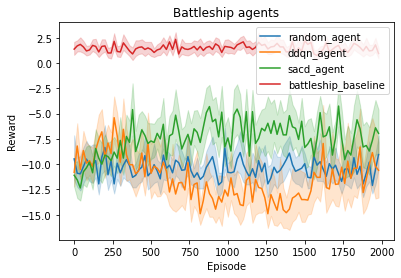

In [62]:
results = []
results.append(agent_random.list_rewards)
results.append(agent_ddqn.list_rewards)
results.append(agent_sacd.list_rewards)
results.append(agent_battleship_baseline.list_rewards)
plot_results(results, rolling = 30, download=False)